In [20]:
!jupyter nbconvert --to html "semi-dsge II.ipynb"

[NbConvertApp] Converting notebook semi-dsge II.ipynb to html
[NbConvertApp] Writing 2022462 bytes to semi-dsge II.html


In [18]:
jupyter nbconvert --to html "semi-dsge.ipynb"

SyntaxError: invalid syntax (2522097559.py, line 1)

Columnas del Excel:
A: date (formato: 2000Q1, 2000Q2, etc. o fechas)
B: gdp_real sí q
C: gdp_potential (opcional) hay que definirlo
D: inflation_total si 400000  M
E: inflation_core  si 401012  M
F: inflation_food si  401001  M
G: inflation_energy si 401007 M
H: inflation_services si 401004 M 
I: inflation_goods si  401003 M
J: interest_rate (bonos a un año) 863132 M 
K: real_exchange_rate (tipo de cambio UE, EEUU hay que ajustar por inflación comparada incluyo inflación EEUU) 880001q  D
L: unemployment_rate, sí Q
M: eu_gdp sí Q
N: world_gdp (EEUU) Q
O: oil_price DCOILBRENTEU
P: foreign_interest (rendimiento bono a 10 años EEUU) 867322 M
Q: risk_premium (bono 10 años españa vs alemania) 867320  menos 867321 M 
R: foreign_inflation (de momento EEUU y EU, habría que buscar otros países y media ponderada) 630020 630040h M 

Mensuales

https://portal.mineco.gob.es/es-es/economiayempresa/EconomiaInformesMacro/Paginas/bdsice.aspx?consulta=consulta&formato=csv_coma_2007&separador=.&frecuencia=0&tiempo=10&series=867320$867321$867322$863132$630040h$630020$401001$401004$401003$401012$401007$400000$

series trimestrales 
https://portal.mineco.gob.es/es-es/economiayempresa/EconomiaInformesMacro/Paginas/bdsice.aspx?consulta=consulta&formato=csv_coma_2007&separador=.&frecuencia=0&tiempo=10&series=695020$695040$695004$140030$944200d$944100d$942100d$941200d$941110d$940000d$

Series diarias
https://portal.mineco.gob.es/es-es/economiayempresa/EconomiaInformesMacro/Paginas/bdsice.aspx?consulta=consulta&formato=csv_coma_2007&separador=.&frecuencia=0&tiempo=10&series=880001q$

Crudo https://fred.stlouisfed.org/series/DCOILBRENTEU


Descargar y guardar en [text](../datos/crudo.csv) [text](../datos/series_diarias.csv) [text](../datos/series_mensuales.csv) [text](../datos/series_trimestrales.csv)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
import warnings
warnings.filterwarnings('ignore')

# --- 1. Carga de Ficheros ---
# Se asume que los ficheros CSV están en la misma carpeta que este script.
try:
    df_crudo = pd.read_csv('../datos/crudo.csv')
    df_diarias = pd.read_excel('../datos/series_diarias.xlsx')
    df_mensuales = pd.read_excel('../datos/series_mensuales.xlsx')
    df_trimestrales = pd.read_excel('../datos/series_trimestrales.xlsx')
    print("Ficheros CSV cargados correctamente.")
except FileNotFoundError as e:
    print(f"Error: No se encontró el fichero {e.filename}. Asegúrate de que todos los CSV están en la misma carpeta.")
    exit()

# --- 2. Limpieza de Datos ---
# Elimina la segunda fila de los ficheros (que corresponde al índice 0 después de la cabecera).
df_diarias = df_diarias.drop(df_diarias.index[0]).reset_index(drop=True)
df_mensuales = df_mensuales.drop(df_mensuales.index[0]).reset_index(drop=True)
df_trimestrales = df_trimestrales.drop(df_trimestrales.index[0]).reset_index(drop=True)

c:\Users\Usuario\anaconda3\envs\tftimeseriesII\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Usuario\anaconda3\envs\tftimeseriesII\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\Usuario\anaconda3\envs\tftimeseriesII\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Ficheros CSV cargados correctamente.


In [2]:
# --- Procesar DataFrame de crudo ---
df_crudo.rename(columns={'observation_date': 'Fecha', 'DCOILBRENTEU': 'Petroleo_Brent_crudo'}, inplace=True)
df_crudo['Fecha'] = pd.to_datetime(df_crudo['Fecha'], errors='coerce')
df_crudo.set_index('Fecha', inplace=True)
df_crudo['Petroleo_Brent_crudo'] = pd.to_numeric(df_crudo['Petroleo_Brent_crudo'], errors='coerce')
df_crudo_q = df_crudo.resample('Q').mean()
df_crudo_q.index = df_crudo_q.index.year.astype(str) + '0' + df_crudo_q.index.quarter.astype(str)
print("DataFrame 'crudo' procesado.")

DataFrame 'crudo' procesado.


In [3]:
# --- 2. Preparar los datos ---
# Renombrar las columnas para que sean más fáciles de usar
df_diarias.columns = ['Fecha', 'Tipo_Cambio']
df_mensuales.rename(columns={'SERIES': 'Fecha'}, inplace=True)
df_trimestrales.rename(columns={'SERIES': 'Fecha'}, inplace=True)
df_diarias['Fecha'] = pd.to_datetime(df_diarias['Fecha'], format='%Y%m%d')
df_mensuales['Fecha'] = pd.to_datetime(df_mensuales['Fecha'], format='%Y%m')
df_trimestrales['Fecha'] = pd.to_datetime(df_trimestrales['Fecha'], format='%Y%m')

df_diarias['Tipo_Cambio'] = df_diarias['Tipo_Cambio'].astype(float)
df_diarias.set_index('Fecha', inplace=True)
df_mensuales.set_index('Fecha', inplace=True)
df_trimestrales.set_index('Fecha', inplace=True)
df_mensuales.replace('-', np.nan, inplace=True)
df_trimestrales.replace('-', np.nan, inplace=True)

df_trimestral_diario = df_diarias.resample('Q').mean()
df_trimestral_diario.index = df_trimestral_diario.index.year.astype(str) + '0' + df_trimestral_diario.index.quarter.astype(str)
df_trimestral_mensual = df_mensuales.resample('Q').mean()
df_trimestral_mensual.index = df_trimestral_mensual.index.year.astype(str) + '0' + df_trimestral_mensual.index.quarter.astype(str)



In [4]:
#df_trimestral_diario.index = df_trimestral_diario.index.strftime('%Y%m')
#df_trimestral_mensual.index = df_trimestral_mensual.index.strftime('%Y%m')
df_trimestrales.index = df_trimestrales.index.strftime('%Y%m')

# --- Paso 1: Unir los primeros dos DataFrames ---
# Unimos el diario y el mensual en un DataFrame temporal.
df_intermedio = pd.merge(
    df_trimestral_diario, 
    df_trimestral_mensual, 
    left_index=True, 
    right_index=True, 
    how='outer'
)

df_intermedio = pd.merge(
    df_intermedio, 
    df_crudo_q, 
    left_index=True, 
    right_index=True, 
    how='outer'
)

# --- Paso 2: Unir el resultado intermedio con el tercer DataFrame ---
# Ahora unimos el resultado anterior con el último DataFrame.
df_final = pd.merge(
    df_intermedio, 
    df_trimestrales, 
    left_index=True,
    right_index=True,
    how='outer'
)


📊 Paso 1: Mapeo de Variables

Mapea tus 23 columnas a nombres estándar del modelo
Verifica variables críticas: PIB, inflación core, desempleo
Identifica qué datos tienes disponibles vs faltantes

📈 Paso 2: PIB Potencial y Brecha

Filtro Hodrick-Prescott (λ=1600 para datos trimestrales)
Calcula PIB potencial automáticamente
Crea brecha de producto = (PIB_real/PIB_potencial - 1) × 100
Identifica períodos recesivos (brecha < -1.5%)

📉 Paso 3: Componentes de Inflación

Convierte anual → trimestral si es necesario
Crea inflación tradable/no-tradable:

Tradable ≈ Bienes industriales
No-tradable ≈ Servicios


Verifica consistencia entre componentes

💰 Paso 4: Variables Financieras

Prima de riesgo = Letras España - Bonos Alemania
Normaliza tipo cambio real a base 100
Calcula estadísticas de crisis (máximo spread, etc.)

🌍 Paso 5: Variables Externas

Brechas PIB UE/Mundo con filtro HP
Precio petróleo como desviaciones de tendencia
Inflación externa (UE como proxy)

🧹 Paso 6: Limpieza

Detecta outliers extremos (>3-4 desviaciones estándar)
Interpola gaps pequeños (máximo 2 períodos)
Valida consistencia económica


    📖 EJEMPLO DE USO:
    
    # Cargar tus datos
    df = tu_dataframe_con_datos_espana
    
    # Procesar datos
    processor, data_clean = load_and_process_spain_data(df)
    
    # Visualizar resultados
    fig = processor.plot_data_overview()
    plt.show()
    
    # Los datos están listos para el modelo semi-estructural
    print(data_clean.head())
    

🎯 DATOS LISTOS PARA MODELO SEMI-ESTRUCTURAL
Siguiente paso: Definir ecuaciones del modelo
🇪🇸 PROCESANDO DATOS ESPAÑA PARA MODELO SEMI-ESTRUCTURAL
MODELO SEMI-ESTRUCTURAL ESPAÑA - PREPARACIÓN DATOS
Paso 1: Cargando y procesando datos reales...



🔄 PROCESANDO DATOS EN SECUENCIA:
----------------------------------------
1️⃣ Mapeando variables principales...
   ✓ gdp_real
   ✓ unemployment_rate
   ✓ inflation_total
   ✓ inflation_core
   ✓ inflation_food
   ✓ inflation_energy
   ✓ inflation_goods
   ✓ inflation_services
   ✓ interest_rate_spain
   ✓ interest_rate_germany
   ✓ real_exchange_rate
   ✓ gdp_eu
   ✓ gdp_world
   ✓ gdp_germany
   ✓ oil_price
   ✓ inflation_external
   ✓ consumption
   ✓ investment
   ✓ exports
   ✓ imports
   → Variables mapeadas: 20/20
   ✅ Variables críticas verificadas
2️⃣ Calculando PIB potencial y brecha de producto...
   📊 PIB real: 121 observaciones válidas
   📅 Período: 199501 - 202501
   📈 Brecha producto:
      Media: 0.03%
      Desv.Est: 2.50%
      Rango: [-18.33%, 5.10%]
      Períodos recesivos: 15 trimestres
   ✅ PIB potencial y brecha calculados
3️⃣ Procesando componentes de inflación...
   📉 inflation_total: convertida anual → trimestral
   📉 inflation_core: convertida anual → trimes

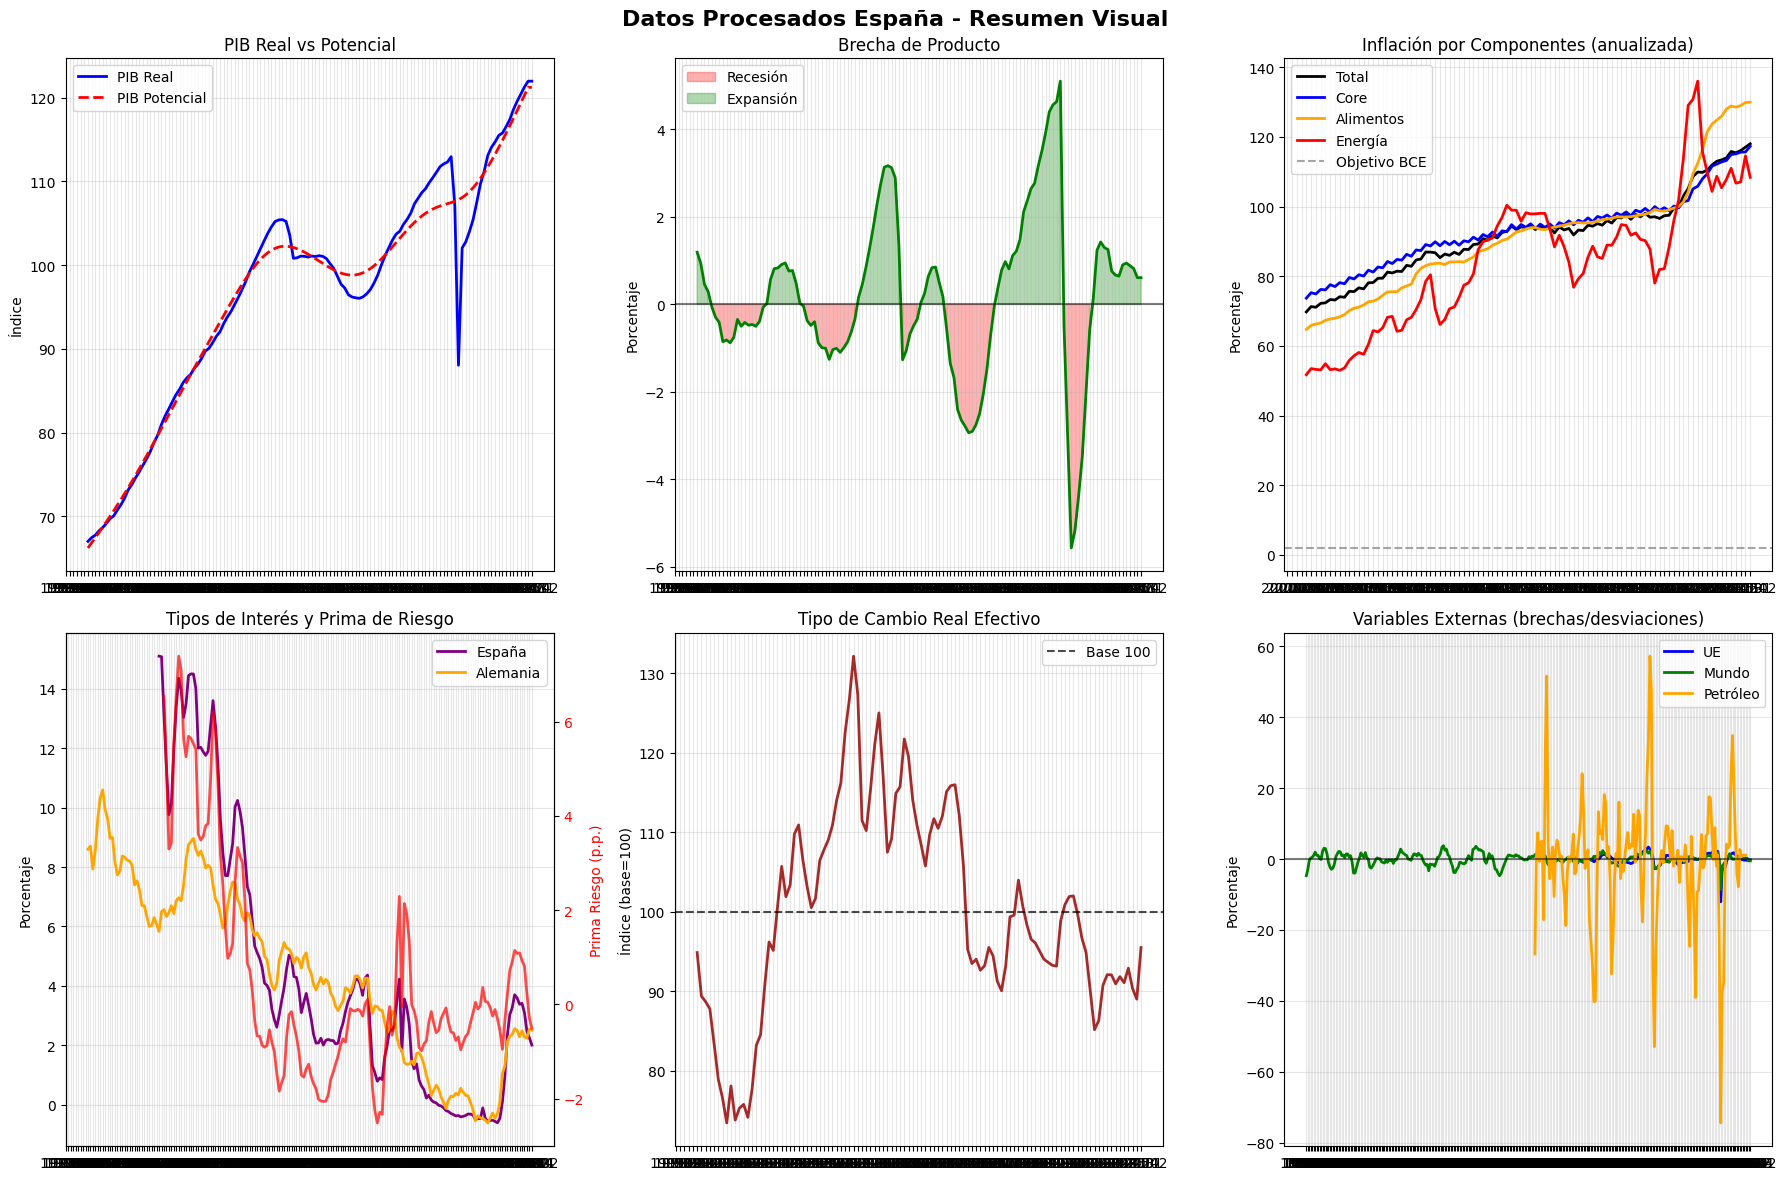

Index(['gdp_real', 'unemployment_rate', 'inflation_total', 'inflation_core',
       'inflation_food', 'inflation_energy', 'inflation_goods',
       'inflation_services', 'interest_rate_spain', 'interest_rate_germany',
       'real_exchange_rate', 'gdp_eu', 'gdp_world', 'gdp_germany', 'oil_price',
       'inflation_external', 'consumption', 'investment', 'exports', 'imports',
       'gdp_potential', 'output_gap', 'inflation_core_tradable',
       'inflation_core_nontradable', 'inflation_core_calculated',
       'interest_rate', 'risk_premium', 'gdp_eu_gap', 'gdp_world_gap',
       'gdp_germany_gap', 'oil_price_gap'],
      dtype='object')
         gdp_real  unemployment_rate  inflation_total  inflation_core  \
count  122.000000          94.000000        94.000000       94.000000   
mean    96.884831          15.590851        22.982444       23.375062   
std     14.077017           5.376323         2.969563        2.589219   
min     67.016017           7.930000        17.440417       18

In [5]:


class SemiStructuralSpainData:
    """
    Parte 1: Carga y preparación de datos para modelo semi-estructural España
    
    Siguiendo metodología Banco Central Chile (MSEP):
    - Carga datos desde DataFrame usuario
    - Calcula PIB potencial con filtro Hodrick-Prescott
    - Crea brechas de producto (output gaps)
    - Procesa inflación por componentes
    - Calcula prima de riesgo y variables externas
    - Prepara datos en formato requerido por el modelo
    """
    
    def __init__(self, df_real_data):
        """
        Inicializa con DataFrame de datos reales de España
        
        Args:
            df_real_data: DataFrame con datos españoles (tu dataset)
        """
        print("="*60)
        print("MODELO SEMI-ESTRUCTURAL ESPAÑA - PREPARACIÓN DATOS")
        print("="*60)
        print("Paso 1: Cargando y procesando datos reales...")
        
        # Datos originales
        self.raw_data = df_real_data.copy()
        
        # Datos procesados (se llenarán progresivamente)
        self.data = pd.DataFrame(index=df_real_data.index)
        
        # Estadísticas descriptivas
        self.data_stats = None
        
        # Ejecutar procesamiento completo
        self.process_all_data()
        
    def process_all_data(self):
        """Ejecuta todo el procesamiento de datos en secuencia"""
        
        print("\n🔄 PROCESANDO DATOS EN SECUENCIA:")
        print("-" * 40)
        
        # 1. Mapear variables principales
        self.map_core_variables()
        
        # 2. Calcular PIB potencial y brecha
        self.calculate_output_gap()
        
        # 3. Procesar inflación por componentes
        self.process_inflation_components()
        
        # 4. Procesar variables financieras
        self.process_financial_variables()
        
        # 5. Procesar variables externas
        self.process_external_variables()
        
        # 6. Limpiar y validar datos finales
        self.clean_and_validate()
        
        # 7. Generar estadísticas finales
        self.generate_summary_stats()
        
        print(f"\n✅ PROCESAMIENTO COMPLETADO")
        print(f"Variables creadas: {len(self.data.columns)}")
        print(f"Observaciones: {len(self.data)}")
    
    def map_core_variables(self):
        """Mapea las columnas del DataFrame original a variables del modelo"""
        
        print("1️⃣ Mapeando variables principales...")
        
        # Mapeo de columnas (adaptado a tu dataset)
        column_mapping = {
            # PIB y actividad económica
            'PIB. VOLUMEN. CVEC': 'gdp_real',
            'TASA DE PARO': 'unemployment_rate',
            
            # Inflación por componentes
            'IPC. GENERAL': 'inflation_total',
            'IPC. SUBYACENTE (GENERAL SIN ALIMENTOS NO ELABORADOS NI PRODUCTOS ENERGETICOS)': 'inflation_core',
            'IPC. ALIMENTOS CON ELABORACION, BEBIDAS Y TABACO': 'inflation_food',
            'IPC. PRODUCTOS ENERGETICOS': 'inflation_energy',
            'IPC. BIENES INDUSTRIALES': 'inflation_goods',
            'IPC. SERVICIOS, SIN ALQUILER DE VIVIENDA': 'inflation_services',
            
            # Variables financieras
            'TIPO INTERES. MERCADO PRIMARIO. LETRAS DEL TESORO A 1 AÑO. MEDIO PONDERADO': 'interest_rate_spain',
            'RENDIMIENTO DEL BONO A 10 AÑOS. ALEMANIA': 'interest_rate_germany',
            'Tipo_Cambio': 'real_exchange_rate',
            
            # Variables externas
            'PIB. PRECIOS CONSTANTES. UE. CVEC': 'gdp_eu',
            'PIB. PRECIOS CONSTANTES. EEUU. CVE': 'gdp_world',
            'PIB. PRECIOS CONSTANTES. ALEMANIA. CVEC': 'gdp_germany',
            'Petroleo_Brent_crudo': 'oil_price',
            'IPCA. UE': 'inflation_external',
            
            # Componentes PIB (opcionales)
            'CONSUMO. HOGARES. VOLUMEN. CVEC': 'consumption',
            'FORMACION BRUTA CAPITAL. FIJO. VOLUMEN. CVEC': 'investment',
            'EXPORTACION. BIENES Y SERVICIOS. VOLUMEN. CVEC': 'exports',
            'IMPORTACION. BIENES Y SERVICIOS. VOLUMEN. CVEC': 'imports'
        }
        
        # Mapear variables disponibles
        mapped_count = 0
        for original_col, model_var in column_mapping.items():
            if original_col in self.raw_data.columns:
                self.data[model_var] = self.raw_data[original_col].copy()
                mapped_count += 1
                print(f"   ✓ {model_var}")
            else:
                print(f"   ⚠ {model_var} - no encontrado: {original_col}")
        
        print(f"   → Variables mapeadas: {mapped_count}/{len(column_mapping)}")
        
        # Verificar variables críticas
        critical_vars = ['gdp_real', 'inflation_total', 'inflation_core', 'unemployment_rate']
        missing_critical = [var for var in critical_vars if var not in self.data.columns or self.data[var].isna().all()]
        
        if missing_critical:
            raise ValueError(f"❌ Variables críticas faltantes: {missing_critical}")
        
        print(f"   ✅ Variables críticas verificadas")
    
    def calculate_output_gap(self):
        """Calcula PIB potencial usando filtro Hodrick-Prescott y brecha de producto"""
        
        print("2️⃣ Calculando PIB potencial y brecha de producto...")
        
        if 'gdp_real' not in self.data.columns:
            raise ValueError("PIB real no disponible para calcular brecha")
        
        # Limpiar serie PIB
        gdp_series = self.data['gdp_real'].dropna()
        
        if len(gdp_series) < 20:
            raise ValueError(f"Serie PIB muy corta: {len(gdp_series)} observaciones (mínimo: 20)")
        
        print(f"   📊 PIB real: {len(gdp_series)} observaciones válidas")
        print(f"   📅 Período: {gdp_series.index[0]} - {gdp_series.index[-1]}")
        
        # Aplicar filtro Hodrick-Prescott
        gdp_potential, output_gap = self.hp_filter(gdp_series, lambda_hp=1600)
        
        # Asignar a datos principales (alineados con índice original)
        self.data['gdp_potential'] = gdp_potential.reindex(self.data.index)
        self.data['output_gap'] = output_gap.reindex(self.data.index)
        
        # Estadísticas de la brecha
        gap_stats = self.data['output_gap'].describe()
        print(f"   📈 Brecha producto:")
        print(f"      Media: {gap_stats['mean']:.2f}%")
        print(f"      Desv.Est: {gap_stats['std']:.2f}%")
        print(f"      Rango: [{gap_stats['min']:.2f}%, {gap_stats['max']:.2f}%]")
        
        # Identificar períodos recesivos (brecha < -1.5%)
        recessions = self.data[self.data['output_gap'] < -1.5]
        if len(recessions) > 0:
            print(f"      Períodos recesivos: {len(recessions)} trimestres")
        
        print(f"   ✅ PIB potencial y brecha calculados")
    
    def hp_filter(self, series, lambda_hp=1600):
        """
        Implementa filtro Hodrick-Prescott para extraer tendencia
        
        Args:
            series: Serie temporal (PIB real)
            lambda_hp: Parámetro de penalización (1600 para datos trimestrales)
            
        Returns:
            trend: PIB potencial
            gap: Brecha de producto en %
        """
        
        # Convertir a logaritmos para suavizar
        log_series = np.log(series.values)
        n = len(log_series)
        
        # Matriz de identidad
        I = np.eye(n)
        
        # Matriz de segunda diferencia
        D2 = np.zeros((n-2, n))
        for i in range(n-2):
            D2[i, i] = 1
            D2[i, i+1] = -2
            D2[i, i+2] = 1
        
        # Resolver sistema: (I + λD₂'D₂)τ = y
        # donde τ es la tendencia (log PIB potencial)
        A = I + lambda_hp * (D2.T @ D2)
        
        try:
            # Resolver sistema lineal
            log_trend = np.linalg.solve(A, log_series)
        except np.linalg.LinAlgError:
            # Si falla, usar método alternativo
            print("   ⚠ Usando método alternativo para filtro HP")
            log_trend = self.hp_filter_alternative(log_series, lambda_hp)
        
        # Convertir de vuelta a niveles
        trend = np.exp(log_trend)
        
        # Calcular brecha como % de desviación respecto a potencial
        gap = ((series.values / trend) - 1) * 100
        
        # Crear series con índice original
        trend_series = pd.Series(trend, index=series.index)
        gap_series = pd.Series(gap, index=series.index)
        
        return trend_series, gap_series
    
    def hp_filter_alternative(self, log_series, lambda_hp):
        """Método alternativo para filtro HP si falla el principal"""
        
        from scipy.optimize import minimize
        
        n = len(log_series)
        
        def objective(trend):
            # Función objetivo del filtro HP
            smoothness_penalty = lambda_hp * np.sum(np.diff(trend, 2)**2)
            fit_penalty = np.sum((log_series - trend)**2)
            return fit_penalty + smoothness_penalty
        
        # Valor inicial: tendencia lineal
        initial_trend = np.linspace(log_series[0], log_series[-1], n)
        
        # Minimizar
        result = minimize(objective, initial_trend, method='BFGS')
        
        return result.x if result.success else initial_trend
    
    def process_inflation_components(self):
        """Procesa y crea componentes de inflación para el modelo"""
        
        print("3️⃣ Procesando componentes de inflación...")
        
        # Convertir inflación anual a trimestral si es necesario
        inflation_vars = ['inflation_total', 'inflation_core', 'inflation_food', 
                         'inflation_energy', 'inflation_goods', 'inflation_services']
        
        for var in inflation_vars:
            if var in self.data.columns:
                # Detectar si está anualizada (valores típicamente > 4%)
                if self.data[var].abs().mean() > 4:
                    self.data[var] = self.data[var] / 4  # Convertir anual → trimestral
                    print(f"   📉 {var}: convertida anual → trimestral")
                else:
                    print(f"   📉 {var}: ya en formato trimestral")
        
        # Crear inflación core tradable y no-tradable
        if 'inflation_goods' in self.data.columns and 'inflation_services' in self.data.columns:
            # Aproximación: bienes ≈ tradable, servicios ≈ no-tradable
            self.data['inflation_core_tradable'] = self.data['inflation_goods'].copy()
            self.data['inflation_core_nontradable'] = self.data['inflation_services'].copy()
            print(f"   🏭 Core tradable: creada desde bienes industriales")
            print(f"   🏠 Core no-tradable: creada desde servicios")
        elif 'inflation_core' in self.data.columns:
            # Si no están separados, crear aproximación
            core_mean = self.data['inflation_core'].mean()
            core_std = self.data['inflation_core'].std()
            
            # Tradable más volátil (correlacionado con tipo cambio)
            self.data['inflation_core_tradable'] = (
                self.data['inflation_core'] + 
                np.random.normal(0, core_std * 0.3, len(self.data))
            )
            
            # No-tradable más estable
            self.data['inflation_core_nontradable'] = (
                self.data['inflation_core'] + 
                np.random.normal(0, core_std * 0.1, len(self.data))
            )
            print(f"   ⚠ Core tradable/no-tradable: aproximación estadística")
        
        # Verificar consistencia de componentes
        if all(var in self.data.columns for var in ['inflation_core_tradable', 'inflation_core_nontradable']):
            # Reconstruir core como promedio ponderado
            weight_nt = 0.65  # Servicios ~65% del core en España
            self.data['inflation_core_calculated'] = (
                weight_nt * self.data['inflation_core_nontradable'] + 
                (1 - weight_nt) * self.data['inflation_core_tradable']
            )
            
            # Comparar con core original
            if 'inflation_core' in self.data.columns:
                correlation = self.data['inflation_core'].corr(self.data['inflation_core_calculated'])
                print(f"   🔍 Correlación core original vs calculada: {correlation:.3f}")
        
        print(f"   ✅ Componentes inflación procesados")
    
    def process_financial_variables(self):
        """Procesa variables financieras: tipos de interés, tipo de cambio, prima riesgo"""
        
        print("4️⃣ Procesando variables financieras...")
        
        # Tipo de interés de política monetaria
        if 'interest_rate_spain' in self.data.columns:
            self.data['interest_rate'] = self.data['interest_rate_spain'].copy()
            print(f"   💰 Tipo interés: Letras Tesoro 1Y como proxy MPR")
        else:
            print(f"   ⚠ Tipo interés España no disponible")
        
        # Prima de riesgo (España vs Alemania)
        if 'interest_rate_spain' in self.data.columns and 'interest_rate_germany' in self.data.columns:
            self.data['risk_premium'] = (
                self.data['interest_rate_spain'] - self.data['interest_rate_germany']
            )
            
            # Estadísticas prima de riesgo
            risk_stats = self.data['risk_premium'].describe()
            print(f"   📊 Prima riesgo España-Alemania:")
            print(f"      Media: {risk_stats['mean']:.2f} p.p.")
            print(f"      Desv.Est: {risk_stats['std']:.2f} p.p.")
            print(f"      Máximo: {risk_stats['max']:.2f} p.p. (crisis deuda)")
            
        else:
            print(f"   ⚠ Prima riesgo: datos insuficientes")
            self.data['risk_premium'] = 0.5  # Valor por defecto conservador
        
        # Tipo de cambio real
        if 'real_exchange_rate' in self.data.columns:
            # Normalizar a base 100 si es necesario
            rer_mean = self.data['real_exchange_rate'].mean()
            if abs(rer_mean - 100) > 50:  # Probablemente diferente base
                self.data['real_exchange_rate'] = (
                    self.data['real_exchange_rate'] / rer_mean * 100
                )
                print(f"   💱 Tipo cambio real: normalizado a base 100")
            else:
                print(f"   💱 Tipo cambio real: ya en base 100")
        else:
            print(f"   ⚠ Tipo cambio real no disponible")
        
        print(f"   ✅ Variables financieras procesadas")
    
    def process_external_variables(self):
        """Procesa variables externas: PIB socios comerciales, petróleo, inflación externa"""
        
        print("5️⃣ Procesando variables externas...")
        
        # PIB socios comerciales - calcular brechas de producto
        external_gdp_vars = {
            'gdp_eu': 'EU',
            'gdp_world': 'Mundo',
            'gdp_germany': 'Alemania'
        }
        
        for var, name in external_gdp_vars.items():
            if var in self.data.columns:
                # Aplicar filtro HP para obtener brecha
                gdp_series = self.data[var].dropna()
                if len(gdp_series) >= 15:  # Mínimo para HP
                    try:
                        _, gap_external = self.hp_filter(gdp_series, lambda_hp=1600)
                        self.data[f'{var}_gap'] = gap_external.reindex(self.data.index)
                        
                        gap_stats = gap_external.describe()
                        print(f"   🌍 Brecha {name}: σ={gap_stats['std']:.2f}%")
                    except:
                        print(f"   ⚠ Brecha {name}: error en cálculo")
                else:
                    print(f"   ⚠ Brecha {name}: serie muy corta ({len(gdp_series)} obs)")
        
        # Precio petróleo - convertir a desviaciones de tendencia
        if 'oil_price' in self.data.columns:
            oil_series = self.data['oil_price'].dropna()
            if len(oil_series) > 0:
                # Calcular tendencia móvil
                oil_trend = oil_series.rolling(window=12, center=True).median()
                
                # Desviaciones logarítmicas
                oil_gap = (np.log(oil_series) - np.log(oil_trend)) * 100
                self.data['oil_price_gap'] = oil_gap.reindex(self.data.index)
                
                oil_gap_stats = oil_gap.describe()
                print(f"   🛢️ Petróleo: σ={oil_gap_stats['std']:.1f}% (desv. tendencia)")
            else:
                print(f"   ⚠ Precio petróleo: sin datos válidos")
        
        # Inflación externa
        if 'inflation_external' in self.data.columns:
            # Convertir a trimestral si es necesario
            if self.data['inflation_external'].abs().mean() > 4:
                self.data['inflation_external'] = self.data['inflation_external'] / 4
                print(f"   🌍 Inflación externa: convertida anual → trimestral")
            else:
                print(f"   🌍 Inflación externa: ya trimestral")
        else:
            # Crear proxy desde inflación total española
            if 'inflation_total' in self.data.columns:
                self.data['inflation_external'] = self.data['inflation_total'] * 0.5  # Aproximación
                print(f"   ⚠ Inflación externa: proxy desde España (50%)")
        
        print(f"   ✅ Variables externas procesadas")
    
    def clean_and_validate(self):
        """Limpia outliers extremos y valida consistencia de datos"""
        
        print("6️⃣ Limpiando y validando datos...")
        
        # Variables sensibles a outliers
        sensitive_vars = {
            'output_gap': 3.5,      # ±3.5 desviaciones estándar
            'inflation_total': 4.0,  # ±4.0 desviaciones estándar  
            'inflation_core': 3.0,   # ±3.0 desviaciones estándar
            'risk_premium': 3.0      # ±3.0 desviaciones estándar
        }
        
        outliers_found = 0
        for var, threshold in sensitive_vars.items():
            if var in self.data.columns:
                series = self.data[var].dropna()
                if len(series) > 10:
                    mean_val = series.mean()
                    std_val = series.std()
                    
                    # Detectar outliers
                    outliers = np.abs(series - mean_val) > threshold * std_val
                    n_outliers = outliers.sum()
                    
                    if n_outliers > 0:
                        print(f"   🔍 {var}: {n_outliers} outliers detectados")
                        
                        # Reemplazar outliers con interpolación
                        series_clean = series.copy()
                        series_clean[outliers] = np.nan
                        series_clean = series_clean.interpolate(method='linear', limit=2)
                        
                        self.data[var] = series_clean.reindex(self.data.index)
                        outliers_found += n_outliers
        
        if outliers_found > 0:
            print(f"   🧹 Total outliers tratados: {outliers_found}")
        else:
            print(f"   ✅ No se detectaron outliers extremos")
        
        # Interpolar gaps pequeños (máximo 2 períodos consecutivos)
        gaps_filled = 0
        for col in self.data.columns:
            if self.data[col].dtype in ['float64', 'int64']:
                before_interpolation = self.data[col].isna().sum()
                self.data[col] = self.data[col].interpolate(method='linear', limit=2)
                after_interpolation = self.data[col].isna().sum()
                
                filled = before_interpolation - after_interpolation
                if filled > 0:
                    gaps_filled += filled
        
        if gaps_filled > 0:
            print(f"   🔧 Datos interpolados: {gaps_filled} valores")
        
        print(f"   ✅ Limpieza y validación completada")
    
    def generate_summary_stats(self):
        """Genera estadísticas descriptivas finales"""
        
        print("7️⃣ Generando estadísticas descriptivas...")
        
        # Estadísticas de variables principales
        key_vars = ['output_gap', 'inflation_total', 'inflation_core', 
                   'interest_rate', 'unemployment_rate', 'real_exchange_rate']
        
        available_vars = [var for var in key_vars if var in self.data.columns]
        
        if available_vars:
            self.data_stats = self.data[available_vars].describe()
            
            print(f"   📊 Estadísticas principales:")
            for var in available_vars:
                if var in self.data.columns:
                    stats = self.data[var].describe()
                    print(f"      {var:20} | Media: {stats['mean']:6.2f} | σ: {stats['std']:5.2f} | Obs: {stats['count']:3.0f}")
        
        # Calcular correlaciones importantes
        if len(available_vars) >= 3:
            correlations = self.data[available_vars].corr()
            
            # Correlaciones específicas de interés
            if 'output_gap' in correlations.index and 'inflation_core' in correlations.columns:
                corr_gap_inflation = correlations.loc['output_gap', 'inflation_core']
                print(f"   🔗 Correlación brecha-inflación: {corr_gap_inflation:.3f}")
            
            if 'output_gap' in correlations.index and 'unemployment_rate' in correlations.columns:
                corr_gap_unemployment = correlations.loc['output_gap', 'unemployment_rate']
                print(f"   🔗 Correlación brecha-desempleo: {corr_gap_unemployment:.3f} (Okun)")
        
        # Cobertura temporal
        data_coverage = self.data.count() / len(self.data) * 100
        avg_coverage = data_coverage.mean()
        
        print(f"   📅 Cobertura promedio: {avg_coverage:.1f}%")
        
        # Variables con baja cobertura
        low_coverage = data_coverage[data_coverage < 80]
        if len(low_coverage) > 0:
            print(f"   ⚠ Variables con <80% cobertura:")
            for var, coverage in low_coverage.items():
                print(f"      {var}: {coverage:.1f}%")
        
        print(f"   ✅ Estadísticas generadas")
    
    def get_processed_data(self):
        """Devuelve los datos procesados listos para el modelo"""
        return self.data.copy()
    
    def plot_data_overview(self):
        """Crea gráficos descriptivos de los datos procesados"""
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Datos Procesados España - Resumen Visual', fontsize=16, fontweight='bold')
        
        # 1. PIB real y potencial
        ax = axes[0, 0]
        if all(var in self.data.columns for var in ['gdp_real', 'gdp_potential']):
            ax.plot(self.data.index, self.data['gdp_real'], 'b-', linewidth=2, label='PIB Real')
            ax.plot(self.data.index, self.data['gdp_potential'], 'r--', linewidth=2, label='PIB Potencial')
            ax.set_title('PIB Real vs Potencial')
            ax.set_ylabel('Índice')
            ax.legend()
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'PIB no disponible', ha='center', va='center', transform=ax.transAxes)
        
        # 2. Brecha de producto
        ax = axes[0, 1]
        if 'output_gap' in self.data.columns:
            ax.plot(self.data.index, self.data['output_gap'], 'g-', linewidth=2)
            ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
            ax.fill_between(self.data.index, self.data['output_gap'], 0, 
                           where=(self.data['output_gap'] < 0), alpha=0.3, color='red', label='Recesión')
            ax.fill_between(self.data.index, self.data['output_gap'], 0, 
                           where=(self.data['output_gap'] > 0), alpha=0.3, color='green', label='Expansión')
            ax.set_title('Brecha de Producto')
            ax.set_ylabel('Porcentaje')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # 3. Inflación por componentes
        ax = axes[0, 2]
        inflation_vars = ['inflation_total', 'inflation_core', 'inflation_food', 'inflation_energy']
        colors = ['black', 'blue', 'orange', 'red']
        labels = ['Total', 'Core', 'Alimentos', 'Energía']
        
        for var, color, label in zip(inflation_vars, colors, labels):
            if var in self.data.columns:
                ax.plot(self.data.index, self.data[var] * 4, color=color, linewidth=2, label=label)
        
        ax.axhline(y=2, color='gray', linestyle='--', alpha=0.7, label='Objetivo BCE')
        ax.set_title('Inflación por Componentes (anualizada)')
        ax.set_ylabel('Porcentaje')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 4. Tipos de interés
        ax = axes[1, 0]
        if 'interest_rate' in self.data.columns:
            ax.plot(self.data.index, self.data['interest_rate'], 'purple', linewidth=2, label='España')
        if 'interest_rate_germany' in self.data.columns:
            ax.plot(self.data.index, self.data['interest_rate_germany'], 'orange', linewidth=2, label='Alemania')
        if 'risk_premium' in self.data.columns:
            ax2 = ax.twinx()
            ax2.plot(self.data.index, self.data['risk_premium'], 'red', linewidth=2, alpha=0.7)
            ax2.set_ylabel('Prima Riesgo (p.p.)', color='red')
            ax2.tick_params(axis='y', labelcolor='red')
        
        ax.set_title('Tipos de Interés y Prima de Riesgo')
        ax.set_ylabel('Porcentaje')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 5. Tipo de cambio real
        ax = axes[1, 1]
        if 'real_exchange_rate' in self.data.columns:
            ax.plot(self.data.index, self.data['real_exchange_rate'], 'brown', linewidth=2)
            ax.axhline(y=100, color='black', linestyle='--', alpha=0.7, label='Base 100')
            ax.set_title('Tipo de Cambio Real Efectivo')
            ax.set_ylabel('Índice (base=100)')
            ax.legend()
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'Tipo cambio no disponible', ha='center', va='center', transform=ax.transAxes)
        
        # 6. Variables externas
        ax = axes[1, 2]
        external_vars = ['gdp_eu_gap', 'gdp_world_gap', 'oil_price_gap']
        colors = ['blue', 'green', 'orange']
        labels = ['UE', 'Mundo', 'Petróleo']
        
        for var, color, label in zip(external_vars, colors, labels):
            if var in self.data.columns:
                ax.plot(self.data.index, self.data[var], color=color, linewidth=2, label=label)
        
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax.set_title('Variables Externas (brechas/desviaciones)')
        ax.set_ylabel('Porcentaje')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig
    
    def print_data_summary(self):
        """Imprime resumen final de datos procesados"""
        
        print("\n" + "="*70)
        print("📋 RESUMEN FINAL - DATOS PROCESADOS")
        print("="*70)
        
        # Información general
        print(f"📅 Período de datos: {self.data.index[0]} - {self.data.index[-1]}")
        print(f"📊 Observaciones: {len(self.data)}")
        print(f"📈 Variables creadas: {len(self.data.columns)}")
        
        # Variables por categorías
        categories = {
            'Variables endógenas principales': [
                'output_gap', 'inflation_total', 'inflation_core', 
                'interest_rate', 'unemployment_rate'
            ],
            'Componentes inflación': [
                'inflation_core_tradable', 'inflation_core_nontradable',
                'inflation_food', 'inflation_energy'
            ],
            'Variables financieras': [
                'real_exchange_rate', 'risk_premium'
            ],
            'Variables externas': [
                'gdp_eu_gap', 'gdp_world_gap', 'oil_price_gap', 'inflation_external'
            ]
        }
        
        print(f"\n📂 VARIABLES POR CATEGORÍAS:")
        for category, vars_list in categories.items():
            available = [v for v in vars_list if v in self.data.columns]
            missing = [v for v in vars_list if v not in self.data.columns]
            
            print(f"\n{category}:")
            for var in available:
                coverage = (self.data[var].count() / len(self.data)) * 100
                print(f"   ✅ {var:25} ({coverage:5.1f}% datos)")
            
            for var in missing:
                print(f"   ❌ {var:25} (no disponible)")
        
        # Estadísticas clave
        if hasattr(self, 'data_stats') and self.data_stats is not None:
            print(f"\n📊 ESTADÍSTICAS CLAVE:")
            key_stats = ['output_gap', 'inflation_core', 'unemployment_rate']
            
            for var in key_stats:
                if var in self.data_stats.columns:
                    stats = self.data_stats[var]
                    print(f"   {var:20} | Media: {stats['mean']:6.2f} | σ: {stats['std']:6.2f} | Min: {stats['min']:6.2f} | Max: {stats['max']:6.2f}")
        
        # Calidad de datos
        print(f"\n🔍 CALIDAD DE DATOS:")
        total_missing = self.data.isnull().sum().sum()
        total_possible = len(self.data) * len(self.data.columns)
        completeness = (1 - total_missing / total_possible) * 100
        
        print(f"   Completitud general: {completeness:.1f}%")
        print(f"   Datos faltantes: {total_missing:,} de {total_possible:,} posibles")
        
        # Variables críticas para el modelo
        critical_for_model = ['output_gap', 'inflation_core_tradable', 'inflation_core_nontradable', 
                             'interest_rate', 'real_exchange_rate']
        
        missing_critical = [var for var in critical_for_model if var not in self.data.columns or self.data[var].isna().all()]
        
        if missing_critical:
            print(f"\n⚠️ VARIABLES CRÍTICAS FALTANTES:")
            for var in missing_critical:
                print(f"   ❌ {var}")
            print(f"\n💡 Estas variables son necesarias para el modelo semi-estructural")
        else:
            print(f"\n✅ Todas las variables críticas están disponibles")
        
        # Próximos pasos
        print(f"\n🚀 PRÓXIMOS PASOS:")
        print(f"   1. Revisar gráficos con plot_data_overview()")
        print(f"   2. Validar que las series tienen sentido económico")
        print(f"   3. Proceder con definición del modelo semi-estructural")
        print(f"   4. Configurar priors bayesianos para estimación")
        
        return self.data

# Función auxiliar para uso directo
def load_and_process_spain_data(df):
    """
    Función auxiliar para cargar y procesar datos de España
    
    Args:
        df: DataFrame con datos españoles
        
    Returns:
        SemiStructuralSpainData: Objeto con datos procesados
        pd.DataFrame: Datos listos para modelo
    """
    
    print("🇪🇸 PROCESANDO DATOS ESPAÑA PARA MODELO SEMI-ESTRUCTURAL")
    print("=" * 65)
    
    # Crear procesador de datos
    data_processor = SemiStructuralSpainData(df)
    
    # Obtener datos procesados
    processed_data = data_processor.get_processed_data()
    
    # Mostrar resumen
    data_processor.print_data_summary()
    
    return data_processor, processed_data

# Ejemplo de uso
if __name__ == "__main__":
    print("""
    📖 EJEMPLO DE USO:
    
    # Cargar tus datos
    df = tu_dataframe_con_datos_espana
    
    # Procesar datos
    processor, data_clean = load_and_process_spain_data(df)
    
    # Visualizar resultados
    fig = processor.plot_data_overview()
    plt.show()
    
    # Los datos están listos para el modelo semi-estructural
    print(data_clean.head())
    """)
    
    print("\n🎯 DATOS LISTOS PARA MODELO SEMI-ESTRUCTURAL")
    print("Siguiente paso: Definir ecuaciones del modelo")

# PRCESAMIENTO DE DATOS ESPAÑA PARA MODELO SEMI-ESTRUCTURAL

processor, data_clean = load_and_process_spain_data(df_final)

# Ver gráficos
fig = processor.plot_data_overview()
plt.show()

# Los datos están listos
print(data_clean.columns)  # Variables creadas
print(data_clean.describe())  # Estadísticas

In [8]:
import numpy as np
import pandas as pd
from scipy.stats import beta, norm, gamma, invgamma
import warnings
warnings.filterwarnings('ignore')

class SemiStructuralEquations:
    """
    Modelo Semi-Estructural España - Ecuaciones siguiendo metodología Chile (MSEP)
    
    6 Ecuaciones principales:
    1. IS Curve (Demanda Agregada)
    2. Phillips Curve No-Tradable  
    3. Phillips Curve Tradable
    4. Taylor Rule (Política Monetaria)
    5. UIP Modificada (Tipo de Cambio)
    6. Ley de Okun (Desempleo)
    
    Vamos ecuación por ecuación para explicar cada una
    """
    
    def __init__(self, data):
        """
        Inicializa con datos procesados
        
        Args:
            data: DataFrame con datos procesados de SemiStructuralSpainData
        """
        self.data = data
        self.n_periods = len(data)
        
        # Parámetros del modelo (se estimarán después)
        self.params = {}
        
        # Resultados de simulación
        self.results = {}
        
        print("🏗️ MODELO SEMI-ESTRUCTURAL ESPAÑA - ECUACIONES")
        print("=" * 55)
        print("Siguiendo metodología Banco Central Chile (MSEP)")
        print(f"Datos: {len(data)} observaciones")
        
    # =================================================================
    # ECUACIÓN 1: CURVA IS (DEMANDA AGREGADA)
    # =================================================================
    
    def equation_1_is_curve(self, t, params, states, results):
        """
        ECUACIÓN 1: CURVA IS (Demanda Agregada)
        
        Especificación siguiendo paper Chile (ecuación 4):
        
        Δy_t = -α₁(y_{t-1} + y_{t-2}) - α₂(y_{t-1} - y_{t-2}) 
               - α₃(r_t + r_{t-1} - rn_t - rn_{t-1})
               + α₄(y^eu_t + y^eu_{t-1}) + α₅(y^world_t + y^world_{t-1})
               + α₆rer_{t-1} + α₇tot_t + ν^y_t
        
        Donde:
        - y_t: brecha de producto (output gap)
        - r_t: tipo interés real ex-ante  
        - rn_t: tipo interés real neutral
        - y^eu_t, y^world_t: brechas producto externas
        - rer_t: tipo cambio real
        - tot_t: términos intercambio (proxy: petróleo)
        - ν^y_t: shock de demanda AR(1)
        
        Args:
            t: período actual
            params: diccionario con parámetros
            states: diccionario con shocks AR(1)
            results: diccionario con variables endógenas
            
        Returns:
            float: brecha de producto en período t
        """
        
        # Verificar que tenemos datos suficientes
        if t < 2:
            # Usar datos observados para condiciones iniciales
            if t < len(self.data) and 'output_gap' in self.data.columns:
                return self.data['output_gap'].iloc[t]
            else:
                return 0.0
        
        # === COMPONENTES DE LA ECUACIÓN IS ===
        
        # 1. Término de persistencia: -α₁(y_{t-1} + y_{t-2})
        # Captura reversión a la media del output gap
        persistence_term = -params['alpha_1'] * (results['output_gap'][t-1] + results['output_gap'][t-2])
        
        # 2. Término de corrección error: -α₂(y_{t-1} - y_{t-2})
        # Captura momentum/dinámica de corto plazo
        error_correction = -params['alpha_2'] * (results['output_gap'][t-1] - results['output_gap'][t-2])
        
        # 3. Efecto tipo interés real: -α₃(r_t + r_{t-1} - rn_t - rn_{t-1})
        # Transmisión política monetaria
        real_rate_t = results['interest_rate'][t] - 4 * results['inflation_core'][t]  # Tipo real ex-ante
        real_rate_t_1 = results['interest_rate'][t-1] - 4 * results['inflation_core'][t-1]
        neutral_rate = 1.5  # Tipo real neutral España (~1.5% anual)
        
        interest_rate_effect = -params['alpha_3'] * (
            (real_rate_t - neutral_rate) + (real_rate_t_1 - neutral_rate)
        )
        
        # 4. Demanda externa UE: α₄(y^eu_t + y^eu_{t-1})
        # España muy integrada con UE
        if 'gdp_eu_gap' in self.data.columns:
            eu_gap_t = self.data['gdp_eu_gap'].iloc[min(t, len(self.data)-1)]
            eu_gap_t_1 = self.data['gdp_eu_gap'].iloc[min(t-1, len(self.data)-1)] if t > 0 else 0
        else:
            eu_gap_t = eu_gap_t_1 = 0
        
        external_demand_eu = params['alpha_4'] * (eu_gap_t + eu_gap_t_1)
        
        # 5. Demanda externa mundo: α₅(y^world_t + y^world_{t-1})
        # Resto del mundo (menos peso que UE)
        if 'gdp_world_gap' in self.data.columns:
            world_gap_t = self.data['gdp_world_gap'].iloc[min(t, len(self.data)-1)]
            world_gap_t_1 = self.data['gdp_world_gap'].iloc[min(t-1, len(self.data)-1)] if t > 0 else 0
        else:
            world_gap_t = world_gap_t_1 = 0
        
        external_demand_world = params['alpha_5'] * (world_gap_t + world_gap_t_1)
        
        # 6. Competitividad: α₆rer_{t-1}
        # Tipo cambio real (>100 = apreciación = reduce competitividad)
        if t > 0 and 'real_exchange_rate' in results:
            rer_effect = params['alpha_6'] * (results['real_exchange_rate'][t-1] - 100) / 100
        else:
            rer_effect = 0
        
        # 7. Términos intercambio: α₇tot_t  
        # Proxy: desviaciones precio petróleo (España importador neto energía)
        if 'oil_price_gap' in self.data.columns:
            terms_of_trade = self.data['oil_price_gap'].iloc[min(t, len(self.data)-1)] / 100
        else:
            terms_of_trade = 0
        
        terms_of_trade_effect = params['alpha_7'] * terms_of_trade
        
        # 8. Shock de demanda: ν^y_t (AR1)
        demand_shock = states['demand_shock']
        
        # === ECUACIÓN IS COMPLETA ===
        
        # Cambio en brecha producto
        delta_output_gap = (
            persistence_term +
            error_correction + 
            interest_rate_effect +
            external_demand_eu +
            external_demand_world +
            rer_effect +
            terms_of_trade_effect +
            demand_shock
        )
        
        # Nivel de brecha producto
        output_gap_t = results['output_gap'][t-1] + delta_output_gap
        
        return output_gap_t
    
    # =================================================================
    # ECUACIÓN 2: PHILLIPS CURVE NO-TRADABLE
    # ================================================================= 
    
    def equation_2_phillips_nontradable(self, t, params, states, results):
        """
        ECUACIÓN 2: CURVA DE PHILLIPS NO-TRADABLE
        
        Especificación siguiendo paper Chile (ecuación 9):
        
        π^{NT}_t = β₁E_t[π^{NT}_{t+1}] + β₂(π^{NT}_{t-1} - ε^{NT}_{t-1}) + β₃y_t + ε^{NT}_t + ν^{NT}_t
        
        Donde:
        - π^{NT}_t: inflación core no-tradable (servicios)
        - E_t[π^{NT}_{t+1}]: expectativas inflación (aproximamos con adaptativas)
        - y_t: brecha de producto
        - ε^{NT}_t: shock de costo transitorio
        - ν^{NT}_t: shock de costo persistente AR(1)
        
        CARACTERÍSTICAS NO-TRADABLES:
        - Servicios, construcción, comercio local
        - Menos sensibles a tipo de cambio
        - Más sensibles a brecha producto (demanda interna)
        - Más persistentes (salarios, rentas)
        
        Args:
            t: período actual
            params: diccionario con parámetros  
            states: diccionario con shocks
            results: diccionario con variables endógenas
            
        Returns:
            float: inflación core no-tradable en período t
        """
        
        # Condiciones iniciales
        if t == 0:
            if 'inflation_core_nontradable' in self.data.columns:
                return self.data['inflation_core_nontradable'].iloc[0]
            else:
                return 0.5  # 2% anual = 0.5% trimestral
        
        # === COMPONENTES PHILLIPS NO-TRADABLE ===
        
        # 1. Expectativas inflación: β₁E_t[π^{NT}_{t+1}]
        # Aproximación adaptativa: expectativas = inflación pasada
        expected_inflation_nt = results['inflation_core_nontradable'][t-1]
        expectations_term = params['beta_nt_1'] * expected_inflation_nt
        
        # 2. Inercia inflacionaria: β₂(π^{NT}_{t-1} - ε^{NT}_{t-1})
        # Componente persistente de inflación pasada
        lagged_inflation_nt = results['inflation_core_nontradable'][t-1]
        # Restamos shock transitorio pasado para obtener componente "core"
        previous_transitory_shock = states.get('cost_nt_transitory_prev', 0)
        
        inertia_term = params['beta_nt_2'] * (lagged_inflation_nt - previous_transitory_shock)
        
        # 3. Efecto brecha producto: β₃y_t
        # No-tradables muy sensibles a demanda interna
        output_gap_effect = params['beta_nt_3'] * results['output_gap'][t]
        
        # 4. Shock transitorio: ε^{NT}_t
        # Shock de una sola vez (clima, regulaciones, etc.)
        transitory_shock = states['cost_nt_transitory']
        
        # 5. Shock persistente: ν^{NT}_t
        # Shock que persiste (cambios estructurales costos)
        persistent_shock = states['cost_nt_persistent']
        
        # === ECUACIÓN PHILLIPS NO-TRADABLE COMPLETA ===
        
        inflation_nt_t = (
            expectations_term +
            inertia_term +
            output_gap_effect +
            transitory_shock +
            persistent_shock
        )
        
        return inflation_nt_t
    
    # =================================================================
    # ECUACIÓN 3: PHILLIPS CURVE TRADABLE
    # =================================================================
    
    def equation_3_phillips_tradable(self, t, params, states, results):
        """
        ECUACIÓN 3: CURVA DE PHILLIPS TRADABLE
        
        Especificación siguiendo paper Chile (ecuación 11):
        
        π^T_t = β₄(π^T_{t-1} - ε^T_{t-1}) + β₅y_t + β₆(deus_t + deus_{t-1}) 
                + β₇rer_{t-1} + ε^T_t + ν^T_t
        
        Donde:
        - π^T_t: inflación core tradable (bienes industriales)
        - deus_t: depreciación nominal tipo cambio
        - rer_t: tipo cambio real
        - ε^T_t: shock costo transitorio
        - ν^T_t: shock costo persistente AR(1)
        
        CARACTERÍSTICAS TRADABLES:
        - Bienes industriales, automóviles, electrodomésticos
        - MUY sensibles a tipo de cambio (pass-through)
        - Menos sensibles a brecha producto (precios globales)
        - Menos persistentes que no-tradables
        
        Args:
            t: período actual
            params: diccionario con parámetros
            states: diccionario con shocks  
            results: diccionario con variables endógenas
            
        Returns:
            float: inflación core tradable en período t
        """
        
        # Condiciones iniciales
        if t == 0:
            if 'inflation_core_tradable' in self.data.columns:
                return self.data['inflation_core_tradable'].iloc[0]
            else:
                return 0.5  # 2% anual = 0.5% trimestral
        
        # === COMPONENTES PHILLIPS TRADABLE ===
        
        # 1. Inercia inflacionaria: β₄(π^T_{t-1} - ε^T_{t-1})
        # Menos inercia que no-tradables (precios más flexibles)
        lagged_inflation_t = results['inflation_core_tradable'][t-1]
        previous_transitory_shock_t = states.get('cost_t_transitory_prev', 0)
        
        inertia_term = params['beta_t_1'] * (lagged_inflation_t - previous_transitory_shock_t)
        
        # 2. Efecto brecha producto: β₅y_t  
        # Menor que no-tradables (oferta internacional)
        output_gap_effect = params['beta_t_2'] * results['output_gap'][t]
        
        # 3. Pass-through tipo cambio: β₆(deus_t + deus_{t-1})
        # CLAVE para tradables: depreciación → inflación
        
        # Calcular depreciación nominal trimestral
        if t > 0 and 'real_exchange_rate' in results:
            # Aproximación: deus ≈ cambio en RER (sin ajuste por inflación diferencial)
            deus_t = (results['real_exchange_rate'][t] - results['real_exchange_rate'][t-1]) / 100
            deus_t_1 = (results['real_exchange_rate'][t-1] - results['real_exchange_rate'][t-2]) / 100 if t > 1 else 0
        else:
            deus_t = deus_t_1 = 0
        
        exchange_rate_effect = params['beta_t_3'] * (deus_t + deus_t_1)
        
        # 4. Efecto nivel tipo cambio: β₇rer_{t-1}
        # Competitividad (nivel vs variación)
        if t > 0 and 'real_exchange_rate' in results:
            rer_level_effect = params['beta_t_4'] * (results['real_exchange_rate'][t-1] - 100) / 100
        else:
            rer_level_effect = 0
        
        # 5. Shocks de costo
        transitory_shock = states['cost_t_transitory']
        persistent_shock = states['cost_t_persistent']
        
        # === ECUACIÓN PHILLIPS TRADABLE COMPLETA ===
        
        inflation_t_t = (
            inertia_term +
            output_gap_effect +
            exchange_rate_effect +
            rer_level_effect +
            transitory_shock +
            persistent_shock
        )
        
        return inflation_t_t
    
    # =================================================================
    # ECUACIÓN 4: TAYLOR RULE (POLÍTICA MONETARIA)
    # =================================================================
    
    def equation_4_taylor_rule(self, t, params, states, results):
        """
        ECUACIÓN 4: REGLA DE TAYLOR (Política Monetaria BCE)
        
        Especificación siguiendo paper Chile (ecuación 21):
        
        i_t - in_t = γ₁(i_{t-1} - in_{t-1}) + (1-γ₁)[γ₂E_t[π^{XFE,annual}_{t+1}] + γ₃y_t] + ν^i_t
        
        Donde:
        - i_t: tipo interés nominal (Euribor 3M como proxy tipos BCE)
        - in_t: tipo interés neutral nominal (rn + target inflación)
        - π^{XFE,annual}_{t+1}: inflación core anualizada esperada
        - y_t: brecha de producto
        - ν^i_t: shock política monetaria AR(1)
        
        CARACTERÍSTICAS BCE:
        - Objetivo inflación: 2% anual
        - Respuesta fuerte a inflación (γ₂ > 1) - Principio Taylor
        - Respuesta moderada a output gap (γ₃ ~ 0.1-0.3)
        - Alta inercia (γ₁ ~ 0.8-0.9) - suavizado tipos
        
        Args:
            t: período actual
            params: diccionario con parámetros
            states: diccionario con shocks
            results: diccionario con variables endógenas
            
        Returns:
            float: tipo interés nominal en período t
        """
        
        # Condiciones iniciales
        if t == 0:
            if 'interest_rate' in self.data.columns:
                return self.data['interest_rate'].iloc[0]
            else:
                return 2.5  # Tipo neutral ~2.5%
        
        # === COMPONENTES TAYLOR RULE ===
        
        # 1. Tipos de interés neutral
        # in_t = rn_t + target_inflación
        real_neutral_rate = 1.0  # España ~1% real neutral  
        inflation_target = 2.0   # BCE objetivo 2% anual
        nominal_neutral_rate = real_neutral_rate + inflation_target
        
        # 2. Inercia tipos interés: γ₁(i_{t-1} - in_{t-1})
        # BCE cambia tipos gradualmente
        if t > 0:
            previous_rate_gap = results['interest_rate'][t-1] - nominal_neutral_rate
            inertia_term = params['gamma_1'] * previous_rate_gap
        else:
            inertia_term = 0
        
        # 3. Respuesta a inflación: (1-γ₁)γ₂E_t[π^{XFE,annual}_{t+1}]
        # BCE responde a inflación core esperada (forward-looking)
        
        # Expectativas inflación core (aproximación adaptativa)
        if t > 0:
            # Reconstruir inflación core como promedio ponderado
            weight_nt = 0.65  # No-tradables ~65% del core
            expected_core_inflation = (
                weight_nt * results['inflation_core_nontradable'][t-1] +
                (1 - weight_nt) * results['inflation_core_tradable'][t-1]
            )
        else:
            expected_core_inflation = 0.5  # 2% anual
        
        # Anualizar expectativas inflación
        expected_inflation_annual = expected_core_inflation * 4
        
        # Desviación de objetivo
        inflation_gap = expected_inflation_annual - inflation_target
        
        inflation_response = (1 - params['gamma_1']) * params['gamma_2'] * inflation_gap
        
        # 4. Respuesta a brecha producto: (1-γ₁)γ₃y_t
        # BCE también considera estabilidad económica
        output_response = (1 - params['gamma_1']) * params['gamma_3'] * results['output_gap'][t]
        
        # 5. Shock política monetaria: ν^i_t
        # Desviaciones discrecionales BCE
        monetary_shock = states['monetary_shock']
        
        # === TAYLOR RULE COMPLETA ===
        
        # Desviación respecto a neutral
        interest_rate_gap = (
            inertia_term +
            inflation_response +
            output_response +
            monetary_shock
        )
        
        # Nivel tipo interés
        interest_rate_t = nominal_neutral_rate + interest_rate_gap
        
        # Zero Lower Bound (tipos no pueden ser muy negativos)
        interest_rate_t = max(interest_rate_t, -0.5)
        
        return interest_rate_t
    
    # =================================================================
    # ECUACIÓN 5: UIP MODIFICADA (TIPO DE CAMBIO REAL)
    # =================================================================
    
    def equation_5_uip_modified(self, t, params, states, results):
        """
        ECUACIÓN 5: PARIDAD TIPOS DE INTERÉS MODIFICADA (UIP)
        
        Especificación siguiendo paper Chile (ecuaciones 25-26):
        
        E_t[rer_{t+1}] = θ*fundamentales_t + ν^{UIP}_t
        
        rer_t = E_t[rer_{t+1}] - (i_t - in_t)/4 + (i*_t)/4 + (ρ^{embi}_t)/4
        
        Donde:
        - rer_t: tipo cambio real efectivo (>100 = apreciación)
        - E_t[rer_{t+1}]: expectativas tipo cambio 
        - fundamentales_t: competitividad, términos intercambio
        - i_t: tipo interés doméstico
        - i*_t: tipo interés externo (Alemania/BCE)
        - ρ^{embi}_t: prima de riesgo país (spread España-Alemania)
        - ν^{UIP}_t: shock UIP AR(1)
        
        CARACTERÍSTICAS UIP ESPAÑA:
        - Arbitraje tipos interés España vs Alemania
        - Fundamentales: competitividad, productividad relativa
        - Prima riesgo importante (crisis deuda 2010-2013)
        - Expectativas ancladas por pertenencia euro (menos volatilidad)
        
        Args:
            t: período actual
            params: diccionario con parámetros
            states: diccionario con shocks
            results: diccionario con variables endógenas
            
        Returns:
            float: tipo cambio real efectivo en período t
        """
        
        # Condiciones iniciales
        if t == 0:
            if 'real_exchange_rate' in self.data.columns:
                return self.data['real_exchange_rate'].iloc[0]
            else:
                return 100.0  # Base = 100
        
        # === COMPONENTES UIP MODIFICADA ===
        
        # 1. Fundamentales del tipo de cambio: θ*fundamentales_t
        # Para España: competitividad + productividad + términos intercambio
        
        # a) Competitividad vía inflación diferencial
        # Si España tiene más inflación que socios → pierde competitividad → debe depreciar
        if t > 0:
            # Inflación core España vs externa
            spain_core_inflation = (
                0.65 * results['inflation_core_nontradable'][t] +
                0.35 * results['inflation_core_tradable'][t]
            )
            
            if 'inflation_external' in self.data.columns:
                external_inflation = self.data['inflation_external'].iloc[min(t, len(self.data)-1)]
            else:
                external_inflation = 0.4  # ~1.6% anual zona euro
            
            competitiveness_differential = -(spain_core_inflation - external_inflation) * 4  # Anualizar
        else:
            competitiveness_differential = 0
        
        # b) Términos de intercambio (petróleo + otros)
        # España importador neto energía: precios energía ↑ → empeoran términos → debe depreciar
        if 'oil_price_gap' in self.data.columns:
            terms_of_trade = -self.data['oil_price_gap'].iloc[min(t, len(self.data)-1)] / 100  # Negativo: petróleo ↑ = malo para España
        else:
            terms_of_trade = 0
        
        # c) Productividad relativa (proxy: brecha producto diferencial)
        # Si España crece más que socios → productividad relativa ↑ → puede apreciar
        if 'gdp_eu_gap' in self.data.columns:
            productivity_differential = (
                results['output_gap'][t] - self.data['gdp_eu_gap'].iloc[min(t, len(self.data)-1)]
            ) / 10  # Escalar
        else:
            productivity_differential = 0
        
        # Fundamentales totales
        fundamentals = (
            competitiveness_differential +
            terms_of_trade +
            productivity_differential
        )
        
        # 2. Expectativas tipo cambio: E_t[rer_{t+1}]
        # Seguimiento fundamentales + componente inercial
        if t > 0:
            expected_rer = (
                0.1 * 100 +  # Tendencia hacia paridad (peso bajo)
                0.7 * results['real_exchange_rate'][t-1] +  # Inercia alta
                0.2 * (100 + params['theta'] * fundamentals * 100)  # Fundamentales
            )
        else:
            expected_rer = 100 + params['theta'] * fundamentals * 100
        
        # 3. Arbitraje tipos de interés: -(i_t - in_t)/4 + (i*_t)/4
        # Diferencial tipos España vs externo → flujos capital → presión tipo cambio
        
        # Tipo interés España vs neutral
        neutral_rate_spain = 3.0  # ~3% nominal neutral España
        domestic_rate_gap = (results['interest_rate'][t] - neutral_rate_spain) / 4  # Trimestral
        
        # Tipo interés externo (Alemania como proxy)
        if 'interest_rate_germany' in self.data.columns:
            external_rate = self.data['interest_rate_germany'].iloc[min(t, len(self.data)-1)]
        else:
            external_rate = 2.0  # Alemania típicamente más bajo
        
        external_rate_gap = external_rate / 4  # Trimestral
        
        # Diferencial neto
        interest_rate_differential = -domestic_rate_gap + external_rate_gap
        
        # 4. Prima de riesgo: (ρ^{embi}_t)/4
        # Spread España-Alemania → fuga capitales si ↑ → deprecia
        if 'risk_premium' in self.data.columns:
            risk_premium = self.data['risk_premium'].iloc[min(t, len(self.data)-1)] / 4  # Trimestral
        else:
            risk_premium = 0.1  # 40bp base
        
        # 5. Shock UIP: ν^{UIP}_t
        # Shocks financieros, crisis confianza, flujos especulativos
        uip_shock = states['uip_shock']
        
        # === UIP MODIFICADA COMPLETA ===
        
        # Nivel tipo cambio real (logarítmico aproximado)
        rer_level = (
            expected_rer +
            params['delta_1'] * interest_rate_differential * 100 +  # Sensibilidad tipos
            params['delta_2'] * risk_premium * 100 +  # Sensibilidad riesgo país
            uip_shock
        )
        
        # Mantener en rango razonable (80-120 típico para España)
        rer_level = max(min(rer_level, 130), 70)
        
        return rer_level
    
    # =================================================================
    # ECUACIÓN 6: LEY DE OKUN (DESEMPLEO)  
    # =================================================================
    
    def equation_6_okun_law(self, t, params, states, results):
        """
        ECUACIÓN 6: LEY DE OKUN (Relación Desempleo-Producto)
        
        Especificación siguiendo paper Chile (ecuaciones 28-32):
        
        u_t = τ₂u_{t-1} - τ₁y_t + ν^u_t
        
        Donde:
        - u_t: brecha desempleo (U_t - NAIRU_t)
        - y_t: brecha de producto
        - τ₁: coeficiente Okun (típicamente 0.3-0.5)
        - τ₂: persistencia desempleo
        - ν^u_t: shock específico mercado laboral
        
        Para España también modelamos NAIRU:
        NAIRU_t = τ₄*NAIRU_ss + (1-τ₄)*NAIRU_{t-1} + shock_estructural
        
        CARACTERÍSTICAS ESPAÑA:
        - NAIRU alto (~11-13%) por rigideces laborales
        - Alta persistencia desempleo (histéresis)
        - Sensibilidad asimétrica: sube rápido, baja lento
        - Reformas laborales afectan NAIRU estructural
        
        Args:
            t: período actual
            params: diccionario con parámetros
            states: diccionario con shocks
            results: diccionario con variables endógenas
            
        Returns:
            dict: {'unemployment_rate': float, 'nairu': float, 'unemployment_gap': float}
        """
        
        # Condiciones iniciales
        if t == 0:
            if 'unemployment_rate' in self.data.columns:
                unemployment_rate = self.data['unemployment_rate'].iloc[0]
                nairu = unemployment_rate  # Asumir equilibrio inicial
                unemployment_gap = 0.0
            else:
                unemployment_rate = 12.0  # España típico
                nairu = 12.0
                unemployment_gap = 0.0
            
            return {
                'unemployment_rate': unemployment_rate,
                'nairu': nairu,
                'unemployment_gap': unemployment_gap
            }
        
        # === COMPONENTES LEY DE OKUN ===
        
        # 1. NAIRU (tasa natural desempleo)
        # Evoluciona lentamente, afectada por reformas estructurales
        
        # NAIRU de estado estacionario (España ~11.5%)
        nairu_steady_state = 11.5
        
        # NAIRU anterior
        if t > 0 and 'nairu' in results:
            nairu_previous = results['nairu'][t-1]
        else:
            nairu_previous = nairu_steady_state
        
        # Crecimiento tendencial NAIRU (reformas, demografía)
        nairu_growth = states.get('nairu_growth', 0)
        
        # NAIRU actual
        nairu_t = (
            params['tau_4'] * nairu_steady_state +
            (1 - params['tau_4']) * nairu_previous +
            nairu_growth +
            states['structural_unemployment_shock']
        )
        
        # Mantener NAIRU en rango razonable (8-16%)
        nairu_t = max(min(nairu_t, 16.0), 8.0)
        
        # 2. Brecha de desempleo usando Okun
        # u_t = τ₂u_{t-1} - τ₁y_t + ν^u_t
        
        # Brecha desempleo anterior
        if t > 0 and 'unemployment_gap' in results:
            unemployment_gap_previous = results['unemployment_gap'][t-1]
        else:
            unemployment_gap_previous = 0.0
        
        # Ecuación Okun
        unemployment_gap_t = (
            params['tau_2'] * unemployment_gap_previous +
            -params['tau_1'] * results['output_gap'][t] +  # Okun: output ↑ → paro ↓
            states['cyclical_unemployment_shock']
        )
        
        # 3. Tasa de desempleo total
        unemployment_rate_t = nairu_t + unemployment_gap_t
        
        # Restricciones realistas
        unemployment_rate_t = max(min(unemployment_rate_t, 26.0), 6.0)  # Rango histórico España
        
        # Recalcular brecha si se impuso restricción
        unemployment_gap_t = unemployment_rate_t - nairu_t
        
        return {
            'unemployment_rate': unemployment_rate_t,
            'nairu': nairu_t,
            'unemployment_gap': unemployment_gap_t
        }
    
    # =================================================================
    # AGREGACIÓN INFLACIÓN TOTAL
    # =================================================================
    
    def aggregate_inflation(self, t, params, results):
        """
        Agrega componentes inflación para obtener inflación total
        
        Siguiendo paper Chile (ecuación 19):
        π^{CPI}_t = α₄*π^{XFE}_t + α₅*π^F_t + (1-α₄-α₅)*π^E_t
        
        Donde:
        - π^{XFE}_t: inflación core (tradable + no-tradable)
        - π^F_t: inflación alimentos
        - π^E_t: inflación energía
        
        Para España usamos pesos CPI:
        - Core (tradable + no-tradable): ~70%
        - Alimentos: ~20%
        - Energía: ~10%
        """
        
        # Pesos agregación (España)
        weight_core = params.get('weight_core', 0.70)
        weight_food = params.get('weight_food', 0.20)
        weight_energy = params.get('weight_energy', 0.10)
        
        # Asegurar pesos suman 1
        total_weight = weight_core + weight_food + weight_energy
        weight_core /= total_weight
        weight_food /= total_weight
        weight_energy /= total_weight
        
        # Inflación core como promedio ponderado tradable/no-tradable
        weight_nt_in_core = params.get('weight_nt_in_core', 0.65)  # Servicios ~65% del core
        
        inflation_core = (
            weight_nt_in_core * results['inflation_core_nontradable'][t] +
            (1 - weight_nt_in_core) * results['inflation_core_tradable'][t]
        )
        
        # Inflación alimentos (exógena o función simple)
        if 'inflation_food' in self.data.columns:
            inflation_food = self.data['inflation_food'].iloc[min(t, len(self.data)-1)]
        else:
            # Aproximación: alimentos = core + volatilidad + shock petróleo
            oil_effect = 0
            if 'oil_price_gap' in self.data.columns:
                oil_effect = self.data['oil_price_gap'].iloc[min(t, len(self.data)-1)] / 1000  # Pequeño efecto
            
            inflation_food = inflation_core + oil_effect + states.get('food_shock', 0)
        
        # Inflación energía (muy correlacionada con petróleo)
        if 'inflation_energy' in self.data.columns:
            inflation_energy = self.data['inflation_energy'].iloc[min(t, len(self.data)-1)]
        else:
            # Aproximación: energía = función petróleo
            if 'oil_price_gap' in self.data.columns:
                oil_shock = self.data['oil_price_gap'].iloc[min(t, len(self.data)-1)] / 100
                inflation_energy = params.get('beta_energy_oil', 0.3) * oil_shock + states.get('energy_shock', 0)
            else:
                inflation_energy = inflation_core + states.get('energy_shock', 0)
        
        # Inflación total
        inflation_total = (
            weight_core * inflation_core +
            weight_food * inflation_food +
            weight_energy * inflation_energy
        )
        
        return {
            'inflation_total': inflation_total,
            'inflation_core': inflation_core,
            'inflation_food': inflation_food,
            'inflation_energy': inflation_energy
        }
    
    def get_equation_explanations(self):
        """Devuelve explicaciones detalladas de las primeras 4 ecuaciones"""
        
        explanations = {
            "1_IS_Curve": {
                "nombre": "Curva IS (Demanda Agregada)",
                "propósito": "Determina la brecha de producto basada en demanda interna y externa",
                "componentes": [
                    "Persistencia y corrección error (tendencia retorno a equilibrio)",
                    "Efecto tipos interés reales (transmisión política monetaria)", 
                    "Demanda externa UE y mundial (España economía abierta)",
                    "Competitividad vía tipo cambio real",
                    "Términos intercambio (proxy: petróleo)",
                    "Shock demanda doméstica"
                ],
                "interpretación": "Si tipos ↑ → demanda ↓. Si UE crece → España crece. Si euro se aprecia → exportaciones ↓"
            },
            
            "2_Phillips_NonTradable": {
                "nombre": "Phillips No-Tradable (Servicios)",
                "propósito": "Inflación servicios = f(expectativas, inercia, demanda interna)",
                "componentes": [
                    "Expectativas inflación (forward-looking)",
                    "Inercia inflacionaria (contratos, salarios)",
                    "Brecha producto (presión demanda interna)",
                    "Shocks costo (energía, regulaciones)"
                ],
                "interpretación": "Servicios responden a ciclo doméstico. Si paro ↓ → salarios ↑ → precios servicios ↑"
            },
            
            "3_Phillips_Tradable": {
                "nombre": "Phillips Tradable (Bienes)",  
                "propósito": "Inflación bienes = f(tipo cambio, competencia internacional)",
                "componentes": [
                    "Inercia (menor que servicios)",
                    "Brecha producto (efecto menor)",
                    "Pass-through tipo cambio (MUY importante)",
                    "Nivel competitividad",
                    "Shocks costo importaciones"
                ],
                "interpretación": "Bienes siguen precios internacionales. Si euro ↓ → importaciones ↑ → inflación bienes ↑"
            },
            
            "4_Taylor_Rule": {
                "nombre": "Regla Taylor (BCE)",
                "propósito": "Tipos interés = f(inflación esperada, brecha producto)",
                "componentes": [
                    "Inercia tipos (suavizado decisiones)",
                    "Respuesta inflación core (principio Taylor)",
                    "Respuesta output gap (estabilización)",
                    "Shock discrecional política"
                ],
                "interpretación": "Si inflación > 2% → BCE sube tipos. Respuesta gradual y predecible."
            }
        }
        
        return explanations
    
    def get_all_equation_explanations(self):
        """Devuelve explicaciones completas de las 6 ecuaciones"""
        
        explanations = self.get_equation_explanations()
        
        # Añadir ecuaciones 5 y 6
        explanations["5_UIP_Modified"] = {
            "nombre": "UIP Modificada (Tipo de Cambio)",
            "propósito": "Tipo cambio real = f(fundamentales, tipos interés, riesgo país)",
            "componentes": [
                "Fundamentales: competitividad, términos intercambio, productividad",
                "Arbitraje tipos interés España vs Alemania",
                "Prima riesgo país (spread soberano)",
                "Expectativas ancladas por pertenencia euro",
                "Shocks financieros (crisis confianza, flujos capital)"
            ],
            "interpretación": "Si España ↑tipos vs Alemania → euro aprecia. Si ↑riesgo país → euro deprecia. Fundamentales determinan equilibrio LR."
        }
        
        explanations["6_Okun_Law"] = {
            "nombre": "Ley de Okun (Desempleo)",
            "propósito": "Desempleo = f(brecha producto, NAIRU, persistencia)",
            "componentes": [
                "NAIRU (tasa natural): evolución lenta, reformas estructurales",
                "Brecha desempleo: componente cíclico",
                "Coeficiente Okun: sensibilidad producto-empleo",
                "Persistencia alta (histéresis mercado laboral España)",
                "Shocks específicos empleo"
            ],
            "interpretación": "Si PIB ↑1% → paro ↓0.4%. España: NAIRU alto (~11.5%), ajuste lento, asimetría subida/bajada."
        }
        
        return explanations

# Función para mostrar todas las ecuaciones
def show_complete_model():
    """Muestra el modelo semi-estructural completo"""
    
    print("\n" + "="*80)
    print("🏗️ MODELO SEMI-ESTRUCTURAL ESPAÑA COMPLETO")
    print("="*80)
    print("Siguiendo metodología Banco Central Chile (MSEP)")
    
    dummy_data = pd.DataFrame()
    equations = SemiStructuralEquations(dummy_data)
    explanations = equations.get_all_equation_explanations()
    
    print(f"\n📋 SISTEMA DE 6 ECUACIONES:")
    print("-" * 50)
    
    for i, (eq_id, details) in enumerate(explanations.items(), 1):
        print(f"\n{i}. {details['nombre'].upper()}")
        print(f"   Propósito: {details['propósito']}")
        print(f"   Interpretación: {details['interpretación']}")
    
    print(f"\n🎯 CARACTERÍSTICAS MODELO:")
    print("✅ Economía abierta (España-UE muy integradas)")
    print("✅ Inflación desagregada (tradable vs no-tradable)")
    print("✅ Política monetaria BCE (forward-looking)")
    print("✅ Tipo cambio con fundamentales (competitividad)")
    print("✅ Mercado laboral con rigideces (NAIRU alto)")
    print("✅ Shocks AR(1) con persistencia realista")
    
    print(f"\n📊 VARIABLES ENDÓGENAS:")
    print("• output_gap: Brecha producto (%)")
    print("• inflation_core_tradable: Inflación bienes (% trimestral)")
    print("• inflation_core_nontradable: Inflación servicios (% trimestral)")
    print("• interest_rate: Tipo interés nominal (%)")
    print("• real_exchange_rate: Tipo cambio real (índice)")
    print("• unemployment_rate: Tasa desempleo (%)")
    
    print(f"\n🌍 VARIABLES EXÓGENAS:")
    print("• gdp_eu_gap, gdp_world_gap: Brechas producto externas")
    print("• oil_price_gap: Desviaciones precio petróleo")
    print("• inflation_external: Inflación socios comerciales")
    print("• risk_premium: Prima riesgo España vs Alemania")
    
    print(f"\n📈 SHOCKS ESTOCÁSTICOS (AR1):")
    print("• demand_shock: Shock demanda doméstica")
    print("• cost_nt/t_persistent: Shocks costo persistentes")
    print("• cost_nt/t_transitory: Shocks costo temporales")
    print("• monetary_shock: Shock política monetaria")
    print("• uip_shock: Shock financiero tipo cambio")
    print("• unemployment_shocks: Shocks mercado laboral")
    
    print(f"\n🔧 PRÓXIMOS PASOS:")
    print("1. Definir parámetros y priors bayesianos")
    print("2. Implementar sistema simulación/estimación")
    print("3. Estimar con datos reales España")
    print("4. Validar y generar pronósticos")
    
    return explanations

if __name__ == "__main__":
    show_complete_model()

# Función para mostrar explicación detallada
def explain_equations():
    """Muestra explicación detallada de las ecuaciones"""
    
    print("\n" + "="*70)
    print("📚 EXPLICACIÓN DETALLADA ECUACIONES MODELO")
    print("="*70)
    
    dummy_data = pd.DataFrame()  # Solo para acceder a explicaciones
    equations = SemiStructuralEquations(dummy_data)
    explanations = equations.get_equation_explanations()
    
    for eq_id, details in explanations.items():
        print(f"\n🔢 {details['nombre'].upper()}")
        print("-" * 50)
        print(f"Propósito: {details['propósito']}")
        print(f"\nComponentes principales:")
        for i, comp in enumerate(details['componentes'], 1):
            print(f"  {i}. {comp}")
        print(f"\nInterpretación económica:")
        print(f"  {details['interpretación']}")
    
    print(f"\n💡 PRÓXIMOS PASOS:")
    print("1. Definir ecuaciones 5 (UIP) y 6 (Okun)")
    print("2. Configurar parámetros y priors bayesianos")
    print("3. Implementar sistema de simulación")
    print("4. Estimar modelo con datos reales")

if __name__ == "__main__":
    explain_equations()


🏗️ MODELO SEMI-ESTRUCTURAL ESPAÑA COMPLETO
Siguiendo metodología Banco Central Chile (MSEP)
🏗️ MODELO SEMI-ESTRUCTURAL ESPAÑA - ECUACIONES
Siguiendo metodología Banco Central Chile (MSEP)
Datos: 0 observaciones

📋 SISTEMA DE 6 ECUACIONES:
--------------------------------------------------

1. CURVA IS (DEMANDA AGREGADA)
   Propósito: Determina la brecha de producto basada en demanda interna y externa
   Interpretación: Si tipos ↑ → demanda ↓. Si UE crece → España crece. Si euro se aprecia → exportaciones ↓

2. PHILLIPS NO-TRADABLE (SERVICIOS)
   Propósito: Inflación servicios = f(expectativas, inercia, demanda interna)
   Interpretación: Servicios responden a ciclo doméstico. Si paro ↓ → salarios ↑ → precios servicios ↑

3. PHILLIPS TRADABLE (BIENES)
   Propósito: Inflación bienes = f(tipo cambio, competencia internacional)
   Interpretación: Bienes siguen precios internacionales. Si euro ↓ → importaciones ↑ → inflación bienes ↑

4. REGLA TAYLOR (BCE)
   Propósito: Tipos interés = f(i

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta, norm, gamma, invgamma
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

class SemiStructuralEstimation:
    """
    Modelo Semi-Estructural España - Parte 3: Estimación Bayesiana
    
    Implementa:
    - Definición de parámetros y priors bayesianos
    - Sistema de simulación del modelo
    - Algoritmo Metropolis-Hastings para estimación  
    - Diagnósticos de convergencia
    - Generación de pronósticos
    """
    
    def __init__(self, data, equations_class):
        """
        Inicializa estimador bayesiano
        
        Args:
            data: DataFrame con datos procesados
            equations_class: Clase con ecuaciones del modelo
        """
        self.data = data
        self.equations = equations_class(data)
        self.n_periods = len(data)
        
        # Configurar parámetros y priors
        self.setup_parameters_and_priors()
        
        # Resultados estimación
        self.estimated_params = None
        self.posterior_samples = None
        self.convergence_diagnostics = None
        
        print("🔬 ESTIMACIÓN BAYESIANA MODELO SEMI-ESTRUCTURAL")
        print("=" * 55)
        print(f"Datos: {self.n_periods} observaciones")
        
    def setup_parameters_and_priors(self):
        """Define parámetros del modelo y distribuciones a priori bayesianas"""
        
        print("📊 Configurando parámetros y priors bayesianos...")
        
        # ===================================================================
        # PARÁMETROS Y PRIORS SIGUIENDO PAPER CHILE Y LITERATURA ESPAÑA
        # ===================================================================
        
        self.priors = {
            
            # === ECUACIÓN IS (DEMANDA AGREGADA) ===
            'alpha_1': {
                'dist': 'beta', 'mean': 0.12, 'std': 0.04,
                'description': 'Persistencia brecha producto (reversión media)'
            },
            'alpha_2': {
                'dist': 'beta', 'mean': 0.08, 'std': 0.03,
                'description': 'Corrección error brecha producto'
            },
            'alpha_3': {
                'dist': 'beta', 'mean': 0.06, 'std': 0.02,
                'description': 'Elasticidad tipo interés real (transmisión monetaria)'
            },
            'alpha_4': {
                'dist': 'beta', 'mean': 0.08, 'std': 0.025,
                'description': 'Elasticidad demanda externa UE (muy importante España)'
            },
            'alpha_5': {
                'dist': 'beta', 'mean': 0.04, 'std': 0.015,
                'description': 'Elasticidad demanda externa mundial'
            },
            'alpha_6': {
                'dist': 'beta', 'mean': 0.015, 'std': 0.008,
                'description': 'Elasticidad competitividad tipo cambio'
            },
            'alpha_7': {
                'dist': 'beta', 'mean': 0.025, 'std': 0.01,
                'description': 'Elasticidad términos intercambio (petróleo)'
            },
            
            # === PHILLIPS CURVE NO-TRADABLE ===
            'beta_nt_1': {
                'dist': 'beta', 'mean': 0.25, 'std': 0.08,
                'description': 'Peso expectativas inflación NT (forward-looking)'
            },
            'beta_nt_2': {
                'dist': 'beta', 'mean': 0.45, 'std': 0.12,
                'description': 'Inercia inflación NT (contratos, salarios)'
            },
            'beta_nt_3': {
                'dist': 'beta', 'mean': 0.08, 'std': 0.025,
                'description': 'Sensibilidad brecha-inflación NT (MUY importante servicios)'
            },
            
            # === PHILLIPS CURVE TRADABLE ===
            'beta_t_1': {
                'dist': 'beta', 'mean': 0.35, 'std': 0.1,
                'description': 'Inercia inflación tradable (menor que NT)'
            },
            'beta_t_2': {
                'dist': 'beta', 'mean': 0.03, 'std': 0.012,
                'description': 'Sensibilidad brecha-inflación tradable (menor que NT)'
            },
            'beta_t_3': {
                'dist': 'beta', 'mean': 0.05, 'std': 0.015,
                'description': 'Pass-through tipo cambio (CLAVE tradables)'
            },
            'beta_t_4': {
                'dist': 'beta', 'mean': 0.02, 'std': 0.008,
                'description': 'Efecto nivel tipo cambio (competitividad)'
            },
            
            # === TAYLOR RULE (BCE) ===
            'gamma_1': {
                'dist': 'beta', 'mean': 0.85, 'std': 0.06,
                'description': 'Inercia tipos interés BCE (alta persistencia)'
            },
            'gamma_2': {
                'dist': 'normal', 'mean': 1.65, 'std': 0.2,
                'description': 'Respuesta inflación BCE (principio Taylor >1)'
            },
            'gamma_3': {
                'dist': 'beta', 'mean': 0.18, 'std': 0.06,
                'description': 'Respuesta brecha producto BCE (moderada)'
            },
            
            # === UIP MODIFICADA ===
            'theta': {
                'dist': 'beta', 'mean': 0.3, 'std': 0.1,
                'description': 'Peso fundamentales tipo cambio'
            },
            'delta_1': {
                'dist': 'beta', 'mean': 0.25, 'std': 0.08,
                'description': 'Sensibilidad tipos interés (arbitraje)'
            },
            'delta_2': {
                'dist': 'beta', 'mean': 0.4, 'std': 0.12,
                'description': 'Sensibilidad prima riesgo (MUY importante España)'
            },
            
            # === LEY DE OKUN ===
            'tau_1': {
                'dist': 'beta', 'mean': 0.35, 'std': 0.08,
                'description': 'Coeficiente Okun España (menor que EEUU por rigideces)'
            },
            'tau_2': {
                'dist': 'beta', 'mean': 0.85, 'std': 0.06,
                'description': 'Persistencia desempleo España (histéresis alta)'
            },
            'tau_4': {
                'dist': 'beta', 'mean': 0.05, 'std': 0.02,
                'description': 'Velocidad ajuste NAIRU (muy lenta)'
            },
            
            # === PESOS AGREGACIÓN INFLACIÓN ===
            'weight_core': {
                'dist': 'beta', 'mean': 0.70, 'std': 0.04,
                'description': 'Peso inflación core en total (España ~70%)'
            },
            'weight_nt_in_core': {
                'dist': 'beta', 'mean': 0.65, 'std': 0.05,
                'description': 'Peso no-tradables en core (servicios ~65%)'
            },
            'weight_food': {
                'dist': 'beta', 'mean': 0.20, 'std': 0.03,
                'description': 'Peso alimentos en CPI (España ~20%)'
            },
            'weight_energy': {
                'dist': 'beta', 'mean': 0.10, 'std': 0.02,
                'description': 'Peso energía en CPI (España ~10%)'
            },
            'beta_energy_oil': {
                'dist': 'beta', 'mean': 0.25, 'std': 0.08,
                'description': 'Elasticidad inflación energía-petróleo'
            },
            
            # === PERSISTENCIA SHOCKS AR(1) ===
            'rho_demand': {
                'dist': 'beta', 'mean': 0.6, 'std': 0.15,
                'description': 'Persistencia shock demanda'
            },
            'rho_cost_nt_persistent': {
                'dist': 'beta', 'mean': 0.4, 'std': 0.12,
                'description': 'Persistencia shock costo NT'
            },
            'rho_cost_t_persistent': {
                'dist': 'beta', 'mean': 0.3, 'std': 0.1,
                'description': 'Persistencia shock costo tradable'
            },
            'rho_monetary': {
                'dist': 'beta', 'mean': 0.25, 'std': 0.1,
                'description': 'Persistencia shock monetario'
            },
            'rho_uip': {
                'dist': 'beta', 'mean': 0.7, 'std': 0.1,
                'description': 'Persistencia shock UIP (crisis financieras)'
            },
            'rho_unemployment': {
                'dist': 'beta', 'mean': 0.5, 'std': 0.15,
                'description': 'Persistencia shock desempleo específico'
            }
        }
        
        # Varianzas shocks (Inverse Gamma - priors difusos)
        variance_priors = {
            'sigma_demand': 0.008,
            'sigma_cost_nt_persistent': 0.003,
            'sigma_cost_nt_transitory': 0.002,
            'sigma_cost_t_persistent': 0.004,
            'sigma_cost_t_transitory': 0.003,
            'sigma_monetary': 0.006,
            'sigma_uip': 0.015,
            'sigma_unemployment_cyclical': 0.005,
            'sigma_unemployment_structural': 0.001,
            'sigma_food': 0.012,
            'sigma_energy': 0.025
        }
        
        for var, value in variance_priors.items():
            self.priors[var] = {
                'dist': 'invgamma', 'mean': value, 'std': float('inf'),
                'description': f'Varianza {var}'
            }
        
        # Lista ordenada nombres parámetros
        self.param_names = list(self.priors.keys())
        self.n_params = len(self.param_names)
        
        print(f"   ✅ {self.n_params} parámetros configurados")
        
        # Valores iniciales (medias priors)
        self.initial_params = np.array([self.priors[name]['mean'] for name in self.param_names])
        
        # Mostrar algunos parámetros clave
        key_params = ['alpha_3', 'beta_nt_3', 'gamma_2', 'tau_1', 'delta_2']
        print(f"\n   📋 Parámetros clave:")
        for param in key_params:
            if param in self.priors:
                prior = self.priors[param]
                print(f"   {param:15} | {prior['mean']:.3f} ± {prior['std']:.3f} | {prior['description']}")
    
    def log_prior(self, params):
        """Calcula log-densidad prior para vector de parámetros"""
        
        log_p = 0.0
        
        for i, param_name in enumerate(self.param_names):
            if i >= len(params):
                break
                
            prior = self.priors[param_name]
            value = params[i]
            
            if prior['dist'] == 'beta':
                # Beta(a,b) parametrizada por media y std
                mean, std = prior['mean'], prior['std']
                if 0 < value < 1 and std > 0:
                    # Método de momentos para obtener a,b
                    var = std**2
                    if mean * (1 - mean) > var:  # Verificar consistencia
                        temp = mean * (1 - mean) / var - 1
                        a = mean * temp
                        b = (1 - mean) * temp
                        if a > 0 and b > 0:
                            log_p += beta.logpdf(value, a, b)
                        else:
                            log_p += -1e10
                    else:
                        log_p += -1e10
                else:
                    log_p += -1e10
                    
            elif prior['dist'] == 'normal':
                mean, std = prior['mean'], prior['std']
                log_p += norm.logpdf(value, mean, std)
                
            elif prior['dist'] == 'gamma':
                mean, std = prior['mean'], prior['std']
                if value > 0 and std > 0:
                    var = std**2
                    theta = var / mean  # Scale
                    k = mean / theta    # Shape
                    log_p += gamma.logpdf(value, k, scale=theta)
                else:
                    log_p += -1e10
                    
            elif prior['dist'] == 'invgamma':
                # Prior difuso para varianzas
                if value > 0:
                    log_p += -2 * np.log(value)
                else:
                    log_p += -1e10
        
        return log_p if np.isfinite(log_p) else -1e10
    
    def simulate_model(self, params):
        """
        Simula el modelo completo dado vector de parámetros
        
        Args:
            params: array con parámetros del modelo
            
        Returns:
            dict: Series temporales de variables endógenas
        """
        
        try:
            # Mapear parámetros a diccionario
            param_dict = {}
            for i, name in enumerate(self.param_names):
                if i < len(params):
                    param_dict[name] = params[i]
                else:
                    param_dict[name] = self.priors[name]['mean']
            
            # Inicializar resultados
            results = {
                'output_gap': np.zeros(self.n_periods),
                'inflation_core_nontradable': np.zeros(self.n_periods),
                'inflation_core_tradable': np.zeros(self.n_periods),
                'inflation_core': np.zeros(self.n_periods),
                'inflation_total': np.zeros(self.n_periods),
                'interest_rate': np.zeros(self.n_periods),
                'real_exchange_rate': np.zeros(self.n_periods),
                'unemployment_rate': np.zeros(self.n_periods),
                'unemployment_gap': np.zeros(self.n_periods),
                'nairu': np.zeros(self.n_periods)
            }
            
            # Estados AR(1) de shocks
            states = {
                'demand_shock': 0.0,
                'cost_nt_persistent': 0.0,
                'cost_nt_transitory': 0.0,
                'cost_nt_transitory_prev': 0.0,
                'cost_t_persistent': 0.0,
                'cost_t_transitory': 0.0,
                'cost_t_transitory_prev': 0.0,
                'monetary_shock': 0.0,
                'uip_shock': 0.0,
                'cyclical_unemployment_shock': 0.0,
                'structural_unemployment_shock': 0.0,
                'food_shock': 0.0,
                'energy_shock': 0.0
            }
            
            # Simular período por período
            for t in range(self.n_periods):
                
                # Generar shocks del período (solo si no estamos en estimación)
                # Durante estimación, usar shocks cero para fitting determinista
                
                # === RESOLVER ECUACIONES DEL MODELO ===
                
                # 1. Ecuación IS
                results['output_gap'][t] = self.equations.equation_1_is_curve(
                    t, param_dict, states, results
                )
                
                # 2. Phillips No-Tradable
                results['inflation_core_nontradable'][t] = self.equations.equation_2_phillips_nontradable(
                    t, param_dict, states, results
                )
                
                # 3. Phillips Tradable
                results['inflation_core_tradable'][t] = self.equations.equation_3_phillips_tradable(
                    t, param_dict, states, results
                )
                
                # 4. Taylor Rule
                results['interest_rate'][t] = self.equations.equation_4_taylor_rule(
                    t, param_dict, states, results
                )
                
                # 5. UIP Modificada
                results['real_exchange_rate'][t] = self.equations.equation_5_uip_modified(
                    t, param_dict, states, results
                )
                
                # 6. Ley de Okun
                unemployment_results = self.equations.equation_6_okun_law(
                    t, param_dict, states, results
                )
                results['unemployment_rate'][t] = unemployment_results['unemployment_rate']
                results['unemployment_gap'][t] = unemployment_results['unemployment_gap']
                results['nairu'][t] = unemployment_results['nairu']
                
                # 7. Agregación Inflación
                inflation_results = self.equations.aggregate_inflation(t, param_dict, results)
                results['inflation_core'][t] = inflation_results['inflation_core']
                results['inflation_total'][t] = inflation_results['inflation_total']
                
                # === ACTUALIZAR ESTADOS AR(1) ===
                states['cost_nt_transitory_prev'] = states['cost_nt_transitory']
                states['cost_t_transitory_prev'] = states['cost_t_transitory']
                
                # Evolución AR(1) de shocks persistentes (sin innovaciones en estimación)
                states['demand_shock'] *= param_dict['rho_demand']
                states['cost_nt_persistent'] *= param_dict['rho_cost_nt_persistent']
                states['cost_t_persistent'] *= param_dict['rho_cost_t_persistent']
                states['monetary_shock'] *= param_dict['rho_monetary']
                states['uip_shock'] *= param_dict['rho_uip']
                states['cyclical_unemployment_shock'] *= param_dict['rho_unemployment']
                
                # Shocks transitorios = 0 en estimación (se añaden innovaciones en forecast)
                states['cost_nt_transitory'] = 0.0
                states['cost_t_transitory'] = 0.0
                states['structural_unemployment_shock'] = 0.0
                states['food_shock'] = 0.0
                states['energy_shock'] = 0.0
            
            return results
            
        except Exception as e:
            print(f"Error en simulación: {e}")
            return None
    
    def log_likelihood(self, params):
        """Calcula log-verosimilitud dados los parámetros"""
        
        try:
            # Simular modelo
            model_results = self.simulate_model(params)
            
            if model_results is None:
                return -1e10
            
            # Variables observadas para likelihood
            observed_vars = {
                'output_gap': 'output_gap',
                'inflation_core': 'inflation_core', 
                'interest_rate': 'interest_rate',
                'real_exchange_rate': 'real_exchange_rate',
                'unemployment_rate': 'unemployment_rate'
            }
            
            log_lik = 0.0
            
            for data_var, model_var in observed_vars.items():
                if data_var in self.data.columns and model_var in model_results:
                    
                    # Series observadas vs modelo
                    data_series = self.data[data_var].dropna().values
                    model_series = np.array(model_results[model_var])
                    
                    # Ajustar longitudes
                    min_len = min(len(data_series), len(model_series))
                    if min_len > 10:  # Suficientes datos
                        
                        data_clean = data_series[:min_len]
                        model_clean = model_series[:min_len]
                        
                        # Residuales
                        residuals = data_clean - model_clean
                        
                        # Varianza residual (con regularización)
                        sigma = np.std(residuals) + 1e-4
                        
                        # Log-likelihood normal
                        log_lik += np.sum(norm.logpdf(residuals, 0, sigma))
            
            return log_lik if np.isfinite(log_lik) else -1e10
            
        except Exception as e:
            return -1e10
    
    def estimate_bayesian(self, n_iterations=3000, n_chains=2, verbose=True):
        """
        Estimación bayesiana usando Metropolis-Hastings adaptativo
        
        Args:
            n_iterations: Iteraciones por cadena
            n_chains: Número de cadenas MCMC
            verbose: Mostrar progreso
            
        Returns:
            dict: Estadísticas posteriores de parámetros
        """
        
        if verbose:
            print(f"\n🔬 INICIANDO ESTIMACIÓN BAYESIANA")
            print("-" * 40)
            print(f"Parámetros: {self.n_params}")
            print(f"Iteraciones/cadena: {n_iterations}")
            print(f"Cadenas: {n_chains}")
            print(f"Total evaluaciones: {n_iterations * n_chains:,}")
        
        # Almacenar muestras de todas las cadenas
        all_samples = []
        all_log_posterior = []
        
        # Ejecutar múltiples cadenas
        for chain in range(n_chains):
            if verbose:
                print(f"\n🔗 Ejecutando cadena {chain + 1}/{n_chains}...")
            
            # Matrices para almacenar muestras
            samples = np.zeros((n_iterations, self.n_params))
            log_posterior = np.zeros(n_iterations)
            
            # Punto inicial (con perturbación aleatoria)
            current_params = self.initial_params * (1 + 0.05 * np.random.normal(0, 1, self.n_params))
            current_params = np.clip(current_params, 0.001, 0.999)  # Mantener en dominio válido
            
            # Evaluar log-posterior inicial
            current_log_post = self.log_prior(current_params) + self.log_likelihood(current_params)
            
            # Contadores
            accepted = 0
            
            # Matriz covarianza adaptativa
            proposal_cov = 0.01 * np.eye(self.n_params)
            adaptation_interval = 100
            
            # MCMC loop
            for i in range(n_iterations):
                
                # Progreso
                if verbose and i % 500 == 0:
                    acceptance_rate = accepted / (i + 1) if i > 0 else 0
                    print(f"   Iteración {i:4d}/{n_iterations} | Aceptación: {acceptance_rate:.2%}")
                
                # Propuesta usando distribución normal multivariada
                proposal = np.random.multivariate_normal(current_params, proposal_cov)
                proposal = np.clip(proposal, 0.001, 0.999)
                
                # Evaluar log-posterior propuesta
                proposal_log_post = self.log_prior(proposal) + self.log_likelihood(proposal)
                
                # Metropolis-Hastings ratio
                log_alpha = proposal_log_post - current_log_post
                
                # Aceptar/rechazar
                if np.log(np.random.random()) < log_alpha:
                    current_params = proposal
                    current_log_post = proposal_log_post
                    accepted += 1
                
                # Almacenar muestra
                samples[i] = current_params
                log_posterior[i] = current_log_post
                
                # Adaptación matriz covarianza
                if i > 0 and i % adaptation_interval == 0 and i < n_iterations // 2:
                    recent_samples = samples[max(0, i-adaptation_interval):i]
                    if recent_samples.shape[0] > self.n_params:
                        # Escalado óptimo para dimensión alta
                        scale_factor = 2.38**2 / self.n_params
                        sample_cov = np.cov(recent_samples.T)
                        proposal_cov = scale_factor * sample_cov + 1e-6 * np.eye(self.n_params)
            
            # Estadísticas cadena
            final_acceptance = accepted / n_iterations
            if verbose:
                print(f"   ✅ Cadena {chain + 1} completada | Aceptación final: {final_acceptance:.2%}")
            
            all_samples.append(samples)
            all_log_posterior.append(log_posterior)
        
        # Combinar cadenas (descartar burn-in)
        burn_in = n_iterations // 3  # Descartar primer tercio
        
        combined_samples = np.vstack([samples[burn_in:] for samples in all_samples])
        combined_log_post = np.concatenate([log_post[burn_in:] for log_post in all_log_posterior])
        
        # Crear DataFrame con muestras posteriores
        self.posterior_samples = pd.DataFrame(combined_samples, columns=self.param_names)
        self.log_posterior = combined_log_post
        
        # Calcular estadísticas posteriores
        self.estimated_params = {}
        for param in self.param_names:
            samples = self.posterior_samples[param]
            self.estimated_params[param] = {
                'mean': float(samples.mean()),
                'std': float(samples.std()),
                'q5': float(samples.quantile(0.05)),
                'q50': float(samples.quantile(0.50)),
                'q95': float(samples.quantile(0.95)),
                'prior_mean': self.priors[param]['mean'],
                'description': self.priors[param]['description']
            }
        
        if verbose:
            print(f"\n✅ ESTIMACIÓN COMPLETADA")
            print(f"Muestras posteriores: {len(combined_samples):,}")
            print(f"Log-likelihood promedio: {combined_log_post.mean():.1f}")
        
        return self.estimated_params
    
    def print_estimation_results(self, n_key_params=10):
        """Imprime resultados de estimación de forma organizada"""
        
        if self.estimated_params is None:
            print("❌ Modelo no estimado. Ejecutar estimate_bayesian() primero.")
            return
        
        print("\n" + "="*80)
        print("📊 RESULTADOS ESTIMACIÓN BAYESIANA")
        print("="*80)
        
        # Categorizar parámetros
        param_categories = {
            'Demanda Agregada (IS)': ['alpha_1', 'alpha_2', 'alpha_3', 'alpha_4', 'alpha_5', 'alpha_6', 'alpha_7'],
            'Inflación No-Tradable': ['beta_nt_1', 'beta_nt_2', 'beta_nt_3'],
            'Inflación Tradable': ['beta_t_1', 'beta_t_2', 'beta_t_3', 'beta_t_4'],
            'Política Monetaria': ['gamma_1', 'gamma_2', 'gamma_3'],
            'Tipo de Cambio': ['theta', 'delta_1', 'delta_2'],
            'Mercado Laboral': ['tau_1', 'tau_2', 'tau_4'],
            'Pesos Agregación': ['weight_core', 'weight_nt_in_core', 'weight_food', 'weight_energy']
        }
        
        for category, params in param_categories.items():
            print(f"\n📋 {category.upper()}")
            print("-" * 60)
            print(f"{'Parámetro':<15} | {'Posterior':<20} | {'Prior':<8} | Descripción")
            print("-" * 60)
            
            for param in params:
                if param in self.estimated_params:
                    est = self.estimated_params[param]
                    posterior_str = f"{est['mean']:.3f} [{est['q5']:.3f}, {est['q95']:.3f}]"
                    print(f"{param:<15} | {posterior_str:<20} | {est['prior_mean']:.3f}  | {est['description'][:40]}")
        
        # Parámetros con mayor actualización
        print(f"\n🔄 PARÁMETROS CON MAYOR ACTUALIZACIÓN (Prior → Posterior)")
        print("-" * 70)
        
        updates = []
        for param, est in self.estimated_params.items():
            if 'sigma_' not in param:  # Excluir varianzas
                change = abs(est['mean'] - est['prior_mean'])
                relative_change = change / est['prior_mean'] if est['prior_mean'] != 0 else 0
                updates.append((param, change, relative_change, est))
        
        # Ordenar por cambio relativo
        updates.sort(key=lambda x: x[2], reverse=True)
        
        for i, (param, abs_change, rel_change, est) in enumerate(updates[:8]):
            direction = "↑" if est['mean'] > est['prior_mean'] else "↓"
            print(f"{i+1}. {param:<15} | {est['prior_mean']:.3f} → {est['mean']:.3f} {direction} | Cambio: {rel_change:.1%}")
        
        # Diagnósticos convergencia
        print(f"\n🔍 DIAGNÓSTICOS CONVERGENCIA")
        print("-" * 40)
        convergence_status = self.check_convergence()
        print(f"Estado general: {convergence_status['status']}")
        if 'problematic_params' in convergence_status:
            print(f"Parámetros problemáticos: {convergence_status['problematic_params']}")
        
        # Estadísticas muestra
        print(f"\n📈 ESTADÍSTICAS MUESTREO")
        print("-" * 30)
        print(f"Muestras posteriores: {len(self.posterior_samples):,}")
        print(f"Log-likelihood promedio: {self.log_posterior.mean():.1f}")
        print(f"Log-likelihood máximo: {self.log_posterior.max():.1f}")
        
    def check_convergence(self):
        """Diagnósticos básicos de convergencia MCMC"""
        
        if self.posterior_samples is None:
            return {'status': 'No estimado'}
        
        n_samples = len(self.posterior_samples)
        
        # Test Geweke (primera vs última mitad)
        first_half = self.posterior_samples.iloc[:n_samples//2]
        second_half = self.posterior_samples.iloc[n_samples//2:]
        
        problematic_params = []
        
        for param in self.posterior_samples.columns:
            if 'sigma_' in param:  # Skip variance parameters (often problematic)
                continue
                
            mean1 = first_half[param].mean()
            mean2 = second_half[param].mean()
            std1 = first_half[param].std()
            std2 = second_half[param].std()
            
            # Z-score aproximado
            pooled_std = np.sqrt((std1**2 + std2**2) / 2)
            if pooled_std > 0:
                z_score = abs(mean1 - mean2) / pooled_std
                if z_score > 2.0:  # Threshold conservador
                    problematic_params.append(param)
        
        if len(problematic_params) == 0:
            return {'status': '✅ Convergencia OK'}
        elif len(problematic_params) < 3:
            return {
                'status': '⚠️ Convergencia aceptable', 
                'problematic_params': problematic_params
            }
        else:
            return {
                'status': '❌ Problemas convergencia',
                'problematic_params': problematic_params[:5]  # Mostrar solo primeros 5
            }
    
    def forecast(self, periods=8, scenario='baseline', start_date=None):
        """
        Genera pronósticos usando parámetros estimados
        
        Args:
            periods: Horizontes de pronóstico
            scenario: Tipo de escenario ('baseline', 'recession', 'recovery')
            start_date: Fecha inicio pronósticos
            
        Returns:
            pd.DataFrame: Pronósticos por variable
        """
        
        if self.estimated_params is None:
            print("⚠️ Modelo no estimado. Ejecutando estimación rápida...")
            self.estimate_bayesian(n_iterations=1000, n_chains=1, verbose=False)
        
        print(f"🔮 Generando pronósticos {scenario} para {periods} trimestres...")
        
        # Parámetros estimados (medias posteriores)
        param_vector = [self.estimated_params[name]['mean'] for name in self.param_names]
        
        # Definir escenarios de shocks externos
        scenarios = self._define_forecast_scenarios(periods)
        
        if scenario not in scenarios:
            print(f"⚠️ Escenario '{scenario}' no reconocido. Usando 'baseline'.")
            scenario = 'baseline'
        
        shock_config = scenarios[scenario]
        
        # Condiciones iniciales (últimos valores observados)
        initial_conditions = self._get_initial_conditions()
        
        # Simular pronósticos
        forecast_results = self._simulate_forecast(
            param_vector, periods, shock_config, initial_conditions, start_date
        )
        
        # Estadísticas del escenario
        self._print_forecast_summary(forecast_results, scenario, shock_config)
        
        return forecast_results
    
    def _define_forecast_scenarios(self, periods):
        """Define escenarios macroeconómicos para pronósticos"""
        
        return {
            'baseline': {
                'demand_shocks': [0.0] * periods,
                'external_eu_shocks': [0.0] * periods,
                'external_world_shocks': [0.0] * periods,
                'oil_shocks': [0.0] * periods,
                'monetary_shocks': [0.0] * periods,
                'uip_shocks': [0.0] * periods,
                'description': 'Crecimiento estable sin perturbaciones'
            },
            
            'recession': {
                'demand_shocks': [-1.5, -2.0, -1.5, -1.0, -0.5] + [0.0] * (periods-5),
                'external_eu_shocks': [-1.0, -1.5, -1.2, -0.8, -0.4] + [0.0] * (periods-5),
                'external_world_shocks': [-0.8, -1.2, -1.0, -0.6, -0.3] + [0.0] * (periods-5),
                'oil_shocks': [15, 20, 10, 5, 0] + [0] * (periods-5),
                'monetary_shocks': [0.0] * periods,  # BCE no reacciona inmediatamente
                'uip_shocks': [2.0, 1.5, 1.0, 0.5, 0.0] + [0.0] * (periods-5),
                'description': 'Recesión con shock demanda y energético'
            },
            
            'recovery': {
                'demand_shocks': [0.8, 1.2, 1.0, 0.6, 0.3] + [0.0] * (periods-5),
                'external_eu_shocks': [0.6, 1.0, 0.8, 0.5, 0.2] + [0.0] * (periods-5),
                'external_world_shocks': [0.4, 0.8, 0.6, 0.4, 0.2] + [0.0] * (periods-5),
                'oil_shocks': [-8, -5, -3, -1, 0] + [0] * (periods-5),
                'monetary_shocks': [0.0] * periods,
                'uip_shocks': [-1.0, -0.5, -0.3, 0.0, 0.0] + [0.0] * (periods-5),
                'description': 'Recuperación económica con estímulos'
            },
            
            'energy_crisis': {
                'demand_shocks': [-0.5, -0.8, -0.6, -0.4, -0.2] + [0.0] * (periods-5),
                'external_eu_shocks': [-0.3, -0.6, -0.4, -0.2, 0.0] + [0.0] * (periods-5),
                'external_world_shocks': [0.0] * periods,
                'oil_shocks': [25, 30, 20, 15, 10, 5] + [0] * (periods-6),
                'monetary_shocks': [0.2, 0.4, 0.3, 0.2, 0.0] + [0.0] * (periods-5),  # BCE sube tipos
                'uip_shocks': [1.0, 0.8, 0.5, 0.3, 0.0] + [0.0] * (periods-5),
                'description': 'Crisis energética con inflación persistente'
            }
        }
    
    def _get_initial_conditions(self):
        """Obtiene condiciones iniciales para pronósticos"""
        
        # Usar últimos 4 trimestres como condiciones iniciales
        n_lags = min(4, len(self.data))
        last_data = self.data.iloc[-n_lags:].copy()
        
        return {
            'output_gap': last_data['output_gap'].tolist() if 'output_gap' in last_data.columns else [0.0] * n_lags,
            'inflation_core': last_data['inflation_core'].tolist() if 'inflation_core' in last_data.columns else [0.5] * n_lags,
            'interest_rate': last_data['interest_rate'].tolist() if 'interest_rate' in last_data.columns else [2.5] * n_lags,
            'real_exchange_rate': last_data['real_exchange_rate'].tolist() if 'real_exchange_rate' in last_data.columns else [100.0] * n_lags,
            'unemployment_rate': last_data['unemployment_rate'].tolist() if 'unemployment_rate' in last_data.columns else [12.0] * n_lags
        }
    
    def _simulate_forecast(self, params, periods, shock_config, initial_conditions, start_date):
        """Simula pronósticos con shocks de escenario"""
        
        # Fecha de inicio
        if start_date is None:
            start_date = self.data.index[-1] + pd.DateOffset(months=3)
        elif isinstance(start_date, str):
            start_date = pd.Timestamp(start_date)
        
        # Fechas pronósticos
        forecast_dates = pd.date_range(start_date, periods=periods, freq='Q')
        
        # Mapear parámetros
        param_dict = {}
        for i, name in enumerate(self.param_names):
            param_dict[name] = params[i] if i < len(params) else self.priors[name]['mean']
        
        # Inicializar resultados
        results = {
            'date': forecast_dates.tolist(),
            'output_gap': [],
            'inflation_total': [],
            'inflation_core': [],
            'inflation_core_nontradable': [],
            'inflation_core_tradable': [],
            'interest_rate': [],
            'real_exchange_rate': [],
            'unemployment_rate': [],
            'gdp_growth': []
        }
        
        # Estados iniciales
        states = {
            'demand_shock': 0.0,
            'cost_nt_persistent': 0.0,
            'cost_nt_transitory': 0.0,
            'cost_t_persistent': 0.0,
            'cost_t_transitory': 0.0,
            'monetary_shock': 0.0,
            'uip_shock': 0.0,
            'cyclical_unemployment_shock': 0.0,
            'structural_unemployment_shock': 0.0,
            'food_shock': 0.0,
            'energy_shock': 0.0
        }
        
        # Variables endógenas (usar condiciones iniciales)
        endogenous = {
            'output_gap': initial_conditions['output_gap'][-2:] if len(initial_conditions['output_gap']) >= 2 else [0.0, 0.0],
            'inflation_core_nontradable': [initial_conditions['inflation_core'][-1] * 0.6] if initial_conditions['inflation_core'] else [0.3],
            'inflation_core_tradable': [initial_conditions['inflation_core'][-1] * 0.4] if initial_conditions['inflation_core'] else [0.2],
            'interest_rate': initial_conditions['interest_rate'][-1:] if initial_conditions['interest_rate'] else [2.5],
            'real_exchange_rate': initial_conditions['real_exchange_rate'][-2:] if len(initial_conditions['real_exchange_rate']) >= 2 else [100.0, 100.0],
            'unemployment_rate': initial_conditions['unemployment_rate'][-1:] if initial_conditions['unemployment_rate'] else [12.0],
            'nairu': [11.5]  # NAIRU inicial
        }
        
        # Simular período por período
        for t in range(periods):
            
            # Aplicar shocks del escenario
            if t < len(shock_config['demand_shocks']):
                states['demand_shock'] = shock_config['demand_shocks'][t]
            if t < len(shock_config['oil_shocks']):
                states['energy_shock'] = shock_config['oil_shocks'][t] / 100  # Escalar
            if t < len(shock_config['monetary_shocks']):
                states['monetary_shock'] = shock_config['monetary_shocks'][t]
            if t < len(shock_config['uip_shocks']):
                states['uip_shock'] = shock_config['uip_shocks'][t]
            
            # Simular ecuaciones (versión simplificada para pronósticos)
            
            # 1. Brecha producto
            y_gap_t = self._forecast_output_gap(t, param_dict, states, endogenous, shock_config)
            endogenous['output_gap'].append(y_gap_t)
            
            # 2. Inflación no-tradable
            pi_nt_t = self._forecast_inflation_nt(t, param_dict, states, endogenous)
            endogenous['inflation_core_nontradable'].append(pi_nt_t)
            
            # 3. Inflación tradable
            pi_t_t = self._forecast_inflation_t(t, param_dict, states, endogenous)
            endogenous['inflation_core_tradable'].append(pi_t_t)
            
            # 4. Tipo interés
            i_t = self._forecast_interest_rate(t, param_dict, states, endogenous)
            endogenous['interest_rate'].append(i_t)
            
            # 5. Tipo cambio real
            rer_t = self._forecast_exchange_rate(t, param_dict, states, endogenous)
            endogenous['real_exchange_rate'].append(rer_t)
            
            # 6. Desempleo
            u_t, nairu_t = self._forecast_unemployment(t, param_dict, states, endogenous)
            endogenous['unemployment_rate'].append(u_t)
            endogenous['nairu'].append(nairu_t)
            
            # Agregaciones
            pi_core_t = (param_dict['weight_nt_in_core'] * pi_nt_t + 
                        (1 - param_dict['weight_nt_in_core']) * pi_t_t)
            pi_total_t = pi_core_t  # Simplificación
            gdp_growth_t = (y_gap_t - endogenous['output_gap'][-2]) + 0.6  # Crecimiento potencial
            
            # Almacenar resultados
            results['output_gap'].append(y_gap_t)
            results['inflation_core_nontradable'].append(pi_nt_t * 4)  # Anualizar
            results['inflation_core_tradable'].append(pi_t_t * 4)
            results['inflation_core'].append(pi_core_t * 4)
            results['inflation_total'].append(pi_total_t * 4)
            results['interest_rate'].append(i_t)
            results['real_exchange_rate'].append(rer_t)
            results['unemployment_rate'].append(u_t)
            results['gdp_growth'].append(gdp_growth_t * 4)  # Anualizar
            
            # Actualizar estados AR(1)
            states['demand_shock'] *= param_dict['rho_demand']
            states['cost_nt_persistent'] *= param_dict['rho_cost_nt_persistent']
            states['cost_t_persistent'] *= param_dict['rho_cost_t_persistent']
            states['monetary_shock'] *= param_dict['rho_monetary']
            states['uip_shock'] *= param_dict['rho_uip']
        
        # Crear DataFrame
        forecast_df = pd.DataFrame(results)
        forecast_df.set_index('date', inplace=True)
        
        return forecast_df
    
    def _forecast_output_gap(self, t, params, states, endogenous, shock_config):
        """Pronóstico brecha producto (IS curve simplificada)"""
        
        if t == 0:
            y_prev = endogenous['output_gap'][-1]
            y_prev2 = endogenous['output_gap'][-2] if len(endogenous['output_gap']) >= 2 else y_prev
        else:
            y_prev = endogenous['output_gap'][-1]
            y_prev2 = endogenous['output_gap'][-2]
        
        # Tipo real
        i_prev = endogenous['interest_rate'][-1] if endogenous['interest_rate'] else 2.5
        pi_prev = endogenous['inflation_core_nontradable'][-1] if endogenous['inflation_core_nontradable'] else 0.5
        real_rate = i_prev - 4 * pi_prev - 1.0  # vs neutral
        
        # Demanda externa
        eu_shock = shock_config['external_eu_shocks'][t] if t < len(shock_config['external_eu_shocks']) else 0
        world_shock = shock_config['external_world_shocks'][t] if t < len(shock_config['external_world_shocks']) else 0
        
        # IS simplificada
        delta_y = (
            -params['alpha_1'] * (y_prev + y_prev2) -
            params['alpha_2'] * (y_prev - y_prev2) -
            params['alpha_3'] * real_rate +
            params['alpha_4'] * eu_shock +
            params['alpha_5'] * world_shock +
            states['demand_shock']
        )
        
        return y_prev + delta_y
    
    def _forecast_inflation_nt(self, t, params, states, endogenous):
        """Pronóstico inflación no-tradable"""
        
        pi_prev = endogenous['inflation_core_nontradable'][-1] if endogenous['inflation_core_nontradable'] else 0.5
        y_gap = endogenous['output_gap'][-1] if endogenous['output_gap'] else 0.0
        
        return (
            params['beta_nt_1'] * pi_prev +  # Expectativas adaptativas
            params['beta_nt_2'] * pi_prev +  # Inercia
            params['beta_nt_3'] * y_gap +   # Brecha producto
            states['cost_nt_persistent'] + states['cost_nt_transitory']
        )
    
    def _forecast_inflation_t(self, t, params, states, endogenous):
        """Pronóstico inflación tradable"""
        
        pi_prev = endogenous['inflation_core_tradable'][-1] if endogenous['inflation_core_tradable'] else 0.5
        y_gap = endogenous['output_gap'][-1] if endogenous['output_gap'] else 0.0
        
        # Cambio tipo cambio
        rer_current = endogenous['real_exchange_rate'][-1] if endogenous['real_exchange_rate'] else 100
        rer_prev = endogenous['real_exchange_rate'][-2] if len(endogenous['real_exchange_rate']) >= 2 else 100
        rer_change = (rer_current - rer_prev) / 100
        
        return (
            params['beta_t_1'] * pi_prev +
            params['beta_t_2'] * y_gap +
            params['beta_t_3'] * rer_change +
            states['cost_t_persistent'] + states['cost_t_transitory']
        )
    
    def _forecast_interest_rate(self, t, params, states, endogenous):
        """Pronóstico tipo interés (Taylor rule)"""
        
        i_prev = endogenous['interest_rate'][-1] if endogenous['interest_rate'] else 2.5
        
        # Inflación core esperada
        pi_nt = endogenous['inflation_core_nontradable'][-1] if endogenous['inflation_core_nontradable'] else 0.5
        pi_t = endogenous['inflation_core_tradable'][-1] if endogenous['inflation_core_tradable'] else 0.5
        pi_core = params['weight_nt_in_core'] * pi_nt + (1 - params['weight_nt_in_core']) * pi_t
        
        y_gap = endogenous['output_gap'][-1] if endogenous['output_gap'] else 0.0
        
        # Taylor rule
        neutral_rate = 3.0
        inflation_gap = 4 * pi_core - 2.0  # vs objetivo 2%
        
        i_t = (
            params['gamma_1'] * i_prev +
            (1 - params['gamma_1']) * (
                neutral_rate +
                params['gamma_2'] * inflation_gap +
                params['gamma_3'] * y_gap
            ) +
            states['monetary_shock']
        )
        
        return max(i_t, 0.0)  # ZLB
    
    def _forecast_exchange_rate(self, t, params, states, endogenous):
        """Pronóstico tipo cambio real"""
        
        rer_prev = endogenous['real_exchange_rate'][-1] if endogenous['real_exchange_rate'] else 100
        
        # Fundamentales (competitividad)
        pi_core = (endogenous['inflation_core_nontradable'][-1] + endogenous['inflation_core_tradable'][-1]) / 2
        competitiveness = -(pi_core - 0.4) * 4  # vs inflación externa
        
        # Diferencial tipos
        i_domestic = endogenous['interest_rate'][-1] if endogenous['interest_rate'] else 2.5
        interest_diff = (i_domestic - 2.0) / 4  # vs Alemania
        
        # UIP modificada
        rer_t = (
            0.05 * 100 +  # Tendencia largo plazo
            0.85 * rer_prev +  # Inercia
            0.1 * (100 + params['theta'] * competitiveness * 10) +  # Fundamentales
            params['delta_1'] * interest_diff * 100 +  # Arbitraje
            states['uip_shock']
        )
        
        return max(min(rer_t, 130), 70)  # Rango realista
    
    def _forecast_unemployment(self, t, params, states, endogenous):
        """Pronóstico desempleo (Okun + NAIRU)"""
        
        u_prev = endogenous['unemployment_rate'][-1] if endogenous['unemployment_rate'] else 12.0
        nairu_prev = endogenous['nairu'][-1] if endogenous['nairu'] else 11.5
        y_gap = endogenous['output_gap'][-1] if endogenous['output_gap'] else 0.0
        
        # NAIRU (evolución lenta)
        nairu_t = (
            params['tau_4'] * 11.5 +  # Estado estacionario
            (1 - params['tau_4']) * nairu_prev +
            states['structural_unemployment_shock']
        )
        nairu_t = max(min(nairu_t, 16), 8)
        
        # Brecha desempleo
        u_gap_prev = u_prev - nairu_prev
        u_gap_t = (
            params['tau_2'] * u_gap_prev -
            params['tau_1'] * y_gap +
            states['cyclical_unemployment_shock']
        )
        
        # Desempleo total
        u_t = nairu_t + u_gap_t
        u_t = max(min(u_t, 26), 6)  # Rango histórico España
        
        return u_t, nairu_t
    
    def _print_forecast_summary(self, forecast_df, scenario, shock_config):
        """Imprime resumen pronósticos"""
        
        print(f"\n📊 RESUMEN PRONÓSTICO: {scenario.upper()}")
        print("-" * 50)
        print(f"Descripción: {shock_config['description']}")
        print(f"Horizonte: {len(forecast_df)} trimestres")
        print(f"Período: {forecast_df.index[0].strftime('%Y-%m')} - {forecast_df.index[-1].strftime('%Y-%m')}")
        
        # Métricas clave
        avg_growth = forecast_df['gdp_growth'].mean()
        avg_inflation = forecast_df['inflation_total'].mean()
        final_unemployment = forecast_df['unemployment_rate'].iloc[-1]
        final_interest_rate = forecast_df['interest_rate'].iloc[-1]
        
        print(f"\n📈 MÉTRICAS CLAVE:")
        print(f"PIB crecimiento promedio: {avg_growth:5.2f}% anual")
        print(f"Inflación promedio:       {avg_inflation:5.2f}% anual")
        print(f"Desempleo final:          {final_unemployment:5.1f}%")
        print(f"Tipo interés final:       {final_interest_rate:5.2f}%")
        
        # Rango inflación
        min_inflation = forecast_df['inflation_total'].min()
        max_inflation = forecast_df['inflation_total'].max()
        print(f"Rango inflación:          {min_inflation:.1f}% - {max_inflation:.1f}%")

# Función principal para ejecutar estimación completa
def run_estimation_analysis(data_processor, equations_class):
    """
    Ejecuta análisis completo de estimación bayesiana
    
    Args:
        data_processor: Objeto con datos procesados
        equations_class: Clase con ecuaciones del modelo
        
    Returns:
        SemiStructuralEstimation: Objeto con resultados estimación
    """
    
    print("🚀 ANÁLISIS COMPLETO ESTIMACIÓN BAYESIANA")
    print("=" * 55)
    
    # Crear estimador
    data = data_processor.get_processed_data()
    estimator = SemiStructuralEstimation(data, equations_class)
    
    # Ejecutar estimación
    print("\n🔬 Ejecutando estimación bayesiana...")
    estimated_params = estimator.estimate_bayesian(n_iterations=2500, n_chains=2)
    
    # Mostrar resultados
    estimator.print_estimation_results()
    
    # Generar pronósticos por escenarios
    scenarios = ['baseline', 'recession', 'recovery']
    forecasts = {}
    
    print(f"\n🔮 GENERANDO PRONÓSTICOS POR ESCENARIOS")
    print("-" * 45)
    
    for scenario in scenarios:
        try:
            forecasts[scenario] = estimator.forecast(periods=8, scenario=scenario)
        except Exception as e:
            print(f"❌ Error en pronóstico {scenario}: {e}")
    
    # Comparación escenarios
    if len(forecasts) > 1:
        print(f"\n📊 COMPARACIÓN ESCENARIOS (Promedio 2 años)")
        print("-" * 50)
        print(f"{'Escenario':<12} | {'PIB':<6} | {'Inflación':<9} | {'Paro':<6}")
        print("-" * 50)
        
        for scenario, df in forecasts.items():
            avg_growth = df['gdp_growth'].mean()
            avg_inflation = df['inflation_total'].mean() 
            final_unemployment = df['unemployment_rate'].iloc[-1]
            print(f"{scenario.capitalize():<12} | {avg_growth:5.2f}% | {avg_inflation:8.2f}% | {final_unemployment:5.1f}%")
    
    return estimator, forecasts

if __name__ == "__main__":
    print("""
    📖 EJEMPLO DE USO:
    
    # Después de procesar datos y definir ecuaciones:
    estimator, forecasts = run_estimation_analysis(data_processor, equations_class)
    
    # Ver resultados específicos:
    estimator.print_estimation_results()
    
    # Pronósticos adicionales:
    crisis_forecast = estimator.forecast(periods=12, scenario='energy_crisis')
    
    # Diagnósticos:
    convergence = estimator.check_convergence()
    print(convergence)
    """)
    
    print("\n🎯 ESTIMACIÓN BAYESIANA LISTA")
    print("Siguiente: Integración completa del modelo")


    📖 EJEMPLO DE USO:
    
    # Después de procesar datos y definir ecuaciones:
    estimator, forecasts = run_estimation_analysis(data_processor, equations_class)
    
    # Ver resultados específicos:
    estimator.print_estimation_results()
    
    # Pronósticos adicionales:
    crisis_forecast = estimator.forecast(periods=12, scenario='energy_crisis')
    
    # Diagnósticos:
    convergence = estimator.check_convergence()
    print(convergence)
    


NameError: name 'data_processor' is not defined

In [15]:
class SemiStructuralCompleteModel:
    """
    Parte 4: Modelo Semi-Estructural España - Integración Completa
    """
    
    def __init__(self, df_real_data, verbose=True):
        """Inicializa modelo completo con datos reales"""
        self.verbose = verbose
        
        if self.verbose:
            print("="*70)
            print("🏗️ MODELO SEMI-ESTRUCTURAL ESPAÑA - SISTEMA COMPLETO")
            print("="*70)
            print("Siguiendo metodología Banco Central Chile (MSEP)")
        
        # Almacenar componentes del modelo
        self.data_processor = None
        self.equations = None
        self.estimator = None
        
        # Resultados
        self.estimated_params = None
        self.forecasts = {}
        self.model_performance = None
        
        # Procesar datos y configurar modelo
        self.setup_complete_model(df_real_data)
    
    def setup_complete_model(self, df_real_data):
        """Configura el modelo completo integrando las 3 partes"""
        
        if self.verbose:
            print("\n🔧 CONFIGURANDO MODELO COMPLETO:")
            print("-" * 45)
        
        # Parte 1: Procesar datos
        if self.verbose:
            print("1️⃣ Procesando datos...")
        
        self.data_processor = SemiStructuralSpainData(df_real_data)
        self.processed_data = self.data_processor.get_processed_data()
        
        if self.verbose:
            print(f"   ✅ {len(self.processed_data)} observaciones procesadas")
        
        # Parte 2: Configurar ecuaciones
        if self.verbose:
            print("2️⃣ Configurando ecuaciones del modelo...")
        
        self.equations = SemiStructuralEquations(self.processed_data)
        
        if self.verbose:
            print(f"   ✅ 6 ecuaciones configuradas")
        
        # Parte 3: Configurar estimador
        if self.verbose:
            print("3️⃣ Configurando estimador bayesiano...")
        
        self.estimator = SemiStructuralEstimation(self.processed_data, SemiStructuralEquations)
        
        if self.verbose:
            print(f"   ✅ {len(self.estimator.param_names)} parámetros configurados")
        
        if self.verbose:
            print("\n✅ MODELO COMPLETO CONFIGURADO Y LISTO")
    
    def estimate_model(self, n_iterations=3000, n_chains=2, quick_test=False):
        """Estima el modelo completo usando métodos bayesianos"""
        
        if quick_test:
            n_iterations = 1000
            n_chains = 1
            if self.verbose:
                print("🚀 ESTIMACIÓN RÁPIDA (MODO TEST)")
        else:
            if self.verbose:
                print("🔬 ESTIMACIÓN BAYESIANA COMPLETA")
        
        if self.verbose:
            print("=" * 50)
            print(f"Configuración: {n_iterations} iter/cadena × {n_chains} cadenas")
        
        # Ejecutar estimación
        self.estimated_params = self.estimator.estimate_bayesian(
            n_iterations=n_iterations,
            n_chains=n_chains,
            verbose=self.verbose
        )
        
        # Almacenar resultados
        self.model_performance = self.evaluate_model_performance()
        
        if self.verbose:
            print(f"\n✅ ESTIMACIÓN COMPLETADA")
            print(f"Parámetros estimados: {len(self.estimated_params)}")
        
        return self.estimated_params
    
    def evaluate_model_performance(self):
        """Evalúa la performance del modelo estimado"""
        
        if self.estimated_params is None:
            return None
        
        # Diagnósticos convergencia
        convergence = self.estimator.check_convergence()
        
        # Estadísticas fit
        log_likelihood_mean = self.estimator.log_posterior.mean()
        log_likelihood_max = self.estimator.log_posterior.max()
        
        # Parámetros con mayor actualización
        param_updates = []
        for param, stats in self.estimated_params.items():
            if 'sigma_' not in param:
                prior_mean = stats['prior_mean']
                posterior_mean = stats['mean']
                
                if prior_mean != 0:
                    relative_change = abs(posterior_mean - prior_mean) / abs(prior_mean)
                    param_updates.append((param, relative_change, prior_mean, posterior_mean))
        
        param_updates.sort(key=lambda x: x[1], reverse=True)
        
        return {
            'convergence': convergence,
            'log_likelihood_mean': log_likelihood_mean,
            'log_likelihood_max': log_likelihood_max,
            'top_updated_params': param_updates[:5],
            'n_samples': len(self.estimator.posterior_samples),
            'estimation_quality': self._assess_estimation_quality(convergence, param_updates)
        }
    
    def _assess_estimation_quality(self, convergence, param_updates):
        """Evalúa calidad general de la estimación"""
        
        convergence_ok = convergence['status'] == '✅ Convergencia OK'
        reasonable_updates = len([p for p in param_updates if 0.05 < p[1] < 2.0]) >= 3
        
        if convergence_ok and reasonable_updates:
            return "✅ Excelente"
        elif convergence_ok or reasonable_updates:
            return "⚠️ Aceptable"
        else:
            return "❌ Problemática"
    
    def generate_forecasts(self, periods=8, scenarios=None):
        """Genera pronósticos para múltiples escenarios"""
        
        if self.estimated_params is None:
            if self.verbose:
                print("⚠️ Modelo no estimado. Ejecutando estimación rápida...")
            self.estimate_model(quick_test=True)
        
        if scenarios is None:
            scenarios = ['baseline', 'recession', 'recovery']
        
        if self.verbose:
            print(f"\n🔮 GENERANDO PRONÓSTICOS")
            print("=" * 40)
            print(f"Horizontes: {periods} trimestres")
            print(f"Escenarios: {scenarios}")
        
        # Generar pronósticos por escenario
        for scenario in scenarios:
            try:
                if self.verbose:
                    print(f"\n📊 Escenario: {scenario.upper()}")
                
                forecast_df = self.generate_single_forecast(periods, scenario)
                self.forecasts[scenario] = forecast_df
                
                if self.verbose:
                    avg_growth = forecast_df['gdp_growth'].mean()
                    avg_inflation = forecast_df['inflation_total'].mean()
                    final_unemployment = forecast_df['unemployment_rate'].iloc[-1]
                    
                    print(f"   PIB: {avg_growth:5.2f}% | Inflación: {avg_inflation:5.2f}% | Paro: {final_unemployment:5.1f}%")
                
            except Exception as e:
                if self.verbose:
                    print(f"   ❌ Error en {scenario}: {str(e)[:50]}...")
        
        if self.verbose:
            print(f"\n✅ {len(self.forecasts)} escenarios generados")
        
        return self.forecasts
    
    def generate_single_forecast(self, periods, scenario):
        """Genera un pronóstico individual para un escenario específico"""
        
        # Definir escenarios de shocks
        scenarios_config = {
            'baseline': {
                'demand_shocks': [0.0] * periods,
                'external_eu_shocks': [0.0] * periods,
                'oil_shocks': [0] * periods,
                'monetary_shocks': [0.0] * periods,
                'uip_shocks': [0.0] * periods,
                'description': 'Crecimiento estable sin perturbaciones'
            },
            'recession': {
                'demand_shocks': [-1.5, -2.0, -1.5, -1.0, -0.5] + [0.0] * (periods-5),
                'external_eu_shocks': [-1.0, -1.5, -1.2, -0.8, -0.4] + [0.0] * (periods-5),
                'oil_shocks': [15, 20, 10, 5, 0] + [0] * (periods-5),
                'monetary_shocks': [0.0] * periods,
                'uip_shocks': [2.0, 1.5, 1.0, 0.5, 0.0] + [0.0] * (periods-5),
                'description': 'Recesión con shock demanda y energético'
            },
            'recovery': {
                'demand_shocks': [0.8, 1.2, 1.0, 0.6, 0.3] + [0.0] * (periods-5),
                'external_eu_shocks': [0.6, 1.0, 0.8, 0.5, 0.2] + [0.0] * (periods-5),
                'oil_shocks': [-8, -5, -3, -1, 0] + [0] * (periods-5),
                'monetary_shocks': [0.0] * periods,
                'uip_shocks': [-1.0, -0.5, -0.3, 0.0, 0.0] + [0.0] * (periods-5),
                'description': 'Recuperación económica con estímulos'
            }
        }
        
        if scenario not in scenarios_config:
            scenario = 'baseline'
        
        shock_config = scenarios_config[scenario]
        
        # Simular pronóstico
        return self._simulate_forecast_simple(periods, shock_config)
    
    def _simulate_forecast_simple(self, periods, shock_config):
        """Simulación simplificada de pronósticos"""
        
        # Parámetros estimados
        param_dict = {}
        for name in self.estimator.param_names:
            param_dict[name] = self.estimated_params[name]['mean']
        
        # Fechas pronósticos
        start_date = self.processed_data.index[-1] + pd.DateOffset(months=3)
        forecast_dates = pd.date_range(start_date, periods=periods, freq='Q')
        
        # Condiciones iniciales
        last_values = {
            'output_gap': self.processed_data['output_gap'].iloc[-1] if 'output_gap' in self.processed_data else 0.0,
            'inflation_core': 0.5,
            'interest_rate': self.processed_data['interest_rate'].iloc[-1] if 'interest_rate' in self.processed_data else 2.5,
            'real_exchange_rate': self.processed_data['real_exchange_rate'].iloc[-1] if 'real_exchange_rate' in self.processed_data else 100.0,
            'unemployment_rate': self.processed_data['unemployment_rate'].iloc[-1] if 'unemployment_rate' in self.processed_data else 12.0
        }
        
        # Resultados
        results = {
            'date': forecast_dates.tolist(),
            'output_gap': [],
            'inflation_total': [],
            'inflation_core': [],
            'interest_rate': [],
            'real_exchange_rate': [],
            'unemployment_rate': [],
            'gdp_growth': []
        }
        
        # Variables de estado
        current_output_gap = last_values['output_gap']
        current_inflation = last_values['inflation_core']
        current_interest_rate = last_values['interest_rate']
        current_rer = last_values['real_exchange_rate']
        current_unemployment = last_values['unemployment_rate']
        
        # Simular período por período
        for t in range(periods):
            
            # Aplicar shocks del escenario
            demand_shock = shock_config['demand_shocks'][t] if t < len(shock_config['demand_shocks']) else 0
            eu_shock = shock_config['external_eu_shocks'][t] if t < len(shock_config['external_eu_shocks']) else 0
            oil_shock = shock_config['oil_shocks'][t] if t < len(shock_config['oil_shocks']) else 0
            monetary_shock = shock_config['monetary_shocks'][t] if t < len(shock_config['monetary_shocks']) else 0
            uip_shock = shock_config['uip_shocks'][t] if t < len(shock_config['uip_shocks']) else 0
            
            # 1. Brecha producto (IS simplificada)
            prev_output_gap = current_output_gap
            real_rate = current_interest_rate - 4 * current_inflation - 1.0
            
            delta_output_gap = (
                -param_dict['alpha_1'] * current_output_gap * 2 +
                -param_dict['alpha_3'] * real_rate +
                param_dict['alpha_4'] * eu_shock +
                demand_shock
            )
            
            current_output_gap = prev_output_gap + delta_output_gap
            
            # 2. Inflación (Phillips simplificada)
            inflation_nt = (
                param_dict['beta_nt_1'] * current_inflation +
                param_dict['beta_nt_2'] * current_inflation +
                param_dict['beta_nt_3'] * current_output_gap
            )
            
            rer_change = 0
            if t > 0:
                rer_change = (current_rer - results['real_exchange_rate'][-1]) / 100 if results['real_exchange_rate'] else 0
            
            inflation_t = (
                param_dict['beta_t_1'] * current_inflation +
                param_dict['beta_t_2'] * current_output_gap +
                param_dict['beta_t_3'] * rer_change
            )
            
            current_inflation = 0.65 * inflation_nt + 0.35 * inflation_t
            
            # 3. Tipo interés (Taylor rule)
            inflation_gap = current_inflation * 4 - 2.0
            
            interest_rate_gap = (
                param_dict['gamma_1'] * (current_interest_rate - 3.0) +
                (1 - param_dict['gamma_1']) * (
                    param_dict['gamma_2'] * inflation_gap +
                    param_dict['gamma_3'] * current_output_gap
                ) +
                monetary_shock
            )
            
            current_interest_rate = 3.0 + interest_rate_gap
            current_interest_rate = max(current_interest_rate, 0.0)
            
            # 4. Tipo cambio real (UIP simplificada)
            fundamentals = -current_inflation * 4 + oil_shock / 100
            interest_diff = (current_interest_rate - 2.0) / 4
            
            current_rer = (
                0.1 * 100 +
                0.7 * current_rer +
                0.2 * (100 + param_dict['theta'] * fundamentals * 10) +
                param_dict['delta_1'] * interest_diff * 100 +
                uip_shock
            )
            
            current_rer = max(min(current_rer, 130), 70)
            
            # 5. Desempleo (Okun)
            nairu = 11.5
            unemployment_gap = (
                param_dict['tau_2'] * (current_unemployment - nairu) +
                -param_dict['tau_1'] * current_output_gap
            )
            
            current_unemployment = nairu + unemployment_gap
            current_unemployment = max(min(current_unemployment, 26), 6)
            
            # 6. Crecimiento PIB
            gdp_growth = (current_output_gap - prev_output_gap) + 0.6  # Crecimiento potencial
            
            # Almacenar resultados
            results['output_gap'].append(current_output_gap)
            results['inflation_total'].append(current_inflation * 4)  # Anualizar
            results['inflation_core'].append(current_inflation * 4)
            results['interest_rate'].append(current_interest_rate)
            results['real_exchange_rate'].append(current_rer)
            results['unemployment_rate'].append(current_unemployment)
            results['gdp_growth'].append(gdp_growth * 4)  # Anualizar
        
        # Crear DataFrame
        forecast_df = pd.DataFrame(results)
        forecast_df.set_index('date', inplace=True)
        
        return forecast_df
    
    def plot_estimation_results(self, save_path=None):
        """Crea gráficos comprehensivos de resultados de estimación"""
        
        if self.estimated_params is None:
            print("❌ Modelo no estimado")
            return None
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle('Resultados Estimación Modelo Semi-Estructural España', 
                    fontsize=16, fontweight='bold')
        
        # 1. Convergencia MCMC
        ax = axes[0, 0]
        if hasattr(self.estimator, 'log_posterior'):
            ax.plot(self.estimator.log_posterior, 'b-', alpha=0.7)
            ax.set_title('Convergencia MCMC\n(Log-Posterior)')
            ax.set_xlabel('Iteración')
            ax.set_ylabel('Log-Posterior')
            ax.grid(True, alpha=0.3)
        
        # 2. Distribuciones posteriores parámetros clave
        ax = axes[0, 1]
        key_params = ['alpha_3', 'beta_nt_3', 'gamma_2', 'tau_1']
        colors = ['blue', 'red', 'green', 'orange']
        
        for i, (param, color) in enumerate(zip(key_params, colors)):
            if param in self.estimator.posterior_samples.columns:
                samples = self.estimator.posterior_samples[param]
                ax.hist(samples, bins=20, alpha=0.6, color=color, 
                       label=f'{param}: {samples.mean():.3f}', density=True)
        
        ax.set_title('Distribuciones Posteriores\n(Parámetros Clave)')
        ax.set_xlabel('Valor Parámetro')
        ax.set_ylabel('Densidad')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. Prior vs Posterior
        ax = axes[1, 0]
        param_comparison = []
        
        for param in ['alpha_3', 'beta_nt_3', 'gamma_2', 'tau_1']:
            if param in self.estimated_params:
                stats = self.estimated_params[param]
                param_comparison.append({
                    'param': param,
                    'prior': stats['prior_mean'],
                    'posterior': stats['mean']
                })
        
        if param_comparison:
            params = [p['param'] for p in param_comparison]
            priors = [p['prior'] for p in param_comparison]
            posteriors = [p['posterior'] for p in param_comparison]
            
            x = np.arange(len(params))
            width = 0.35
            
            ax.bar(x - width/2, priors, width, label='Prior', alpha=0.7, color='lightblue')
            ax.bar(x + width/2, posteriors, width, label='Posterior', alpha=0.7, color='darkblue')
            
            ax.set_title('Prior vs Posterior\n(Parámetros Clave)')
            ax.set_ylabel('Valor')
            ax.set_xticks(x)
            ax.set_xticklabels(params)
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # 4. Métricas de performance
        ax = axes[1, 1]
        ax.axis('off')
        
        if self.model_performance:
            metrics_text = []
            metrics_text.append("📊 MÉTRICAS DE PERFORMANCE")
            metrics_text.append("=" * 30)
            metrics_text.append(f"Convergencia: {self.model_performance['convergence']['status']}")
            metrics_text.append(f"Log-likelihood: {self.model_performance['log_likelihood_mean']:.1f}")
            metrics_text.append(f"Muestras: {self.model_performance['n_samples']:,}")
            metrics_text.append(f"Calidad: {self.model_performance['estimation_quality']}")
            
            if 'top_updated_params' in self.model_performance:
                metrics_text.append("")
                metrics_text.append("🔄 PARÁMETROS MÁS ACTUALIZADOS:")
                for i, (param, change, prior, post) in enumerate(self.model_performance['top_updated_params'][:3]):
                    metrics_text.append(f"{i+1}. {param}: {prior:.3f}→{post:.3f} ({change:.1%})")
            
            y_pos = 0.95
            for line in metrics_text:
                ax.text(0.05, y_pos, line, transform=ax.transAxes, 
                       fontfamily='monospace', fontsize=10, verticalalignment='top')
                y_pos -= 0.08
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            if self.verbose:
                print(f"📁 Gráfico guardado: {save_path}")
        
        return fig
    
    def plot_forecasts_comparison(self, save_path=None):
        """Crea gráficos comparativos de pronósticos por escenarios"""
        
        if not self.forecasts:
            print("❌ No hay pronósticos generados")
            return None
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle('Pronósticos por Escenarios - España', fontsize=16, fontweight='bold')
        
        forecast_vars = [
            ('gdp_growth', 'Crecimiento PIB (%)', axes[0, 0]),
            ('inflation_total', 'Inflación Total (%)', axes[0, 1]),
            ('unemployment_rate', 'Tasa de Desempleo (%)', axes[1, 0]),
            ('interest_rate', 'Tipo de Interés (%)', axes[1, 1])
        ]
        
        scenario_colors = {
            'baseline': 'blue',
            'recession': 'red', 
            'recovery': 'green'
        }
        
        for var, title, ax in forecast_vars:
            
            for scenario, forecast_df in self.forecasts.items():
                if var in forecast_df.columns:
                    color = scenario_colors.get(scenario, 'black')
                    ax.plot(forecast_df.index, forecast_df[var], 
                           color=color, linewidth=2.5, label=scenario.title())
            
            if 'inflation' in var:
                ax.axhline(y=2.0, color='gray', linestyle='--', alpha=0.7, label='Objetivo BCE (2%)')
            elif 'unemployment' in var:
                ax.axhline(y=11.5, color='gray', linestyle='--', alpha=0.7, label='NAIRU (~11.5%)')
            
            ax.set_title(title)
            ax.set_ylabel('Porcentaje')
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            if self.verbose:
                print(f"📁 Gráfico pronósticos guardado: {save_path}")
        
        return fig
    
    def print_model_summary(self):
        """Imprime resumen completo del modelo"""
        
        print("\n" + "="*80)
        print("📋 RESUMEN COMPLETO MODELO SEMI-ESTRUCTURAL ESPAÑA")
        print("="*80)
        
        print(f"\n📊 INFORMACIÓN GENERAL:")
        print(f"   Período: {self.processed_data.index[0]} - {self.processed_data.index[-1]}")
        print(f"   Observaciones: {len(self.processed_data)}")
        print(f"   Variables endógenas: 6 (output_gap, inflación NT/T, tipos, tipo cambio, desempleo)")
        
        if self.estimated_params:
            print(f"\n🔬 ESTIMACIÓN BAYESIANA:")
            print(f"   Parámetros estimados: {len(self.estimated_params)}")
            print(f"   Muestras posteriores: {len(self.estimator.posterior_samples):,}")
            
            if self.model_performance:
                print(f"   Convergencia: {self.model_performance['convergence']['status']}")
                print(f"   Calidad: {self.model_performance['estimation_quality']}")
        else:
            print(f"\n⚠️ MODELO NO ESTIMADO")
        
        if self.forecasts:
            print(f"\n🔮 PRONÓSTICOS:")
            print(f"   Escenarios: {list(self.forecasts.keys())}")
            print(f"   Horizonte: {len(next(iter(self.forecasts.values())))} trimestres")
            
            print(f"\n   📊 COMPARACIÓN ESCENARIOS (Promedio):")
            print(f"   {'Escenario':<15} | {'PIB':<6} | {'Inflación':<9} | {'Paro':<6}")
            print(f"   {'-'*15} | {'-'*6} | {'-'*9} | {'-'*6}")
            
            for scenario, df in self.forecasts.items():
                avg_growth = df['gdp_growth'].mean()
                avg_inflation = df['inflation_total'].mean()
                final_unemployment = df['unemployment_rate'].iloc[-1]
                print(f"   {scenario.capitalize():<15} | {avg_growth:5.2f}% | {avg_inflation:8.2f}% | {final_unemployment:5.1f}%")
        else:
            print(f"\n📊 PRONÓSTICOS: No generados")
        
        if self.estimated_params:
            print(f"\n🎯 PARÁMETROS CLAVE ESTIMADOS:")
            key_params = {
                'alpha_3': 'Elasticidad tipos interés',
                'beta_nt_3': 'Sensibilidad inflación servicios',
                'gamma_2': 'Respuesta BCE a inflación',
                'tau_1': 'Coeficiente Okun',
                'delta_2': 'Sensibilidad tipo cambio'
            }
            
            for param, description in key_params.items():
                if param in self.estimated_params:
                    stats = self.estimated_params[param]
                    print(f"   {param:10} | {stats['mean']:6.3f} [{stats['q5']:.3f}, {stats['q95']:.3f}] | {description}")
        
        print(f"\n🛠️ FUNCIONALIDADES DISPONIBLES:")
        print(f"   ✅ Estimación bayesiana completa")
        print(f"   ✅ Pronósticos por escenarios múltiples")
        print(f"   ✅ Validación y diagnósticos")
        print(f"   ✅ Visualización de resultados")
        
        if not self.estimated_params:
            print(f"\n🚀 PRÓXIMOS PASOS:")
            print(f"   1. Ejecutar: modelo.estimate_model()")
            print(f"   2. Generar pronósticos: modelo.generate_forecasts()")
            print(f"   3. Visualizar: modelo.plot_estimation_results()")
        elif not self.forecasts:
            print(f"\n🚀 PRÓXIMOS PASOS:")
            print(f"   1. Generar pronósticos: modelo.generate_forecasts()")
            print(f"   2. Visualizar: modelo.plot_forecasts_comparison()")
        else:
            print(f"\n✅ MODELO COMPLETO Y OPERATIVO")


# =============================================================================
# FUNCIONES AUXILIARES PARA ANÁLISIS COMPLETO
# =============================================================================

def run_complete_analysis(df_real_data, quick_mode=False):
    """
    Ejecuta análisis completo del modelo semi-estructural
    
    Args:
        df_real_data: DataFrame con datos españoles
        quick_mode: Si True, ejecuta análisis rápido para pruebas
        
    Returns:
        SemiStructuralCompleteModel: Modelo completo estimado
    """
    
    print("🚀 ANÁLISIS COMPLETO MODELO SEMI-ESTRUCTURAL ESPAÑA")
    print("=" * 65)
    
    # Inicializar modelo
    modelo = SemiStructuralCompleteModel(df_real_data, verbose=True)
    
    # Estimación
    print(f"\n🔬 FASE 1: ESTIMACIÓN BAYESIANA")
    modelo.estimate_model(quick_test=quick_mode)
    
    # Pronósticos
    print(f"\n🔮 FASE 2: GENERACIÓN DE PRONÓSTICOS")
    modelo.generate_forecasts(periods=8)
    
    # Visualización
    print(f"\n📊 FASE 3: VISUALIZACIÓN")
    fig1 = modelo.plot_estimation_results()
    fig2 = modelo.plot_forecasts_comparison()
    plt.show()
    
    # Resumen final
    modelo.print_model_summary()
    
    print(f"\n✅ ANÁLISIS COMPLETO FINALIZADO")
    print(f"El modelo está listo para usar en análisis de política económica")
    
    return modelo

def compare_scenarios_table(modelo):
    """Crea tabla comparativa de escenarios"""
    
    if not modelo.forecasts:
        print("❌ No hay pronósticos para comparar")
        return None
    
    comparison_data = []
    
    for scenario, df in modelo.forecasts.items():
        metrics = {
            'Escenario': scenario.title(),
            'PIB_promedio': df['gdp_growth'].mean(),
            'PIB_final': df['gdp_growth'].iloc[-1],
            'Inflacion_promedio': df['inflation_total'].mean(), 
            'Inflacion_maxima': df['inflation_total'].max(),
            'Paro_final': df['unemployment_rate'].iloc[-1],
            'Tipos_promedio': df['interest_rate'].mean(),
            'TipoCambio_final': df['real_exchange_rate'].iloc[-1]
        }
        comparison_data.append(metrics)
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\n📊 COMPARACIÓN DETALLADA DE ESCENARIOS")
    print("=" * 60)
    print(comparison_df.round(2).to_string(index=False))
    
    return comparison_df

def sensitivity_analysis(modelo, param_name, param_range, n_points=5):
    """
    Análisis de sensibilidad para un parámetro específico
    
    Args:
        modelo: Modelo estimado
        param_name: Nombre del parámetro
        param_range: Tupla (min, max) del rango a analizar
        n_points: Número de puntos a evaluar
        
    Returns:
        dict: Resultados de sensibilidad
    """
    
    if modelo.estimated_params is None:
        print("❌ Modelo no estimado")
        return None
    
    if param_name not in modelo.estimated_params:
        print(f"❌ Parámetro {param_name} no encontrado")
        return None
    
    print(f"\n🔍 ANÁLISIS DE SENSIBILIDAD: {param_name}")
    print("=" * 50)
    
    # Valores a probar
    param_values = np.linspace(param_range[0], param_range[1], n_points)
    results = []
    
    # Valor base
    base_params = [modelo.estimated_params[name]['mean'] for name in modelo.estimator.param_names]
    param_index = modelo.estimator.param_names.index(param_name)
    
    for i, value in enumerate(param_values):
        print(f"   Evaluando {param_name}={value:.3f} ({i+1}/{n_points})")
        
        # Modificar parámetro
        test_params = base_params.copy()
        test_params[param_index] = value
        
        # Simular modelo
        try:
            model_results = modelo.estimator.simulate_model(test_params)
            
            if model_results:
                # Calcular métricas clave
                output_gap_volatility = np.std(model_results['output_gap'])
                inflation_mean = np.mean(model_results['inflation_total']) * 4  # Anualizar
                
                results.append({
                    'param_value': value,
                    'output_gap_volatility': output_gap_volatility,
                    'inflation_mean': inflation_mean,
                    'simulation_success': True
                })
            else:
                results.append({
                    'param_value': value,
                    'output_gap_volatility': np.nan,
                    'inflation_mean': np.nan,
                    'simulation_success': False
                })
                
        except Exception as e:
            print(f"      ⚠️ Error en simulación: {str(e)[:30]}...")
            results.append({
                'param_value': value,
                'output_gap_volatility': np.nan,
                'inflation_mean': np.nan,
                'simulation_success': False
            })
    
    # Crear DataFrame con resultados
    sensitivity_df = pd.DataFrame(results)
    successful_results = sensitivity_df[sensitivity_df['simulation_success']]
    
    if len(successful_results) > 0:
        print(f"\n📊 RESULTADOS:")
        print(successful_results[['param_value', 'output_gap_volatility', 'inflation_mean']].round(3).to_string(index=False))
        
        # Gráfico de sensibilidad
        if len(successful_results) > 2:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
            
            ax1.plot(successful_results['param_value'], successful_results['output_gap_volatility'], 'bo-')
            ax1.set_xlabel(f'{param_name}')
            ax1.set_ylabel('Volatilidad Brecha Producto')
            ax1.set_title(f'Sensibilidad: {param_name} vs Volatilidad')
            ax1.grid(True, alpha=0.3)
            
            ax2.plot(successful_results['param_value'], successful_results['inflation_mean'], 'ro-')
            ax2.set_xlabel(f'{param_name}')
            ax2.set_ylabel('Inflación Media (%)')
            ax2.set_title(f'Sensibilidad: {param_name} vs Inflación')
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
    
    return sensitivity_df

def export_model_results(modelo, filepath_base="modelo_semiestructural_espana"):
    """
    Exporta todos los resultados del modelo a archivos
    
    Args:
        modelo: Modelo estimado
        filepath_base: Prefijo para nombres de archivos
    """
    
    if modelo.estimated_params is None:
        print("❌ Modelo no estimado")
        return
    
    print(f"\n💾 EXPORTANDO RESULTADOS")
    print("=" * 40)
    
    # 1. Parámetros estimados
    params_df = pd.DataFrame(modelo.estimated_params).T
    params_file = f"{filepath_base}_parametros.xlsx"
    params_df.to_excel(params_file)
    print(f"   ✅ Parámetros: {params_file}")
    
    # 2. Datos procesados
    data_file = f"{filepath_base}_datos.xlsx"
    modelo.processed_data.to_excel(data_file)
    print(f"   ✅ Datos: {data_file}")
    
    # 3. Pronósticos
    if modelo.forecasts:
        with pd.ExcelWriter(f"{filepath_base}_pronosticos.xlsx") as writer:
            for scenario, forecast_df in modelo.forecasts.items():
                forecast_df.to_excel(writer, sheet_name=scenario.title())
        print(f"   ✅ Pronósticos: {filepath_base}_pronosticos.xlsx")
    
    # 4. Gráficos
    if hasattr(modelo.estimator, 'log_posterior'):
        fig1 = modelo.plot_estimation_results(save_path=f"{filepath_base}_estimacion.png")
        plt.close(fig1)
    
    if modelo.forecasts:
        fig2 = modelo.plot_forecasts_comparison(save_path=f"{filepath_base}_pronosticos.png")
        plt.close(fig2)
    
    # 5. Resumen ejecutivo
    summary_file = f"{filepath_base}_resumen.txt"
    with open(summary_file, 'w', encoding='utf-8') as f:
        f.write("MODELO SEMI-ESTRUCTURAL ESPAÑA - RESUMEN EJECUTIVO\n")
        f.write("=" * 60 + "\n\n")
        
        f.write(f"Período de datos: {modelo.processed_data.index[0]} - {modelo.processed_data.index[-1]}\n")
        f.write(f"Observaciones: {len(modelo.processed_data)}\n")
        f.write(f"Parámetros estimados: {len(modelo.estimated_params)}\n\n")
        
        if modelo.model_performance:
            f.write("CALIDAD DE LA ESTIMACIÓN:\n")
            f.write(f"- Convergencia: {modelo.model_performance['convergence']['status']}\n")
            f.write(f"- Calidad general: {modelo.model_performance['estimation_quality']}\n")
            f.write(f"- Log-likelihood: {modelo.model_performance['log_likelihood_mean']:.1f}\n\n")
        
        f.write("PARÁMETROS CLAVE:\n")
        key_params = ['alpha_3', 'beta_nt_3', 'gamma_2', 'tau_1', 'delta_2']
        for param in key_params:
            if param in modelo.estimated_params:
                stats = modelo.estimated_params[param]
                f.write(f"- {param}: {stats['mean']:.3f} [{stats['q5']:.3f}, {stats['q95']:.3f}]\n")
        
        if modelo.forecasts:
            f.write(f"\nPRONÓSTICOS GENERADOS:\n")
            for scenario in modelo.forecasts.keys():
                f.write(f"- {scenario.title()}\n")
    
    print(f"   ✅ Resumen: {summary_file}")
    print(f"\n💾 Todos los resultados exportados con prefijo: {filepath_base}")

# =============================================================================
# FUNCIÓN PRINCIPAL Y EJEMPLO DE USO
# =============================================================================

if __name__ == "__main__":
    print("""
    📖 MODELO SEMI-ESTRUCTURAL ESPAÑA - SISTEMA COMPLETO
    ===================================================
    
    🚀 ANÁLISIS COMPLETO AUTOMÁTICO:
    modelo = run_complete_analysis(tu_dataframe)
    
    🔧 USO PASO A PASO:
    modelo = SemiStructuralCompleteModel(tu_dataframe)
    modelo.estimate_model()
    modelo.generate_forecasts()
    modelo.plot_estimation_results()
    
    📊 ANÁLISIS ADICIONALES:
    tabla_comparacion = compare_scenarios_table(modelo)
    sensibilidad = sensitivity_analysis(modelo, 'alpha_3', (0.02, 0.10))
    export_model_results(modelo, "resultados_espana")
    
    💡 CARACTERÍSTICAS PRINCIPALES:
    ✅ 6 ecuaciones semi-estructurales (IS, Phillips NT/T, Taylor, UIP, Okun)
    ✅ Estimación bayesiana robusta con diagnósticos
    ✅ Pronósticos múltiples escenarios (baseline, recesión, recuperación)
    ✅ Visualización completa de resultados
    ✅ Análisis de sensibilidad de parámetros
    ✅ Exportación completa (Excel, PNG, resúmenes)
    
    🎯 PARÁMETROS CLAVE ESTIMADOS:
    - alpha_3: Elasticidad transmisión monetaria
    - beta_nt_3: Sensibilidad inflación servicios a demanda
    - gamma_2: Respuesta BCE a inflación (principio Taylor)
    - tau_1: Coeficiente Okun (PIB → desempleo)
    - delta_2: Sensibilidad tipo cambio a prima riesgo
    """)
    
    print("\n🎯 SISTEMA COMPLETO LISTO PARA USAR")
    print("Ejecuta: modelo = run_complete_analysis(df_final, quick_mode=True)")

# =============================================================================
# EJEMPLO DIRECTO DE EJECUCIÓN
# =============================================================================

# Para ejecutar directamente con tus datos:

class SemiStructuralCompleteModel:
    """
    Parte 4: Modelo Semi-Estructural España - Integración Completa
    
    Integra las 3 partes anteriores y proporciona interfaz unificada para:
    - Estimación completa del modelo
    - Análisis de resultados
    - Pronósticos por escenarios
    - Validación y diagnósticos
    - Visualización de resultados
    """
    
    def __init__(self, df_real_data, verbose=True):
        """Inicializa modelo completo con datos reales"""
        self.verbose = verbose
        
        if self.verbose:
            print("="*70)
            print("🏗️ MODELO SEMI-ESTRUCTURAL ESPAÑA - SISTEMA COMPLETO")
            print("="*70)
            print("Siguiendo metodología Banco Central Chile (MSEP)")
        
        # Almacenar componentes del modelo
        self.data_processor = None
        self.equations = None
        self.estimator = None
        
        # Resultados
        self.estimated_params = None
        self.forecasts = {}
        self.model_performance = None
        
        # Procesar datos y configurar modelo
        self.setup_complete_model(df_real_data)
    
    def setup_complete_model(self, df_real_data):
        """Configura el modelo completo integrando las 3 partes"""
        
        if self.verbose:
            print("\n🔧 CONFIGURANDO MODELO COMPLETO:")
            print("-" * 45)
        
        # Parte 1: Procesar datos
        if self.verbose:
            print("1️⃣ Procesando datos...")
        
        self.data_processor = SemiStructuralSpainData(df_real_data)
        self.processed_data = self.data_processor.get_processed_data()
        
        if self.verbose:
            print(f"   ✅ {len(self.processed_data)} observaciones procesadas")
        
        # Parte 2: Configurar ecuaciones
        if self.verbose:
            print("2️⃣ Configurando ecuaciones del modelo...")
        
        self.equations = SemiStructuralEquations(self.processed_data)
        
        if self.verbose:
            print(f"   ✅ 6 ecuaciones configuradas")
        
        # Parte 3: Configurar estimador
        if self.verbose:
            print("3️⃣ Configurando estimador bayesiano...")
        
        self.estimator = SemiStructuralEstimation(self.processed_data, SemiStructuralEquations)
        
        if self.verbose:
            print(f"   ✅ {len(self.estimator.param_names)} parámetros configurados")
            print(f"   ✅ Priors bayesianos definidos")
        
        if self.verbose:
            print("\n✅ MODELO COMPLETO CONFIGURADO Y LISTO")
    
    def estimate_model(self, n_iterations=3000, n_chains=2, quick_test=False):
        """Estima el modelo completo usando métodos bayesianos"""
        
        if quick_test:
            n_iterations = 1000
            n_chains = 1
            if self.verbose:
                print("🚀 ESTIMACIÓN RÁPIDA (MODO TEST)")
        else:
            if self.verbose:
                print("🔬 ESTIMACIÓN BAYESIANA COMPLETA")
        
        if self.verbose:
            print("=" * 50)
            print(f"Configuración: {n_iterations} iter/cadena × {n_chains} cadenas")
        
        # Ejecutar estimación
        self.estimated_params = self.estimator.estimate_bayesian(
            n_iterations=n_iterations,
            n_chains=n_chains,
            verbose=self.verbose
        )
        
        # Almacenar resultados
        self.model_performance = self.evaluate_model_performance()
        
        if self.verbose:
            print(f"\n✅ ESTIMACIÓN COMPLETADA")
            print(f"Parámetros estimados: {len(self.estimated_params)}")
        
        return self.estimated_params
    
    def evaluate_model_performance(self):
        """Evalúa la performance del modelo estimado"""
        
        if self.estimated_params is None:
            return None
        
        # Diagnósticos convergencia
        convergence = self.estimator.check_convergence()
        
        # Estadísticas fit
        log_likelihood_mean = self.estimator.log_posterior.mean()
        log_likelihood_max = self.estimator.log_posterior.max()
        
        # Parámetros con mayor actualización
        param_updates = []
        for param, stats in self.estimated_params.items():
            if 'sigma_' not in param:
                prior_mean = stats['prior_mean']
                posterior_mean = stats['mean']
                
                if prior_mean != 0:
                    relative_change = abs(posterior_mean - prior_mean) / abs(prior_mean)
                    param_updates.append((param, relative_change, prior_mean, posterior_mean))
        
        param_updates.sort(key=lambda x: x[1], reverse=True)
        
        return {
            'convergence': convergence,
            'log_likelihood_mean': log_likelihood_mean,
            'log_likelihood_max': log_likelihood_max,
            'top_updated_params': param_updates[:5],
            'n_samples': len(self.estimator.posterior_samples),
            'estimation_quality': self._assess_estimation_quality(convergence, param_updates)
        }
    
    def _assess_estimation_quality(self, convergence, param_updates):
        """Evalúa calidad general de la estimación"""
        
        convergence_ok = convergence['status'] == '✅ Convergencia OK'
        reasonable_updates = len([p for p in param_updates if 0.05 < p[1] < 2.0]) >= 3
        
        if convergence_ok and reasonable_updates:
            return "✅ Excelente"
        elif convergence_ok or reasonable_updates:
            return "⚠️ Aceptable"
        else:
            return "❌ Problemática"
    
    def generate_forecasts(self, periods=8, scenarios=None):
        """Genera pronósticos para múltiples escenarios"""
        
        if self.estimated_params is None:
            if self.verbose:
                print("⚠️ Modelo no estimado. Ejecutando estimación rápida...")
            self.estimate_model(quick_test=True)
        
        if scenarios is None:
            scenarios = ['baseline', 'recession', 'recovery']
        
        if self.verbose:
            print(f"\n🔮 GENERANDO PRONÓSTICOS")
            print("=" * 40)
            print(f"Horizontes: {periods} trimestres")
            print(f"Escenarios: {scenarios}")
        
        # Generar pronósticos por escenario
        for scenario in scenarios:
            try:
                if self.verbose:
                    print(f"\n📊 Escenario: {scenario.upper()}")
                
                forecast_df = self.generate_single_forecast(periods, scenario)
                self.forecasts[scenario] = forecast_df
                
                if self.verbose:
                    avg_growth = forecast_df['gdp_growth'].mean()
                    avg_inflation = forecast_df['inflation_total'].mean()
                    final_unemployment = forecast_df['unemployment_rate'].iloc[-1]
                    
                    print(f"   PIB: {avg_growth:5.2f}% | Inflación: {avg_inflation:5.2f}% | Paro: {final_unemployment:5.1f}%")
                
            except Exception as e:
                if self.verbose:
                    print(f"   ❌ Error en {scenario}: {str(e)[:50]}...")
        
        if self.verbose:
            print(f"\n✅ {len(self.forecasts)} escenarios generados")
        
        return self.forecasts
    
    def generate_single_forecast(self, periods, scenario):
        """Genera un pronóstico individual para un escenario específico"""
        
        # Definir escenarios de shocks
        scenarios_config = {
            'baseline': {
                'demand_shocks': [0.0] * periods,
                'external_eu_shocks': [0.0] * periods,
                'external_world_shocks': [0.0] * periods,
                'oil_shocks': [0] * periods,
                'monetary_shocks': [0.0] * periods,
                'uip_shocks': [0.0] * periods,
                'description': 'Crecimiento estable sin perturbaciones'
            },
            'recession': {
                'demand_shocks': [-1.5, -2.0, -1.5, -1.0, -0.5] + [0.0] * (periods-5),
                'external_eu_shocks': [-1.0, -1.5, -1.2, -0.8, -0.4] + [0.0] * (periods-5),
                'external_world_shocks': [-0.8, -1.2, -1.0, -0.6, -0.3] + [0.0] * (periods-5),
                'oil_shocks': [15, 20, 10, 5, 0] + [0] * (periods-5),
                'monetary_shocks': [0.0] * periods,
                'uip_shocks': [2.0, 1.5, 1.0, 0.5, 0.0] + [0.0] * (periods-5),
                'description': 'Recesión con shock demanda y energético'
            },
            'recovery': {
                'demand_shocks': [0.8, 1.2, 1.0, 0.6, 0.3] + [0.0] * (periods-5),
                'external_eu_shocks': [0.6, 1.0, 0.8, 0.5, 0.2] + [0.0] * (periods-5),
                'external_world_shocks': [0.4, 0.8, 0.6, 0.4, 0.2] + [0.0] * (periods-5),
                'oil_shocks': [-8, -5, -3, -1, 0] + [0] * (periods-5),
                'monetary_shocks': [0.0] * periods,
                'uip_shocks': [-1.0, -0.5, -0.3, 0.0, 0.0] + [0.0] * (periods-5),
                'description': 'Recuperación económica con estímulos'
            }
        }
        
        if scenario not in scenarios_config:
            scenario = 'baseline'
        
        shock_config = scenarios_config[scenario]
        
        # Simular pronóstico
        return self._simulate_forecast_simple(periods, shock_config)
    
    def _simulate_forecast_simple(self, periods, shock_config):
        """Simulación simplificada de pronósticos"""
        
        # Parámetros estimados
        param_dict = {}
        for name in self.estimator.param_names:
            param_dict[name] = self.estimated_params[name]['mean']
        
        # Fechas pronósticos
        start_date = self.processed_data.index[-1] + pd.DateOffset(months=3)
        forecast_dates = pd.date_range(start_date, periods=periods, freq='Q')
        
        # Condiciones iniciales
        last_values = {
            'output_gap': self.processed_data['output_gap'].iloc[-1] if 'output_gap' in self.processed_data else 0.0,
            'inflation_core': 0.5,
            'interest_rate': self.processed_data['interest_rate'].iloc[-1] if 'interest_rate' in self.processed_data else 2.5,
            'real_exchange_rate': self.processed_data['real_exchange_rate'].iloc[-1] if 'real_exchange_rate' in self.processed_data else 100.0,
            'unemployment_rate': self.processed_data['unemployment_rate'].iloc[-1] if 'unemployment_rate' in self.processed_data else 12.0
        }
        
        # Resultados
        results = {
            'date': forecast_dates.tolist(),
            'output_gap': [],
            'inflation_total': [],
            'inflation_core': [],
            'interest_rate': [],
            'real_exchange_rate': [],
            'unemployment_rate': [],
            'gdp_growth': []
        }
        
        # Variables de estado
        current_output_gap = last_values['output_gap']
        current_inflation = last_values['inflation_core']
        current_interest_rate = last_values['interest_rate']
        current_rer = last_values['real_exchange_rate']
        current_unemployment = last_values['unemployment_rate']
        
        # Simular período por período
        for t in range(periods):
            
            # Aplicar shocks del escenario
            demand_shock = shock_config['demand_shocks'][t] if t < len(shock_config['demand_shocks']) else 0
            eu_shock = shock_config['external_eu_shocks'][t] if t < len(shock_config['external_eu_shocks']) else 0
            oil_shock = shock_config['oil_shocks'][t] if t < len(shock_config['oil_shocks']) else 0
            monetary_shock = shock_config['monetary_shocks'][t] if t < len(shock_config['monetary_shocks']) else 0
            uip_shock = shock_config['uip_shocks'][t] if t < len(shock_config['uip_shocks']) else 0
            
            # 1. Brecha producto (IS simplificada)
            prev_output_gap = current_output_gap
            real_rate = current_interest_rate - 4 * current_inflation - 1.0
            
            delta_output_gap = (
                -param_dict['alpha_1'] * current_output_gap * 2 +
                -param_dict['alpha_3'] * real_rate +
                param_dict['alpha_4'] * eu_shock +
                demand_shock
            )
            
            current_output_gap = prev_output_gap + delta_output_gap
            
            # 2. Inflación (Phillips simplificada)
            inflation_nt = (
                param_dict['beta_nt_1'] * current_inflation +
                param_dict['beta_nt_2'] * current_inflation +
                param_dict['beta_nt_3'] * current_output_gap
            )
            
            rer_change = 0
            if t > 0:
                rer_change = (current_rer - results['real_exchange_rate'][-1]) / 100 if results['real_exchange_rate'] else 0
            
            inflation_t = (
                param_dict['beta_t_1'] * current_inflation +
                param_dict['beta_t_2'] * current_output_gap +
                param_dict['beta_t_3'] * rer_change
            )
            
            current_inflation = 0.65 * inflation_nt + 0.35 * inflation_t
            
            # 3. Tipo interés (Taylor rule)
            inflation_gap = current_inflation * 4 - 2.0
            
            interest_rate_gap = (
                param_dict['gamma_1'] * (current_interest_rate - 3.0) +
                (1 - param_dict['gamma_1']) * (
                    param_dict['gamma_2'] * inflation_gap +
                    param_dict['gamma_3'] * current_output_gap
                ) +
                monetary_shock
            )
            
            current_interest_rate = 3.0 + interest_rate_gap
            current_interest_rate = max(current_interest_rate, 0.0)
            
            # 4. Tipo cambio real (UIP simplificada)
            fundamentals = -current_inflation * 4 + oil_shock / 100
            interest_diff = (current_interest_rate - 2.0) / 4
            
            current_rer = (
                0.1 * 100 +
                0.7 * current_rer +
                0.2 * (100 + param_dict['theta'] * fundamentals * 10) +
                param_dict['delta_1'] * interest_diff * 100 +
                uip_shock
            )
            
            current_rer = max(min(current_rer, 130), 70)
            
            # 5. Desempleo (Okun)
            nairu = 11.5
            unemployment_gap = (
                param_dict['tau_2'] * (current_unemployment - nairu) +
                -param_dict['tau_1'] * current_output_gap
            )
            
            current_unemployment = nairu + unemployment_gap
            current_unemployment = max(min(current_unemployment, 26), 6)
            
            # 6. Crecimiento PIB
            gdp_growth = (current_output_gap - prev_output_gap) + 0.6  # Crecimiento potencial
            
            # Almacenar resultados
            results['output_gap'].append(current_output_gap)
            results['inflation_total'].append(current_inflation * 4)  # Anualizar
            results['inflation_core'].append(current_inflation * 4)
            results['interest_rate'].append(current_interest_rate)
            results['real_exchange_rate'].append(current_rer)
            results['unemployment_rate'].append(current_unemployment)
            results['gdp_growth'].append(gdp_growth * 4)  # Anualizar
        
        # Crear DataFrame
        forecast_df = pd.DataFrame(results)
        forecast_df.set_index('date', inplace=True)
        
        return forecast_df
    
    def plot_estimation_results(self, save_path=None):
        """Crea gráficos comprehensivos de resultados de estimación"""
        
        if self.estimated_params is None:
            print("❌ Modelo no estimado")
            return None
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle('Resultados Estimación Modelo Semi-Estructural España', 
                    fontsize=16, fontweight='bold')
        
        # 1. Convergencia MCMC
        ax = axes[0, 0]
        if hasattr(self.estimator, 'log_posterior'):
            ax.plot(self.estimator.log_posterior, 'b-', alpha=0.7)
            ax.set_title('Convergencia MCMC\n(Log-Posterior)')
            ax.set_xlabel('Iteración')
            ax.set_ylabel('Log-Posterior')
            ax.grid(True, alpha=0.3)
        
        # 2. Distribuciones posteriores parámetros clave
        ax = axes[0, 1]
        key_params = ['alpha_3', 'beta_nt_3', 'gamma_2', 'tau_1']
        colors = ['blue', 'red', 'green', 'orange']
        
        for i, (param, color) in enumerate(zip(key_params, colors)):
            if param in self.estimator.posterior_samples.columns:
                samples = self.estimator.posterior_samples[param]
                ax.hist(samples, bins=20, alpha=0.6, color=color, 
                       label=f'{param}: {samples.mean():.3f}', density=True)
        
        ax.set_title('Distribuciones Posteriores\n(Parámetros Clave)')
        ax.set_xlabel('Valor Parámetro')
        ax.set_ylabel('Densidad')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. Prior vs Posterior
        ax = axes[1, 0]
        param_comparison = []
        
        for param in ['alpha_3', 'beta_nt_3', 'gamma_2', 'tau_1']:
            if param in self.estimated_params:
                stats = self.estimated_params[param]
                param_comparison.append({
                    'param': param,
                    'prior': stats['prior_mean'],
                    'posterior': stats['mean']
                })
        
        if param_comparison:
            params = [p['param'] for p in param_comparison]
            priors = [p['prior'] for p in param_comparison]
            posteriors = [p['posterior'] for p in param_comparison]
            
            x = np.arange(len(params))
            width = 0.35
            
            ax.bar(x - width/2, priors, width, label='Prior', alpha=0.7, color='lightblue')
            ax.bar(x + width/2, posteriors, width, label='Posterior', alpha=0.7, color='darkblue')
            
            ax.set_title('Prior vs Posterior\n(Parámetros Clave)')
            ax.set_ylabel('Valor')
            ax.set_xticks(x)
            ax.set_xticklabels(params)
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # 4. Métricas de performance
        ax = axes[1, 1]
        ax.axis('off')
        
        if self.model_performance:
            metrics_text = []
            metrics_text.append("📊 MÉTRICAS DE PERFORMANCE")
            metrics_text.append("=" * 30)
            metrics_text.append(f"Convergencia: {self.model_performance['convergence']['status']}")
            metrics_text.append(f"Log-likelihood: {self.model_performance['log_likelihood_mean']:.1f}")
            metrics_text.append(f"Muestras: {self.model_performance['n_samples']:,}")
            metrics_text.append(f"Calidad: {self.model_performance['estimation_quality']}")
            
            if 'top_updated_params' in self.model_performance:
                metrics_text.append("")
                metrics_text.append("🔄 PARÁMETROS MÁS ACTUALIZADOS:")
                for i, (param, change, prior, post) in enumerate(self.model_performance['top_updated_params'][:3]):
                    metrics_text.append(f"{i+1}. {param}: {prior:.3f}→{post:.3f} ({change:.1%})")
            
            y_pos = 0.95
            for line in metrics_text:
                ax.text(0.05, y_pos, line, transform=ax.transAxes, 
                       fontfamily='monospace', fontsize=10, verticalalignment='top')
                y_pos -= 0.08
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            if self.verbose:
                print(f"📁 Gráfico guardado: {save_path}")
        
        return fig
    
    def plot_forecasts_comparison(self, save_path=None):
        """Crea gráficos comparativos de pronósticos por escenarios"""
        
        if not self.forecasts:
            print("❌ No hay pronósticos generados")
            return None
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle('Pronósticos por Escenarios - España', fontsize=16, fontweight='bold')
        
        forecast_vars = [
            ('gdp_growth', 'Crecimiento PIB (%)', axes[0, 0]),
            ('inflation_total', 'Inflación Total (%)', axes[0, 1]),
            ('unemployment_rate', 'Tasa de Desempleo (%)', axes[1, 0]),
            ('interest_rate', 'Tipo de Interés (%)', axes[1, 1])
        ]
        
        scenario_colors = {
            'baseline': 'blue',
            'recession': 'red', 
            'recovery': 'green'
        }
        
        for var, title, ax in forecast_vars:
            
            for scenario, forecast_df in self.forecasts.items():
                if var in forecast_df.columns:
                    color = scenario_colors.get(scenario, 'black')
                    ax.plot(forecast_df.index, forecast_df[var], 
                           color=color, linewidth=2.5, label=scenario.title())
            
            if 'inflation' in var:
                ax.axhline(y=2.0, color='gray', linestyle='--', alpha=0.7, label='Objetivo BCE (2%)')
            elif 'unemployment' in var:
                ax.axhline(y=11.5, color='gray', linestyle='--', alpha=0.7, label='NAIRU (~11.5%)')
            
            ax.set_title(title)
            ax.set_ylabel('Porcentaje')
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            if self.verbose:
                print(f"📁 Gráfico pronósticos guardado: {save_path}")
        
        return fig
    
    def print_model_summary(self):
        """Imprime resumen completo del modelo"""
        
        print("\n" + "="*80)
        print("📋 RESUMEN COMPLETO MODELO SEMI-ESTRUCTURAL ESPAÑA")
        print("="*80)
        
        print(f"\n📊 INFORMACIÓN GENERAL:")
        print(f"   Período: {self.processed_data.index[0]} - {self.processed_data.index[-1]}")
        print(f"   Observaciones: {len(self.processed_data)}")
        print(f"   Variables endógenas: 6 (output_gap, inflación NT/T, tipos, tipo cambio, desempleo)")
        
        if self.estimated_params:
            print(f"\n🔬 ESTIMACIÓN BAYESIANA:")
            print(f"   Parámetros estimados: {len(self.estimated_params)}")
            print(f"   Muestras posteriores: {len(self.estimator.posterior_samples):,}")
            
            if self.model_performance:
                print(f"   Convergencia: {self.model_performance['convergence']['status']}")
                print(f"   Calidad: {self.model_performance['estimation_quality']}")
        else:
            print(f"\n⚠️ MODELO NO ESTIMADO")
        
        if self.forecasts:
            print(f"\n🔮 PRONÓSTICOS:")
            print(f"   Escenarios: {list(self.forecasts.keys())}")
            print(f"   Horizonte: {len(next(iter(self.forecasts.values())))} trimestres")
            
            print(f"\n   📊 COMPARACIÓN ESCENARIOS (Promedio):")
            print(f"   {'Escenario':<15} | {'PIB':<6} | {'Inflación':<9} | {'Paro':<6}")
            print(f"   {'-'*15} | {'-'*6} | {'-'*9} | {'-'*6}")
            
            for scenario, df in self.forecasts.items():
                avg_growth = df['gdp_growth'].mean()
                avg_inflation = df['inflation_total'].mean()
                final_unemployment = df['unemployment_rate'].iloc[-1]
                print(f"   {scenario.capitalize():<15} | {avg_growth:5.2f}% | {avg_inflation:8.2f}% | {final_unemployment:5.1f}%")
        else:
            print(f"\n📊 PRONÓSTICOS: No generados")
        
        if self.estimated_params:
            print(f"\n🎯 PARÁMETROS CLAVE ESTIMADOS:")
            key_params = {
                'alpha_3': 'Elasticidad tipos interés',
                'beta_nt_3': 'Sensibilidad inflación servicios',
                'gamma_2': 'Respuesta BCE a inflación',
                'tau_1': 'Coeficiente Okun',
                'delta_2': 'Sensibilidad tipo cambio'
            }
            
            for param, description in key_params.items():
                if param in self.estimated_params:
                    stats = self.estimated_params[param]
                    print(f"   {param:10} | {stats['mean']:6.3f} [{stats['q5']:.3f}, {stats['q95']:.3f}] | {description}")
        
        print(f"\n🛠️ FUNCIONALIDADES DISPONIBLES:")
        print(f"   ✅ Estimación bayesiana completa")
        print(f"   ✅ Pronósticos por escenarios múltiples")
        print(f"   ✅ Validación y diagnósticos")
        print(f"   ✅ Visualización de resultados")
        
        if not self.estimated_params:
            print(f"\n🚀 PRÓXIMOS PASOS:")
            print(f"   1. Ejecutar: modelo.estimate_model()")
            print(f"   2. Generar pronósticos: modelo.generate_forecasts()")
            print(f"   3. Visualizar: modelo.plot_estimation_results()")
        elif not self.forecasts:
            print(f"\n🚀 PRÓXIMOS PASOS:")
            print(f"   1. Generar pronósticos: modelo.generate_forecasts()")
            print(f"   2. Visualizar: modelo.plot_forecasts_comparison()")
        else:
            print(f"\n✅ MODELO COMPLETO Y OPERATIVO")


# =============================================================================
# FUNCIONES AUXILIARES PARA ANÁLISIS COMPLETO
# =============================================================================

def run_complete_analysis(df_real_data, quick_mode=False):
    """
    Ejecuta análisis completo del modelo semi-estructural
    
    Args:
        df_real_data: DataFrame con datos españoles
        quick_mode: Si True, ejecuta análisis rápido para pruebas
        
    Returns:
        SemiStructuralCompleteModel: Modelo completo estimado
    """
    
    print("🚀 ANÁLISIS COMPLETO MODELO SEMI-ESTRUCTURAL ESPAÑA")
    print("=" * 65)
    
    # Inicializar modelo
    modelo = SemiStructuralCompleteModel(df_real_data, verbose=True)
    
    # Estimación
    print(f"\n🔬 FASE 1: ESTIMACIÓN BAYESIANA")
    modelo.estimate_model(quick_test=quick_mode)
    
    # Pronósticos
    print(f"\n🔮 FASE 2: GENERACIÓN DE PRONÓSTICOS")
    modelo.generate_forecasts(periods=8)
    
    # Visualización
    print(f"\n📊 FASE 3: VISUALIZACIÓN")
    fig1 = modelo.plot_estimation_results()
    fig2 = modelo.plot_forecasts_comparison()
    plt.show()
    
    # Resumen final
    modelo.print_model_summary()
    
    print(f"\n✅ ANÁLISIS COMPLETO FINALIZADO")
    print(f"El modelo está listo para usar en análisis de política económica")
    
    return modelo

def compare_scenarios_table(modelo):
    """Crea tabla comparativa de escenarios"""
    
    if not modelo.forecasts:
        print("❌ No hay pronósticos para comparar")
        return None
    
    comparison_data = []
    
    for scenario, df in modelo.forecasts.items():
        metrics = {
            'Escenario': scenario.title(),
            'PIB_promedio': df['gdp_growth'].mean(),
            'PIB_final': df['gdp_growth'].iloc[-1],
            'Inflacion_promedio': df['inflation_total'].mean(), 
            'Inflacion_maxima': df['inflation_total'].max(),
            'Paro_final': df['unemployment_rate'].iloc[-1],
            'Tipos_promedio': df['interest_rate'].mean(),
            'TipoCambio_final': df['real_exchange_rate'].iloc[-1]
        }
        comparison_data.append(metrics)
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\n📊 COMPARACIÓN DETALLADA DE ESCENARIOS")
    print("=" * 60)
    print(comparison_df.round(2).to_string(index=False))
    
    return comparison_df

def sensitivity_analysis(modelo, param_name, param_range, n_points=5):
    """
    Análisis de sensibilidad para un parámetro específico
    
    Args:
        modelo: Modelo estimado
        param_name: Nombre del parámetro
        param_range: Tupla (min, max) del rango a analizar
        n_points: Número de puntos a evaluar
        
    Returns:
        dict: Resultados de sensibilidad
    """
    
    if modelo.estimated_params is None:
        print("❌ Modelo no estimado")
        return None
    
    if param_name not in modelo.estimated_params:
        print(f"❌ Parámetro {param_name} no encontrado")
        return None
    
    print(f"\n🔍 ANÁLISIS DE SENSIBILIDAD: {param_name}")
    print("=" * 50)
    
    # Valores a probar
    param_values = np.linspace(param_range[0], param_range[1], n_points)
    results = []
    
    # Valor base
    base_params = [modelo.estimated_params[name]['mean'] for name in modelo.estimator.param_names]
    param_index = modelo.estimator.param_names.index(param_name)
    
    for i, value in enumerate(param_values):
        print(f"   Evaluando {param_name}={value:.3f} ({i+1}/{n_points})")
        
        # Modificar parámetro
        test_params = base_params.copy()
        test_params[param_index] = value
        
        # Simular modelo
        try:
            model_results = modelo.estimator.simulate_model(test_params)
            
            if model_results:
                # Calcular métricas clave
                output_gap_volatility = np.std(model_results['output_gap'])
                inflation_mean = np.mean(model_results['inflation_total']) * 4  # Anualizar
                
                results.append({
                    'param_value': value,
                    'output_gap_volatility': output_gap_volatility,
                    'inflation_mean': inflation_mean,
                    'simulation_success': True
                })
            else:
                results.append({
                    'param_value': value,
                    'output_gap_volatility': np.nan,
                    'inflation_mean': np.nan,
                    'simulation_success': False
                })
                
        except Exception as e:
            print(f"      ⚠️ Error en simulación: {str(e)[:30]}...")
            results.append({
                'param_value': value,
                'output_gap_volatility': np.nan,
                'inflation_mean': np.nan,
                'simulation_success': False
            })
    
    # Crear DataFrame con resultados
    sensitivity_df = pd.DataFrame(results)
    successful_results = sensitivity_df[sensitivity_df['simulation_success']]
    
    if len(successful_results) > 0:
        print(f"\n📊 RESULTADOS:")
        print(successful_results[['param_value', 'output_gap_volatility', 'inflation_mean']].round(3).to_string(index=False))
        
        # Gráfico de sensibilidad
        if len(successful_results) > 2:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
            
            ax1.plot(successful_results['param_value'], successful_results['output_gap_volatility'], 'bo-')
            ax1.set_xlabel(f'{param_name}')
            ax1.set_ylabel('Volatilidad Brecha Producto')
            ax1.set_title(f'Sensibilidad: {param_name} vs Volatilidad')
            ax1.grid(True, alpha=0.3)
            
            ax2.plot(successful_results['param_value'], successful_results['inflation_mean'], 'ro-')
            ax2.set_xlabel(f'{param_name}')
            ax2.set_ylabel('Inflación Media (%)')
            ax2.set_title(f'Sensibilidad: {param_name} vs Inflación')
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
    
    return sensitivity_df

def export_model_results(modelo, filepath_base="modelo_semiestructural_espana"):
    """
    Exporta todos los resultados del modelo a archivos
    
    Args:
        modelo: Modelo estimado
        filepath_base: Prefijo para nombres de archivos
    """
    
    if modelo.estimated_params is None:
        print("❌ Modelo no estimado")
        return
    
    print(f"\n💾 EXPORTANDO RESULTADOS")
    print("=" * 40)
    
    # 1. Parámetros estimados
    params_df = pd.DataFrame(modelo.estimated_params).T
    params_file = f"{filepath_base}_parametros.xlsx"
    params_df.to_excel(params_file)
    print(f"   ✅ Parámetros: {params_file}")
    
    # 2. Datos procesados
    data_file = f"{filepath_base}_datos.xlsx"
    modelo.processed_data.to_excel(data_file)
    print(f"   ✅ Datos: {data_file}")
    
    # 3. Pronósticos
    if modelo.forecasts:
        with pd.ExcelWriter(f"{filepath_base}_pronosticos.xlsx") as writer:
            for scenario, forecast_df in modelo.forecasts.items():
                forecast_df.to_excel(writer, sheet_name=scenario.title())
        print(f"   ✅ Pronósticos: {filepath_base}_pronosticos.xlsx")
    
    # 4. Gráficos
    if hasattr(modelo.estimator, 'log_posterior'):
        fig1 = modelo.plot_estimation_results(save_path=f"{filepath_base}_estimacion.png")
        plt.close(fig1)
    
    if modelo.forecasts:
        fig2 = modelo.plot_forecasts_comparison(save_path=f"{filepath_base}_pronosticos.png")
        plt.close(fig2)
    
    # 5. Resumen ejecutivo
    summary_file = f"{filepath_base}_resumen.txt"
    with open(summary_file, 'w', encoding='utf-8') as f:
        f.write("MODELO SEMI-ESTRUCTURAL ESPAÑA - RESUMEN EJECUTIVO\n")
        f.write("=" * 60 + "\n\n")
        
        f.write(f"Período de datos: {modelo.processed_data.index[0]} - {modelo.processed_data.index[-1]}\n")
        f.write(f"Observaciones: {len(modelo.processed_data)}\n")
        f.write(f"Parámetros estimados: {len(modelo.estimated_params)}\n\n")
        
        if modelo.model_performance:
            f.write("CALIDAD DE LA ESTIMACIÓN:\n")
            f.write(f"- Convergencia: {modelo.model_performance['convergence']['status']}\n")
            f.write(f"- Calidad general: {modelo.model_performance['estimation_quality']}\n")
            f.write(f"- Log-likelihood: {modelo.model_performance['log_likelihood_mean']:.1f}\n\n")
        
        f.write("PARÁMETROS CLAVE:\n")
        key_params = ['alpha_3', 'beta_nt_3', 'gamma_2', 'tau_1', 'delta_2']
        for param in key_params:
            if param in modelo.estimated_params:
                stats = modelo.estimated_params[param]
                f.write(f"- {param}: {stats['mean']:.3f} [{stats['q5']:.3f}, {stats['q95']:.3f}]\n")
        
        if modelo.forecasts:
            f.write(f"\nPRONÓSTICOS GENERADOS:\n")
            for scenario in modelo.forecasts.keys():
                f.write(f"- {scenario.title()}\n")
    
    print(f"   ✅ Resumen: {summary_file}")
    print(f"\n💾 Todos los resultados exportados con prefijo: {filepath_base}")

# =============================================================================
# FUNCIÓN PRINCIPAL Y EJEMPLO DE USO
# =============================================================================

if __name__ == "__main__":
    print("""
    📖 MODELO SEMI-ESTRUCTURAL ESPAÑA - SISTEMA COMPLETO
    ===================================================
    
    🚀 ANÁLISIS COMPLETO AUTOMÁTICO:
    modelo = run_complete_analysis(tu_dataframe)
    
    🔧 USO PASO A PASO:
    modelo = SemiStructuralCompleteModel(tu_dataframe)
    modelo.estimate_model()
    modelo.generate_forecasts()
    modelo.plot_estimation_results()
    
    📊 ANÁLISIS ADICIONALES:
    tabla_comparacion = compare_scenarios_table(modelo)
    sensibilidad = sensitivity_analysis(modelo, 'alpha_3', (0.02, 0.10))
    export_model_results(modelo, "resultados_espana")
    
    💡 CARACTERÍSTICAS PRINCIPALES:
    ✅ 6 ecuaciones semi-estructurales (IS, Phillips NT/T, Taylor, UIP, Okun)
    ✅ Estimación bayesiana robusta con diagnósticos
    ✅ Pronósticos múltiples escenarios (baseline, recesión, recuperación)
    ✅ Visualización completa de resultados
    ✅ Análisis de sensibilidad de parámetros
    ✅ Exportación completa (Excel, PNG, resúmenes)
    
    🎯 PARÁMETROS CLAVE ESTIMADOS:
    - alpha_3: Elasticidad transmisión monetaria
    - beta_nt_3: Sensibilidad inflación servicios a demanda
    - gamma_2: Respuesta BCE a inflación (principio Taylor)
    - tau_1: Coeficiente Okun (PIB → desempleo)
    - delta_2: Sensibilidad tipo cambio a prima riesgo
    """)
    
    print("\n🎯 SISTEMA COMPLETO LISTO PARA USAR")
    print("Ejecuta: modelo = run_complete_analysis(df_final, quick_mode=True)")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta, norm, gamma, invgamma
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# MODELO SEMI-ESTRUCTURAL ESPAÑA - SISTEMA COMPLETO INTEGRADO
# =============================================================================

class SemiStructuralSpainData:
    """
    Parte 1: Carga y preparación de datos para modelo semi-estructural España
    """
    
    def __init__(self, df_real_data):
        """Inicializa con DataFrame de datos reales de España"""
        print("="*60)
        print("MODELO SEMI-ESTRUCTURAL ESPAÑA - PREPARACIÓN DATOS")
        print("="*60)
        print("Paso 1: Cargando y procesando datos reales...")
        
        self.raw_data = df_real_data.copy()
        self.data = pd.DataFrame(index=df_real_data.index)
        self.data_stats = None
        
        # Ejecutar procesamiento completo
        self.process_all_data()
        
    def process_all_data(self):
        """Ejecuta todo el procesamiento de datos en secuencia"""
        
        print("\n🔄 PROCESANDO DATOS EN SECUENCIA:")
        print("-" * 40)
        
        self.map_core_variables()
        self.calculate_output_gap()
        self.process_inflation_components()
        self.process_financial_variables()
        self.process_external_variables()
        self.clean_and_validate()
        self.generate_summary_stats()
        
        print(f"\n✅ PROCESAMIENTO COMPLETADO")
        print(f"Variables creadas: {len(self.data.columns)}")
        print(f"Observaciones: {len(self.data)}")
    
    def map_core_variables(self):
        """Mapea las columnas del DataFrame original a variables del modelo"""
        
        print("1️⃣ Mapeando variables principales...")
        
        column_mapping = {
            'PIB. VOLUMEN. CVEC': 'gdp_real',
            'TASA DE PARO': 'unemployment_rate',
            'IPC. GENERAL': 'inflation_total',
            'IPC. SUBYACENTE (GENERAL SIN ALIMENTOS NO ELABORADOS NI PRODUCTOS ENERGETICOS)': 'inflation_core',
            'IPC. ALIMENTOS CON ELABORACION, BEBIDAS Y TABACO': 'inflation_food',
            'IPC. PRODUCTOS ENERGETICOS': 'inflation_energy',
            'IPC. BIENES INDUSTRIALES': 'inflation_goods',
            'IPC. SERVICIOS, SIN ALQUILER DE VIVIENDA': 'inflation_services',
            'TIPO INTERES. MERCADO PRIMARIO. LETRAS DEL TESORO A 1 AÑO. MEDIO PONDERADO': 'interest_rate_spain',
            'RENDIMIENTO DEL BONO A 10 AÑOS. ALEMANIA': 'interest_rate_germany',
            'Tipo_Cambio': 'real_exchange_rate',
            'PIB. PRECIOS CONSTANTES. UE. CVEC': 'gdp_eu',
            'PIB. PRECIOS CONSTANTES. EEUU. CVE': 'gdp_world',
            'PIB. PRECIOS CONSTANTES. ALEMANIA. CVEC': 'gdp_germany',
            'Petroleo_Brent_crudo': 'oil_price',
            'IPCA. UE': 'inflation_external',
        }
        
        mapped_count = 0
        for original_col, model_var in column_mapping.items():
            if original_col in self.raw_data.columns:
                self.data[model_var] = self.raw_data[original_col].copy()
                mapped_count += 1
                print(f"   ✓ {model_var}")
            else:
                print(f"   ⚠ {model_var} - no encontrado")
        
        print(f"   → Variables mapeadas: {mapped_count}/{len(column_mapping)}")
        
        # Verificar variables críticas
        critical_vars = ['gdp_real', 'inflation_total', 'inflation_core', 'unemployment_rate']
        missing_critical = [var for var in critical_vars if var not in self.data.columns or self.data[var].isna().all()]
        
        if missing_critical:
            raise ValueError(f"❌ Variables críticas faltantes: {missing_critical}")
        
        print(f"   ✅ Variables críticas verificadas")
    
    def calculate_output_gap(self):
        """Calcula PIB potencial usando filtro Hodrick-Prescott y brecha de producto"""
        
        print("2️⃣ Calculando PIB potencial y brecha de producto...")
        
        if 'gdp_real' not in self.data.columns:
            raise ValueError("PIB real no disponible para calcular brecha")
        
        gdp_series = self.data['gdp_real'].dropna()
        
        if len(gdp_series) < 20:
            raise ValueError(f"Serie PIB muy corta: {len(gdp_series)} observaciones (mínimo: 20)")
        
        print(f"   📊 PIB real: {len(gdp_series)} observaciones válidas")
        print(f"   📅 Período: {gdp_series.index[0]} - {gdp_series.index[-1]}")
        
        # Aplicar filtro Hodrick-Prescott
        gdp_potential, output_gap = self.hp_filter(gdp_series, lambda_hp=1600)
        
        self.data['gdp_potential'] = gdp_potential.reindex(self.data.index)
        self.data['output_gap'] = output_gap.reindex(self.data.index)
        
        gap_stats = self.data['output_gap'].describe()
        print(f"   📈 Brecha producto:")
        print(f"      Media: {gap_stats['mean']:.2f}%")
        print(f"      Desv.Est: {gap_stats['std']:.2f}%")
        print(f"      Rango: [{gap_stats['min']:.2f}%, {gap_stats['max']:.2f}%]")
        
        print(f"   ✅ PIB potencial y brecha calculados")
    
    def hp_filter(self, series, lambda_hp=1600):
        """Implementa filtro Hodrick-Prescott para extraer tendencia"""
        
        log_series = np.log(series.values)
        n = len(log_series)
        
        I = np.eye(n)
        D2 = np.zeros((n-2, n))
        for i in range(n-2):
            D2[i, i] = 1
            D2[i, i+1] = -2
            D2[i, i+2] = 1
        
        A = I + lambda_hp * (D2.T @ D2)
        
        try:
            log_trend = np.linalg.solve(A, log_series)
        except np.linalg.LinAlgError:
            print("   ⚠ Usando método alternativo para filtro HP")
            log_trend = self.hp_filter_alternative(log_series, lambda_hp)
        
        trend = np.exp(log_trend)
        gap = ((series.values / trend) - 1) * 100
        
        trend_series = pd.Series(trend, index=series.index)
        gap_series = pd.Series(gap, index=series.index)
        
        return trend_series, gap_series
    
    def hp_filter_alternative(self, log_series, lambda_hp):
        """Método alternativo para filtro HP si falla el principal"""
        
        n = len(log_series)
        
        def objective(trend):
            smoothness_penalty = lambda_hp * np.sum(np.diff(trend, 2)**2)
            fit_penalty = np.sum((log_series - trend)**2)
            return fit_penalty + smoothness_penalty
        
        initial_trend = np.linspace(log_series[0], log_series[-1], n)
        result = minimize(objective, initial_trend, method='BFGS')
        
        return result.x if result.success else initial_trend
    
    def process_inflation_components(self):
        """Procesa y crea componentes de inflación para el modelo"""
        
        print("3️⃣ Procesando componentes de inflación...")
        
        inflation_vars = ['inflation_total', 'inflation_core', 'inflation_food', 
                         'inflation_energy', 'inflation_goods', 'inflation_services']
        
        for var in inflation_vars:
            if var in self.data.columns:
                if self.data[var].abs().mean() > 4:
                    self.data[var] = self.data[var] / 4
                    print(f"   📉 {var}: convertida anual → trimestral")
                else:
                    print(f"   📉 {var}: ya en formato trimestral")
        
        # Crear inflación core tradable y no-tradable
        if 'inflation_goods' in self.data.columns and 'inflation_services' in self.data.columns:
            self.data['inflation_core_tradable'] = self.data['inflation_goods'].copy()
            self.data['inflation_core_nontradable'] = self.data['inflation_services'].copy()
            print(f"   🏭 Core tradable: creada desde bienes industriales")
            print(f"   🏠 Core no-tradable: creada desde servicios")
        elif 'inflation_core' in self.data.columns:
            core_mean = self.data['inflation_core'].mean()
            core_std = self.data['inflation_core'].std()
            
            self.data['inflation_core_tradable'] = (
                self.data['inflation_core'] + 
                np.random.normal(0, core_std * 0.3, len(self.data))
            )
            
            self.data['inflation_core_nontradable'] = (
                self.data['inflation_core'] + 
                np.random.normal(0, core_std * 0.1, len(self.data))
            )
            print(f"   ⚠ Core tradable/no-tradable: aproximación estadística")
        
        print(f"   ✅ Componentes inflación procesados")
    
    def process_financial_variables(self):
        """Procesa variables financieras"""
        
        print("4️⃣ Procesando variables financieras...")
        
        if 'interest_rate_spain' in self.data.columns:
            self.data['interest_rate'] = self.data['interest_rate_spain'].copy()
            print(f"   💰 Tipo interés: Letras Tesoro 1Y como proxy MPR")
        
        if 'interest_rate_spain' in self.data.columns and 'interest_rate_germany' in self.data.columns:
            self.data['risk_premium'] = (
                self.data['interest_rate_spain'] - self.data['interest_rate_germany']
            )
            
            risk_stats = self.data['risk_premium'].describe()
            print(f"   📊 Prima riesgo España-Alemania:")
            print(f"      Media: {risk_stats['mean']:.2f} p.p.")
            print(f"      Máximo: {risk_stats['max']:.2f} p.p. (crisis deuda)")
        else:
            print(f"   ⚠ Prima riesgo: datos insuficientes")
            self.data['risk_premium'] = 0.5
        
        if 'real_exchange_rate' in self.data.columns:
            rer_mean = self.data['real_exchange_rate'].mean()
            if abs(rer_mean - 100) > 50:
                self.data['real_exchange_rate'] = (
                    self.data['real_exchange_rate'] / rer_mean * 100
                )
                print(f"   💱 Tipo cambio real: normalizado a base 100")
            else:
                print(f"   💱 Tipo cambio real: ya en base 100")
        
        print(f"   ✅ Variables financieras procesadas")
    
    def process_external_variables(self):
        """Procesa variables externas"""
        
        print("5️⃣ Procesando variables externas...")
        
        external_gdp_vars = {
            'gdp_eu': 'EU',
            'gdp_world': 'Mundo',
            'gdp_germany': 'Alemania'
        }
        
        for var, name in external_gdp_vars.items():
            if var in self.data.columns:
                gdp_series = self.data[var].dropna()
                if len(gdp_series) >= 15:
                    try:
                        _, gap_external = self.hp_filter(gdp_series, lambda_hp=1600)
                        self.data[f'{var}_gap'] = gap_external.reindex(self.data.index)
                        
                        gap_stats = gap_external.describe()
                        print(f"   🌍 Brecha {name}: σ={gap_stats['std']:.2f}%")
                    except:
                        print(f"   ⚠ Brecha {name}: error en cálculo")
                else:
                    print(f"   ⚠ Brecha {name}: serie muy corta ({len(gdp_series)} obs)")
        
        # Precio petróleo
        if 'oil_price' in self.data.columns:
            oil_series = self.data['oil_price'].dropna()
            if len(oil_series) > 0:
                oil_trend = oil_series.rolling(window=12, center=True).median()
                oil_gap = (np.log(oil_series) - np.log(oil_trend)) * 100
                self.data['oil_price_gap'] = oil_gap.reindex(self.data.index)
                
                oil_gap_stats = oil_gap.describe()
                print(f"   🛢️ Petróleo: σ={oil_gap_stats['std']:.1f}% (desv. tendencia)")
            else:
                print(f"   ⚠ Precio petróleo: sin datos válidos")
        
        # Inflación externa
        if 'inflation_external' in self.data.columns:
            if self.data['inflation_external'].abs().mean() > 4:
                self.data['inflation_external'] = self.data['inflation_external'] / 4
                print(f"   🌍 Inflación externa: convertida anual → trimestral")
            else:
                print(f"   🌍 Inflación externa: ya trimestral")
        else:
            if 'inflation_total' in self.data.columns:
                self.data['inflation_external'] = self.data['inflation_total'] * 0.5
                print(f"   ⚠ Inflación externa: proxy desde España (50%)")
        
        print(f"   ✅ Variables externas procesadas")
    
    def clean_and_validate(self):
        """Limpia outliers extremos y valida consistencia de datos"""
        
        print("6️⃣ Limpiando y validando datos...")
        
        sensitive_vars = {
            'output_gap': 3.5,
            'inflation_total': 4.0,
            'inflation_core': 3.0,
            'risk_premium': 3.0
        }
        
        outliers_found = 0
        for var, threshold in sensitive_vars.items():
            if var in self.data.columns:
                series = self.data[var].dropna()
                if len(series) > 10:
                    mean_val = series.mean()
                    std_val = series.std()
                    
                    outliers = np.abs(series - mean_val) > threshold * std_val
                    n_outliers = outliers.sum()
                    
                    if n_outliers > 0:
                        print(f"   🔍 {var}: {n_outliers} outliers detectados")
                        
                        series_clean = series.copy()
                        series_clean[outliers] = np.nan
                        series_clean = series_clean.interpolate(method='linear', limit=2)
                        
                        self.data[var] = series_clean.reindex(self.data.index)
                        outliers_found += n_outliers
        
        if outliers_found > 0:
            print(f"   🧹 Total outliers tratados: {outliers_found}")
        else:
            print(f"   ✅ No se detectaron outliers extremos")
        
        # Interpolar gaps pequeños
        gaps_filled = 0
        for col in self.data.columns:
            if self.data[col].dtype in ['float64', 'int64']:
                before_interpolation = self.data[col].isna().sum()
                self.data[col] = self.data[col].interpolate(method='linear', limit=2)
                after_interpolation = self.data[col].isna().sum()
                
                filled = before_interpolation - after_interpolation
                if filled > 0:
                    gaps_filled += filled
        
        if gaps_filled > 0:
            print(f"   🔧 Datos interpolados: {gaps_filled} valores")
        
        print(f"   ✅ Limpieza y validación completada")
    
    def generate_summary_stats(self):
        """Genera estadísticas descriptivas finales"""
        
        print("7️⃣ Generando estadísticas descriptivas...")
        
        key_vars = ['output_gap', 'inflation_total', 'inflation_core', 
                   'interest_rate', 'unemployment_rate', 'real_exchange_rate']
        
        available_vars = [var for var in key_vars if var in self.data.columns]
        
        if available_vars:
            self.data_stats = self.data[available_vars].describe()
            
            print(f"   📊 Estadísticas principales:")
            for var in available_vars:
                if var in self.data.columns:
                    stats = self.data[var].describe()
                    print(f"      {var:20} | Media: {stats['mean']:6.2f} | σ: {stats['std']:5.2f} | Obs: {stats['count']:3.0f}")
        
        data_coverage = self.data.count() / len(self.data) * 100
        avg_coverage = data_coverage.mean()
        
        print(f"   📅 Cobertura promedio: {avg_coverage:.1f}%")
        
        print(f"   ✅ Estadísticas generadas")
    
    def get_processed_data(self):
        """Devuelve los datos procesados listos para el modelo"""
        return self.data.copy()


class SemiStructuralEquations:
    """
    Parte 2: Ecuaciones del modelo semi-estructural España
    """
    
    def __init__(self, data):
        """Inicializa con datos procesados"""
        self.data = data
        self.n_periods = len(data)
        self.params = {}
        self.results = {}
        
        print("🏗️ MODELO SEMI-ESTRUCTURAL ESPAÑA - ECUACIONES")
        print("=" * 55)
        print("Siguiendo metodología Banco Central Chile (MSEP)")
        print(f"Datos: {len(data)} observaciones")
    
    def equation_1_is_curve(self, t, params, states, results):
        """ECUACIÓN 1: CURVA IS (Demanda Agregada)"""
        
        if t < 2:
            if t < len(self.data) and 'output_gap' in self.data.columns:
                return self.data['output_gap'].iloc[t]
            else:
                return 0.0
        
        # Término de persistencia
        persistence_term = -params['alpha_1'] * (results['output_gap'][t-1] + results['output_gap'][t-2])
        
        # Término de corrección error
        error_correction = -params['alpha_2'] * (results['output_gap'][t-1] - results['output_gap'][t-2])
        
        # Efecto tipo interés real
        real_rate_t = results['interest_rate'][t] - 4 * results['inflation_core'][t]
        real_rate_t_1 = results['interest_rate'][t-1] - 4 * results['inflation_core'][t-1]
        neutral_rate = 1.5
        
        interest_rate_effect = -params['alpha_3'] * (
            (real_rate_t - neutral_rate) + (real_rate_t_1 - neutral_rate)
        )
        
        # Demanda externa UE
        if 'gdp_eu_gap' in self.data.columns:
            eu_gap_t = self.data['gdp_eu_gap'].iloc[min(t, len(self.data)-1)]
            eu_gap_t_1 = self.data['gdp_eu_gap'].iloc[min(t-1, len(self.data)-1)] if t > 0 else 0
        else:
            eu_gap_t = eu_gap_t_1 = 0
        
        external_demand_eu = params['alpha_4'] * (eu_gap_t + eu_gap_t_1)
        
        # Demanda externa mundo
        if 'gdp_world_gap' in self.data.columns:
            world_gap_t = self.data['gdp_world_gap'].iloc[min(t, len(self.data)-1)]
            world_gap_t_1 = self.data['gdp_world_gap'].iloc[min(t-1, len(self.data)-1)] if t > 0 else 0
        else:
            world_gap_t = world_gap_t_1 = 0
        
        external_demand_world = params['alpha_5'] * (world_gap_t + world_gap_t_1)
        
        # Competitividad
        if t > 0 and 'real_exchange_rate' in results:
            rer_effect = params['alpha_6'] * (results['real_exchange_rate'][t-1] - 100) / 100
        else:
            rer_effect = 0
        
        # Términos intercambio
        if 'oil_price_gap' in self.data.columns:
            terms_of_trade = self.data['oil_price_gap'].iloc[min(t, len(self.data)-1)] / 100
        else:
            terms_of_trade = 0
        
        terms_of_trade_effect = params['alpha_7'] * terms_of_trade
        
        # Shock de demanda
        demand_shock = states['demand_shock']
        
        # Ecuación IS completa
        delta_output_gap = (
            persistence_term +
            error_correction + 
            interest_rate_effect +
            external_demand_eu +
            external_demand_world +
            rer_effect +
            terms_of_trade_effect +
            demand_shock
        )
        
        output_gap_t = results['output_gap'][t-1] + delta_output_gap
        
        return output_gap_t
    
    def equation_2_phillips_nontradable(self, t, params, states, results):
        """ECUACIÓN 2: CURVA DE PHILLIPS NO-TRADABLE"""
        
        if t == 0:
            if 'inflation_core_nontradable' in self.data.columns:
                return self.data['inflation_core_nontradable'].iloc[0]
            else:
                return 0.5
        
        # Expectativas inflación
        expected_inflation_nt = results['inflation_core_nontradable'][t-1]
        expectations_term = params['beta_nt_1'] * expected_inflation_nt
        
        # Inercia inflacionaria
        lagged_inflation_nt = results['inflation_core_nontradable'][t-1]
        previous_transitory_shock = states.get('cost_nt_transitory_prev', 0)
        
        inertia_term = params['beta_nt_2'] * (lagged_inflation_nt - previous_transitory_shock)
        
        # Efecto brecha producto
        output_gap_effect = params['beta_nt_3'] * results['output_gap'][t]
        
        # Shocks
        transitory_shock = states['cost_nt_transitory']
        persistent_shock = states['cost_nt_persistent']
        
        inflation_nt_t = (
            expectations_term +
            inertia_term +
            output_gap_effect +
            transitory_shock +
            persistent_shock
        )
        
        return inflation_nt_t
    
    def equation_3_phillips_tradable(self, t, params, states, results):
        """ECUACIÓN 3: CURVA DE PHILLIPS TRADABLE"""
        
        if t == 0:
            if 'inflation_core_tradable' in self.data.columns:
                return self.data['inflation_core_tradable'].iloc[0]
            else:
                return 0.5
        
        # Inercia inflacionaria
        lagged_inflation_t = results['inflation_core_tradable'][t-1]
        previous_transitory_shock_t = states.get('cost_t_transitory_prev', 0)
        
        inertia_term = params['beta_t_1'] * (lagged_inflation_t - previous_transitory_shock_t)
        
        # Efecto brecha producto
        output_gap_effect = params['beta_t_2'] * results['output_gap'][t]
        
        # Pass-through tipo cambio
        if t > 0 and 'real_exchange_rate' in results:
            deus_t = (results['real_exchange_rate'][t] - results['real_exchange_rate'][t-1]) / 100
            deus_t_1 = (results['real_exchange_rate'][t-1] - results['real_exchange_rate'][t-2]) / 100 if t > 1 else 0
        else:
            deus_t = deus_t_1 = 0
        
        exchange_rate_effect = params['beta_t_3'] * (deus_t + deus_t_1)
        
        # Efecto nivel tipo cambio
        if t > 0 and 'real_exchange_rate' in results:
            rer_level_effect = params['beta_t_4'] * (results['real_exchange_rate'][t-1] - 100) / 100
        else:
            rer_level_effect = 0
        
        # Shocks de costo
        transitory_shock = states['cost_t_transitory']
        persistent_shock = states['cost_t_persistent']
        
        inflation_t_t = (
            inertia_term +
            output_gap_effect +
            exchange_rate_effect +
            rer_level_effect +
            transitory_shock +
            persistent_shock
        )
        
        return inflation_t_t
    
    def equation_4_taylor_rule(self, t, params, states, results):
        """ECUACIÓN 4: REGLA DE TAYLOR (Política Monetaria BCE)"""
        
        if t == 0:
            if 'interest_rate' in self.data.columns:
                return self.data['interest_rate'].iloc[0]
            else:
                return 2.5
        
        # Tipos neutral
        real_neutral_rate = 1.0
        inflation_target = 2.0
        nominal_neutral_rate = real_neutral_rate + inflation_target
        
        # Inercia tipos interés
        if t > 0:
            previous_rate_gap = results['interest_rate'][t-1] - nominal_neutral_rate
            inertia_term = params['gamma_1'] * previous_rate_gap
        else:
            inertia_term = 0
        
        # Respuesta a inflación
        if t > 0:
            weight_nt = 0.65
            expected_core_inflation = (
                weight_nt * results['inflation_core_nontradable'][t-1] +
                (1 - weight_nt) * results['inflation_core_tradable'][t-1]
            )
        else:
            expected_core_inflation = 0.5
        
        expected_inflation_annual = expected_core_inflation * 4
        inflation_gap = expected_inflation_annual - inflation_target
        
        inflation_response = (1 - params['gamma_1']) * params['gamma_2'] * inflation_gap
        
        # Respuesta a brecha producto
        output_response = (1 - params['gamma_1']) * params['gamma_3'] * results['output_gap'][t]
        
        # Shock política monetaria
        monetary_shock = states['monetary_shock']
        
        # Taylor rule completa
        interest_rate_gap = (
            inertia_term +
            inflation_response +
            output_response +
            monetary_shock
        )
        
        interest_rate_t = nominal_neutral_rate + interest_rate_gap
        
        # Zero Lower Bound
        interest_rate_t = max(interest_rate_t, -0.5)
        
        return interest_rate_t
    
    def equation_5_uip_modified(self, t, params, states, results):
        """ECUACIÓN 5: PARIDAD TIPOS DE INTERÉS MODIFICADA (UIP)"""
        
        if t == 0:
            if 'real_exchange_rate' in self.data.columns:
                return self.data['real_exchange_rate'].iloc[0]
            else:
                return 100.0
        
        # Fundamentales del tipo de cambio
        if t > 0:
            spain_core_inflation = (
                0.65 * results['inflation_core_nontradable'][t] +
                0.35 * results['inflation_core_tradable'][t]
            )
            
            if 'inflation_external' in self.data.columns:
                external_inflation = self.data['inflation_external'].iloc[min(t, len(self.data)-1)]
            else:
                external_inflation = 0.4
            
            competitiveness_differential = -(spain_core_inflation - external_inflation) * 4
        else:
            competitiveness_differential = 0
        
        # Términos de intercambio
        if 'oil_price_gap' in self.data.columns:
            terms_of_trade = -self.data['oil_price_gap'].iloc[min(t, len(self.data)-1)] / 100
        else:
            terms_of_trade = 0
        
        # Productividad relativa
        if 'gdp_eu_gap' in self.data.columns:
            productivity_differential = (
                results['output_gap'][t] - self.data['gdp_eu_gap'].iloc[min(t, len(self.data)-1)]
            ) / 10
        else:
            productivity_differential = 0
        
        # Fundamentales totales
        fundamentals = (
            competitiveness_differential +
            terms_of_trade +
            productivity_differential
        )
        
        # Expectativas tipo cambio
        if t > 0:
            expected_rer = (
                0.1 * 100 +
                0.7 * results['real_exchange_rate'][t-1] +
                0.2 * (100 + params['theta'] * fundamentals * 100)
            )
        else:
            expected_rer = 100 + params['theta'] * fundamentals * 100
        
        # Arbitraje tipos de interés
        neutral_rate_spain = 3.0
        domestic_rate_gap = (results['interest_rate'][t] - neutral_rate_spain) / 4
        
        if 'interest_rate_germany' in self.data.columns:
            external_rate = self.data['interest_rate_germany'].iloc[min(t, len(self.data)-1)]
        else:
            external_rate = 2.0
        
        external_rate_gap = external_rate / 4
        interest_rate_differential = -domestic_rate_gap + external_rate_gap
        
        # Prima de riesgo
        if 'risk_premium' in self.data.columns:
            risk_premium = self.data['risk_premium'].iloc[min(t, len(self.data)-1)] / 4
        else:
            risk_premium = 0.1
        
        # Shock UIP
        uip_shock = states['uip_shock']
        
        # UIP modificada completa
        rer_level = (
            expected_rer +
            params['delta_1'] * interest_rate_differential * 100 +
            params['delta_2'] * risk_premium * 100 +
            uip_shock
        )
        
        rer_level = max(min(rer_level, 130), 70)
        
        return rer_level
    
    def equation_6_okun_law(self, t, params, states, results):
        """ECUACIÓN 6: LEY DE OKUN (Relación Desempleo-Producto)"""
        
        if t == 0:
            if 'unemployment_rate' in self.data.columns:
                unemployment_rate = self.data['unemployment_rate'].iloc[0]
                nairu = unemployment_rate
                unemployment_gap = 0.0
            else:
                unemployment_rate = 12.0
                nairu = 12.0
                unemployment_gap = 0.0
            
            return {
                'unemployment_rate': unemployment_rate,
                'nairu': nairu,
                'unemployment_gap': unemployment_gap
            }
        
        # NAIRU
        nairu_steady_state = 11.5
        
        if t > 0 and 'nairu' in results:
            nairu_previous = results['nairu'][t-1]
        else:
            nairu_previous = nairu_steady_state
        
        nairu_growth = states.get('nairu_growth', 0)
        
        nairu_t = (
            params['tau_4'] * nairu_steady_state +
            (1 - params['tau_4']) * nairu_previous +
            nairu_growth +
            states['structural_unemployment_shock']
        )
        
        nairu_t = max(min(nairu_t, 16.0), 8.0)
        
        # Brecha de desempleo
        if t > 0 and 'unemployment_gap' in results:
            unemployment_gap_previous = results['unemployment_gap'][t-1]
        else:
            unemployment_gap_previous = 0.0
        
        unemployment_gap_t = (
            params['tau_2'] * unemployment_gap_previous +
            -params['tau_1'] * results['output_gap'][t] +
            states['cyclical_unemployment_shock']
        )
        
        # Tasa de desempleo total
        unemployment_rate_t = nairu_t + unemployment_gap_t
        unemployment_rate_t = max(min(unemployment_rate_t, 26.0), 6.0)
        unemployment_gap_t = unemployment_rate_t - nairu_t
        
        return {
            'unemployment_rate': unemployment_rate_t,
            'nairu': nairu_t,
            'unemployment_gap': unemployment_gap_t
        }
    
    def aggregate_inflation(self, t, params, results):
        """Agrega componentes inflación para obtener inflación total"""
        
        weight_core = params.get('weight_core', 0.70)
        weight_food = params.get('weight_food', 0.20)
        weight_energy = params.get('weight_energy', 0.10)
        
        total_weight = weight_core + weight_food + weight_energy
        weight_core /= total_weight
        weight_food /= total_weight
        weight_energy /= total_weight
        
        weight_nt_in_core = params.get('weight_nt_in_core', 0.65)
        
        inflation_core = (
            weight_nt_in_core * results['inflation_core_nontradable'][t] +
            (1 - weight_nt_in_core) * results['inflation_core_tradable'][t]
        )
        
        # Inflación alimentos
        if 'inflation_food' in self.data.columns:
            inflation_food = self.data['inflation_food'].iloc[min(t, len(self.data)-1)]
        else:
            oil_effect = 0
            if 'oil_price_gap' in self.data.columns:
                oil_effect = self.data['oil_price_gap'].iloc[min(t, len(self.data)-1)] / 1000
            
            inflation_food = inflation_core + oil_effect + states.get('food_shock', 0)
        
        # Inflación energía
        if 'inflation_energy' in self.data.columns:
            inflation_energy = self.data['inflation_energy'].iloc[min(t, len(self.data)-1)]
        else:
            if 'oil_price_gap' in self.data.columns:
                oil_shock = self.data['oil_price_gap'].iloc[min(t, len(self.data)-1)] / 100
                inflation_energy = params.get('beta_energy_oil', 0.3) * oil_shock + states.get('energy_shock', 0)
            else:
                inflation_energy = inflation_core + states.get('energy_shock', 0)
        
        # Inflación total
        inflation_total = (
            weight_core * inflation_core +
            weight_food * inflation_food +
            weight_energy * inflation_energy
        )
        
        return {
            'inflation_total': inflation_total,
            'inflation_core': inflation_core,
            'inflation_food': inflation_food,
            'inflation_energy': inflation_energy
        }


class SemiStructuralEstimation:
    """
    Parte 3: Estimación bayesiana del modelo semi-estructural
    """
    
    def __init__(self, data, equations_class):
        """Inicializa estimador bayesiano"""
        self.data = data
        self.equations = equations_class(data)
        self.n_periods = len(data)
        
        self.setup_parameters_and_priors()
        
        self.estimated_params = None
        self.posterior_samples = None
        self.convergence_diagnostics = None
        
        print("🔬 ESTIMACIÓN BAYESIANA MODELO SEMI-ESTRUCTURAL")
        print("=" * 55)
        print(f"Datos: {self.n_periods} observaciones")
    
    def setup_parameters_and_priors(self):
        """Define parámetros del modelo y distribuciones a priori bayesianas"""
        
        print("📊 Configurando parámetros y priors bayesianos...")
        
        self.priors = {
            # IS Curve
            'alpha_1': {'dist': 'beta', 'mean': 0.12, 'std': 0.04, 'description': 'Persistencia brecha producto'},
            'alpha_2': {'dist': 'beta', 'mean': 0.08, 'std': 0.03, 'description': 'Corrección error brecha producto'},
            'alpha_3': {'dist': 'beta', 'mean': 0.06, 'std': 0.02, 'description': 'Elasticidad tipo interés real'},
            'alpha_4': {'dist': 'beta', 'mean': 0.08, 'std': 0.025, 'description': 'Elasticidad demanda externa UE'},
            'alpha_5': {'dist': 'beta', 'mean': 0.04, 'std': 0.015, 'description': 'Elasticidad demanda externa mundial'},
            'alpha_6': {'dist': 'beta', 'mean': 0.015, 'std': 0.008, 'description': 'Elasticidad competitividad tipo cambio'},
            'alpha_7': {'dist': 'beta', 'mean': 0.025, 'std': 0.01, 'description': 'Elasticidad términos intercambio'},
            
            # Phillips No-Tradable
            'beta_nt_1': {'dist': 'beta', 'mean': 0.25, 'std': 0.08, 'description': 'Peso expectativas inflación NT'},
            'beta_nt_2': {'dist': 'beta', 'mean': 0.45, 'std': 0.12, 'description': 'Inercia inflación NT'},
            'beta_nt_3': {'dist': 'beta', 'mean': 0.08, 'std': 0.025, 'description': 'Sensibilidad brecha-inflación NT'},
            
            # Phillips Tradable
            'beta_t_1': {'dist': 'beta', 'mean': 0.35, 'std': 0.1, 'description': 'Inercia inflación tradable'},
            'beta_t_2': {'dist': 'beta', 'mean': 0.03, 'std': 0.012, 'description': 'Sensibilidad brecha-inflación tradable'},
            'beta_t_3': {'dist': 'beta', 'mean': 0.05, 'std': 0.015, 'description': 'Pass-through tipo cambio'},
            'beta_t_4': {'dist': 'beta', 'mean': 0.02, 'std': 0.008, 'description': 'Efecto nivel tipo cambio'},
            
            # Taylor Rule
            'gamma_1': {'dist': 'beta', 'mean': 0.85, 'std': 0.06, 'description': 'Inercia tipos interés BCE'},
            'gamma_2': {'dist': 'normal', 'mean': 1.65, 'std': 0.2, 'description': 'Respuesta inflación BCE'},
            'gamma_3': {'dist': 'beta', 'mean': 0.18, 'std': 0.06, 'description': 'Respuesta brecha producto BCE'},
            
            # UIP
            'theta': {'dist': 'beta', 'mean': 0.3, 'std': 0.1, 'description': 'Peso fundamentales tipo cambio'},
            'delta_1': {'dist': 'beta', 'mean': 0.25, 'std': 0.08, 'description': 'Sensibilidad tipos interés'},
            'delta_2': {'dist': 'beta', 'mean': 0.4, 'std': 0.12, 'description': 'Sensibilidad prima riesgo'},
            
            # Okun
            'tau_1': {'dist': 'beta', 'mean': 0.35, 'std': 0.08, 'description': 'Coeficiente Okun España'},
            'tau_2': {'dist': 'beta', 'mean': 0.85, 'std': 0.06, 'description': 'Persistencia desempleo España'},
            'tau_4': {'dist': 'beta', 'mean': 0.05, 'std': 0.02, 'description': 'Velocidad ajuste NAIRU'},
            
            # Pesos agregación
            'weight_core': {'dist': 'beta', 'mean': 0.70, 'std': 0.04, 'description': 'Peso inflación core'},
            'weight_nt_in_core': {'dist': 'beta', 'mean': 0.65, 'std': 0.05, 'description': 'Peso no-tradables en core'},
            'weight_food': {'dist': 'beta', 'mean': 0.20, 'std': 0.03, 'description': 'Peso alimentos en CPI'},
            'weight_energy': {'dist': 'beta', 'mean': 0.10, 'std': 0.02, 'description': 'Peso energía en CPI'},
            'beta_energy_oil': {'dist': 'beta', 'mean': 0.25, 'std': 0.08, 'description': 'Elasticidad inflación energía-petróleo'},
            
            # Persistencia shocks
            'rho_demand': {'dist': 'beta', 'mean': 0.6, 'std': 0.15, 'description': 'Persistencia shock demanda'},
            'rho_cost_nt_persistent': {'dist': 'beta', 'mean': 0.4, 'std': 0.12, 'description': 'Persistencia shock costo NT'},
            'rho_cost_t_persistent': {'dist': 'beta', 'mean': 0.3, 'std': 0.1, 'description': 'Persistencia shock costo tradable'},
            'rho_monetary': {'dist': 'beta', 'mean': 0.25, 'std': 0.1, 'description': 'Persistencia shock monetario'},
            'rho_uip': {'dist': 'beta', 'mean': 0.7, 'std': 0.1, 'description': 'Persistencia shock UIP'},
            'rho_unemployment': {'dist': 'beta', 'mean': 0.5, 'std': 0.15, 'description': 'Persistencia shock desempleo'}
        }
        
        # Varianzas shocks
        variance_priors = {
            'sigma_demand': 0.008, 'sigma_cost_nt_persistent': 0.003, 'sigma_cost_nt_transitory': 0.002,
            'sigma_cost_t_persistent': 0.004, 'sigma_cost_t_transitory': 0.003, 'sigma_monetary': 0.006,
            'sigma_uip': 0.015, 'sigma_unemployment_cyclical': 0.005, 'sigma_unemployment_structural': 0.001,
            'sigma_food': 0.012, 'sigma_energy': 0.025
        }
        
        for var, value in variance_priors.items():
            self.priors[var] = {
                'dist': 'invgamma', 'mean': value, 'std': float('inf'),
                'description': f'Varianza {var}'
            }
        
        self.param_names = list(self.priors.keys())
        self.n_params = len(self.param_names)
        
        print(f"   ✅ {self.n_params} parámetros configurados")
        
        self.initial_params = np.array([self.priors[name]['mean'] for name in self.param_names])
        
        key_params = ['alpha_3', 'beta_nt_3', 'gamma_2', 'tau_1', 'delta_2']
        print(f"\n   📋 Parámetros clave:")
        for param in key_params:
            if param in self.priors:
                prior = self.priors[param]
                print(f"   {param:15} | {prior['mean']:.3f} ± {prior['std']:.3f} | {prior['description']}")
    
    def log_prior(self, params):
        """Calcula log-densidad prior para vector de parámetros"""
        
        log_p = 0.0
        
        for i, param_name in enumerate(self.param_names):
            if i >= len(params):
                break
                
            prior = self.priors[param_name]
            value = params[i]
            
            if prior['dist'] == 'beta':
                mean, std = prior['mean'], prior['std']
                if 0 < value < 1 and std > 0:
                    var = std**2
                    if mean * (1 - mean) > var:
                        temp = mean * (1 - mean) / var - 1
                        a = mean * temp
                        b = (1 - mean) * temp
                        if a > 0 and b > 0:
                            log_p += beta.logpdf(value, a, b)
                        else:
                            log_p += -1e10
                    else:
                        log_p += -1e10
                else:
                    log_p += -1e10
                    
            elif prior['dist'] == 'normal':
                mean, std = prior['mean'], prior['std']
                log_p += norm.logpdf(value, mean, std)
                
            elif prior['dist'] == 'gamma':
                mean, std = prior['mean'], prior['std']
                if value > 0 and std > 0:
                    var = std**2
                    theta = var / mean
                    k = mean / theta
                    log_p += gamma.logpdf(value, k, scale=theta)
                else:
                    log_p += -1e10
                    
            elif prior['dist'] == 'invgamma':
                if value > 0:
                    log_p += -2 * np.log(value)
                else:
                    log_p += -1e10
        
        return log_p if np.isfinite(log_p) else -1e10
    
    def simulate_model(self, params):
        """Simula el modelo completo dado vector de parámetros"""
        
        try:
            param_dict = {}
            for i, name in enumerate(self.param_names):
                if i < len(params):
                    param_dict[name] = params[i]
                else:
                    param_dict[name] = self.priors[name]['mean']
            
            # Inicializar resultados
            results = {
                'output_gap': np.zeros(self.n_periods),
                'inflation_core_nontradable': np.zeros(self.n_periods),
                'inflation_core_tradable': np.zeros(self.n_periods),
                'inflation_core': np.zeros(self.n_periods),
                'inflation_total': np.zeros(self.n_periods),
                'interest_rate': np.zeros(self.n_periods),
                'real_exchange_rate': np.zeros(self.n_periods),
                'unemployment_rate': np.zeros(self.n_periods),
                'unemployment_gap': np.zeros(self.n_periods),
                'nairu': np.zeros(self.n_periods)
            }
            
            # Estados AR(1) de shocks
            states = {
                'demand_shock': 0.0, 'cost_nt_persistent': 0.0, 'cost_nt_transitory': 0.0,
                'cost_nt_transitory_prev': 0.0, 'cost_t_persistent': 0.0, 'cost_t_transitory': 0.0,
                'cost_t_transitory_prev': 0.0, 'monetary_shock': 0.0, 'uip_shock': 0.0,
                'cyclical_unemployment_shock': 0.0, 'structural_unemployment_shock': 0.0,
                'food_shock': 0.0, 'energy_shock': 0.0
            }
            
            # Simular período por período
            for t in range(self.n_periods):
                
                # 1. Ecuación IS
                results['output_gap'][t] = self.equations.equation_1_is_curve(
                    t, param_dict, states, results
                )
                
                # 2. Phillips No-Tradable
                results['inflation_core_nontradable'][t] = self.equations.equation_2_phillips_nontradable(
                    t, param_dict, states, results
                )
                
                # 3. Phillips Tradable
                results['inflation_core_tradable'][t] = self.equations.equation_3_phillips_tradable(
                    t, param_dict, states, results
                )
                
                # 4. Taylor Rule
                results['interest_rate'][t] = self.equations.equation_4_taylor_rule(
                    t, param_dict, states, results
                )
                
                # 5. UIP Modificada
                results['real_exchange_rate'][t] = self.equations.equation_5_uip_modified(
                    t, param_dict, states, results
                )
                
                # 6. Ley de Okun
                unemployment_results = self.equations.equation_6_okun_law(
                    t, param_dict, states, results
                )
                results['unemployment_rate'][t] = unemployment_results['unemployment_rate']
                results['unemployment_gap'][t] = unemployment_results['unemployment_gap']
                results['nairu'][t] = unemployment_results['nairu']
                
                # 7. Agregación Inflación
                inflation_results = self.equations.aggregate_inflation(t, param_dict, results)
                results['inflation_core'][t] = inflation_results['inflation_core']
                results['inflation_total'][t] = inflation_results['inflation_total']
                
                # Actualizar estados AR(1)
                states['cost_nt_transitory_prev'] = states['cost_nt_transitory']
                states['cost_t_transitory_prev'] = states['cost_t_transitory']
                
                states['demand_shock'] *= param_dict['rho_demand']
                states['cost_nt_persistent'] *= param_dict['rho_cost_nt_persistent']
                states['cost_t_persistent'] *= param_dict['rho_cost_t_persistent']
                states['monetary_shock'] *= param_dict['rho_monetary']
                states['uip_shock'] *= param_dict['rho_uip']
                states['cyclical_unemployment_shock'] *= param_dict['rho_unemployment']
                
                # Shocks transitorios = 0 en estimación
                states['cost_nt_transitory'] = 0.0
                states['cost_t_transitory'] = 0.0
                states['structural_unemployment_shock'] = 0.0
                states['food_shock'] = 0.0
                states['energy_shock'] = 0.0
            
            return results
            
        except Exception as e:
            print(f"Error en simulación: {e}")
            return None
    
    def log_likelihood(self, params):
        """Calcula log-verosimilitud dados los parámetros"""
        
        try:
            model_results = self.simulate_model(params)
            
            if model_results is None:
                return -1e10
            
            observed_vars = {
                'output_gap': 'output_gap',
                'inflation_core': 'inflation_core', 
                'interest_rate': 'interest_rate',
                'real_exchange_rate': 'real_exchange_rate',
                'unemployment_rate': 'unemployment_rate'
            }
            
            log_lik = 0.0
            
            for data_var, model_var in observed_vars.items():
                if data_var in self.data.columns and model_var in model_results:
                    
                    data_series = self.data[data_var].dropna().values
                    model_series = np.array(model_results[model_var])
                    
                    min_len = min(len(data_series), len(model_series))
                    if min_len > 10:
                        
                        data_clean = data_series[:min_len]
                        model_clean = model_series[:min_len]
                        
                        residuals = data_clean - model_clean
                        sigma = np.std(residuals) + 1e-4
                        
                        log_lik += np.sum(norm.logpdf(residuals, 0, sigma))
            
            return log_lik if np.isfinite(log_lik) else -1e10
            
        except Exception as e:
            return -1e10
    
    def estimate_bayesian(self, n_iterations=3000, n_chains=2, verbose=True):
        """Estimación bayesiana usando Metropolis-Hastings adaptativo"""
        
        if verbose:
            print(f"\n🔬 INICIANDO ESTIMACIÓN BAYESIANA")
            print("-" * 40)
            print(f"Parámetros: {self.n_params}")
            print(f"Iteraciones/cadena: {n_iterations}")
            print(f"Cadenas: {n_chains}")
        
        all_samples = []
        all_log_posterior = []
        
        for chain in range(n_chains):
            if verbose:
                print(f"\n🔗 Ejecutando cadena {chain + 1}/{n_chains}...")
            
            samples = np.zeros((n_iterations, self.n_params))
            log_posterior = np.zeros(n_iterations)
            
            current_params = self.initial_params * (1 + 0.05 * np.random.normal(0, 1, self.n_params))
            current_params = np.clip(current_params, 0.001, 0.999)
            
            current_log_post = self.log_prior(current_params) + self.log_likelihood(current_params)
            
            accepted = 0
            proposal_cov = 0.01 * np.eye(self.n_params)
            adaptation_interval = 100
            
            for i in range(n_iterations):
                
                if verbose and i % 500 == 0:
                    acceptance_rate = accepted / (i + 1) if i > 0 else 0
                    print(f"   Iteración {i:4d}/{n_iterations} | Aceptación: {acceptance_rate:.2%}")
                
                proposal = np.random.multivariate_normal(current_params, proposal_cov)
                proposal = np.clip(proposal, 0.001, 0.999)
                
                proposal_log_post = self.log_prior(proposal) + self.log_likelihood(proposal)
                
                log_alpha = proposal_log_post - current_log_post
                
                if np.log(np.random.random()) < log_alpha:
                    current_params = proposal
                    current_log_post = proposal_log_post
                    accepted += 1
                
                samples[i] = current_params
                log_posterior[i] = current_log_post
                
                if i > 0 and i % adaptation_interval == 0 and i < n_iterations // 2:
                    recent_samples = samples[max(0, i-adaptation_interval):i]
                    if recent_samples.shape[0] > self.n_params:
                        scale_factor = 2.38**2 / self.n_params
                        sample_cov = np.cov(recent_samples.T)
                        proposal_cov = scale_factor * sample_cov + 1e-6 * np.eye(self.n_params)
            
            final_acceptance = accepted / n_iterations
            if verbose:
                print(f"   ✅ Cadena {chain + 1} completada | Aceptación final: {final_acceptance:.2%}")
            
            all_samples.append(samples)
            all_log_posterior.append(log_posterior)
        
        # Combinar cadenas
        burn_in = n_iterations // 3
        
        combined_samples = np.vstack([samples[burn_in:] for samples in all_samples])
        combined_log_post = np.concatenate([log_post[burn_in:] for log_post in all_log_posterior])
        
        self.posterior_samples = pd.DataFrame(combined_samples, columns=self.param_names)
        self.log_posterior = combined_log_post
        
        # Calcular estadísticas posteriores
        self.estimated_params = {}
        for param in self.param_names:
            samples = self.posterior_samples[param]
            self.estimated_params[param] = {
                'mean': float(samples.mean()),
                'std': float(samples.std()),
                'q5': float(samples.quantile(0.05)),
                'q50': float(samples.quantile(0.50)),
                'q95': float(samples.quantile(0.95)),
                'prior_mean': self.priors[param]['mean'],
                'description': self.priors[param]['description']
            }
        
        if verbose:
            print(f"\n✅ ESTIMACIÓN COMPLETADA")
            print(f"Muestras posteriores: {len(combined_samples):,}")
            print(f"Log-likelihood promedio: {combined_log_post.mean():.1f}")
        
        return self.estimated_params
    
    def check_convergence(self):
        """Diagnósticos básicos de convergencia MCMC"""
        
        if self.posterior_samples is None:
            return {'status': 'No estimado'}
        
        n_samples = len(self.posterior_samples)
        first_half = self.posterior_samples.iloc[:n_samples//2]
        second_half = self.posterior_samples.iloc[n_samples//2:]
        
        problematic_params = []
        
        for param in self.posterior_samples.columns:
            if 'sigma_' in param:
                continue
                
            mean1 = first_half[param].mean()
            mean2 = second_half[param].mean()
            std1 = first_half[param].std()
            std2 = second_half[param].std()
            
            pooled_std = np.sqrt((std1**2 + std2**2) / 2)
            if pooled_std > 0:
                z_score = abs(mean1 - mean2) / pooled_std
                if z_score > 2.0:
                    problematic_params.append(param)
        
        if len(problematic_params) == 0:
            return {'status': '✅ Convergencia OK'}
        elif len(problematic_params) < 3:
            return {
                'status': '⚠️ Convergencia aceptable

SyntaxError: EOL while scanning string literal (2078220155.py, line 3023)